In [1]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from biasmodels import MagnificationBias, GalaxyBias, EvolutionBias
from multipole_signal import Signal, Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pandas as pd

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 28; med = 20; small = 14
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'xtick.direction': 'out',  
          'ytick.direction': 'out',  
          'xtick.minor.visible': True,  
          'ytick.minor.visible': True}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\Daniel SB\OneDrive\Documentos\GitHub


# SKA HI galaxy surveys

We try to reproduce the results for $N_\mathrm{g}$, $f_{\mathrm{evol}}$ and $Q$ from the papers [S. Yahya et a.l. (2015)](https://arxiv.org/abs/1412.4700) and [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401).

The time (redshift) dependence on the flux sensitivity, $S_{\mathrm{rms}}$, is taken from [P. Bull (2016)](https://arxiv.org/abs/1509.07562)

In [2]:
Srms = pd.DataFrame(np.array([ 0.0, 1.0, 3.0, 5.0, 6.0, 7.3, 10., 23., 40., 70., 100., 150.]), columns=['Srms'])

c_pars = pd.DataFrame(np.array([
    [6.21, 1.72, 0.79, 0.5874, 0.3577],
    [6.55, 2.02, 3.81, 0.4968, 0.7206],
    [6.53, 1.93, 5.22, 0.5302, 0.7809],
    [6.55, 1.93, 6.22, 0.5504, 0.8015],
    [6.58, 1.95, 6.69, 0.5466, 0.8294],
    [6.55, 1.92, 7.08, 0.5623, 0.8233],
    [6.44, 1.83, 7.59, 0.5928, 0.8072],
    [6.02, 1.43, 9.03, 0.6069, 0.8521],
    [5.74, 1.22, 10.58, 0.6280, 0.8442],
    [5.62, 1.11, 13.03, 0.6094, 0.9293],
    [5.63, 1.41, 15.49, 0.6052, 1.0859],
    [5.48, 1.33, 16.62, 0.6365, 0.9650]
]), columns=['c1', 'c2', 'c3', 'b1', 'b2'])

fitting_params = pd.concat([Srms, c_pars], axis=1)

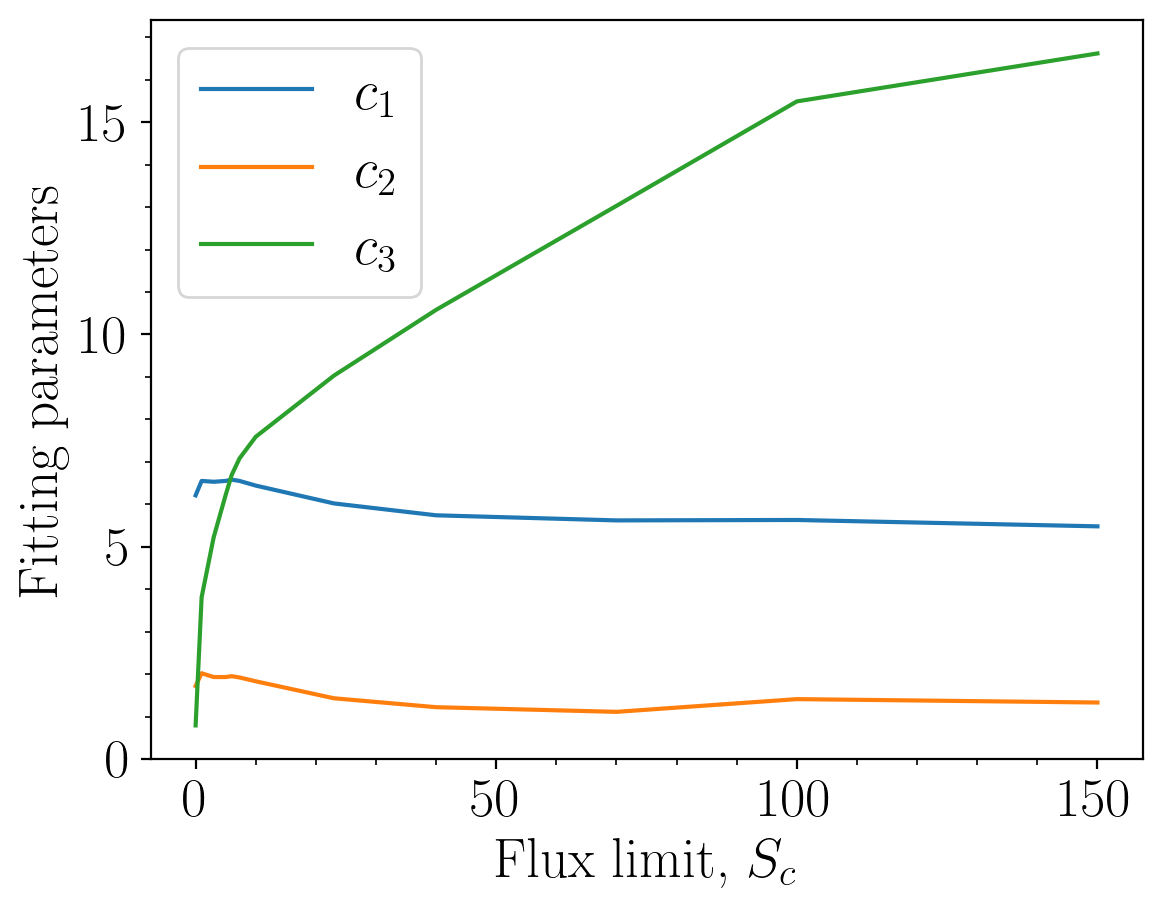

In [3]:
Ncut = 10.

Sc = fitting_params.iloc[:,0].values * Ncut/10. 

c1 = fitting_params['c1'].values
c2 = fitting_params['c2'].values
c3 = fitting_params['c3'].values

plt.plot(Sc, c1, label=r'$c_1$')
plt.plot(Sc, c2, label=r'$c_2$')
plt.plot(Sc, c3, label=r'$c_3$')

plt.xlabel(r'Flux limit, $S_{c}$')
plt.ylabel(r'Fitting parameters')
plt.legend();


In [4]:
from scipy.interpolate import interp1d

c1_int = interp1d(Sc, c1, kind='cubic', fill_value='extrapolate')
c2_int = interp1d(Sc, c2, kind='cubic', fill_value='extrapolate')
c3_int = interp1d(Sc, c3, kind='cubic', fill_value='extrapolate')


In [5]:
from scipy.interpolate import interp1d

c1_log = interp1d(np.log(Sc[1:]), c1[1:], kind='cubic', fill_value='extrapolate')
c2_log = interp1d(np.log(Sc[1:]), c2[1:], kind='cubic', fill_value='extrapolate')
c3_log = interp1d(np.log(Sc[1:]), c3[1:], kind='cubic', fill_value='extrapolate')


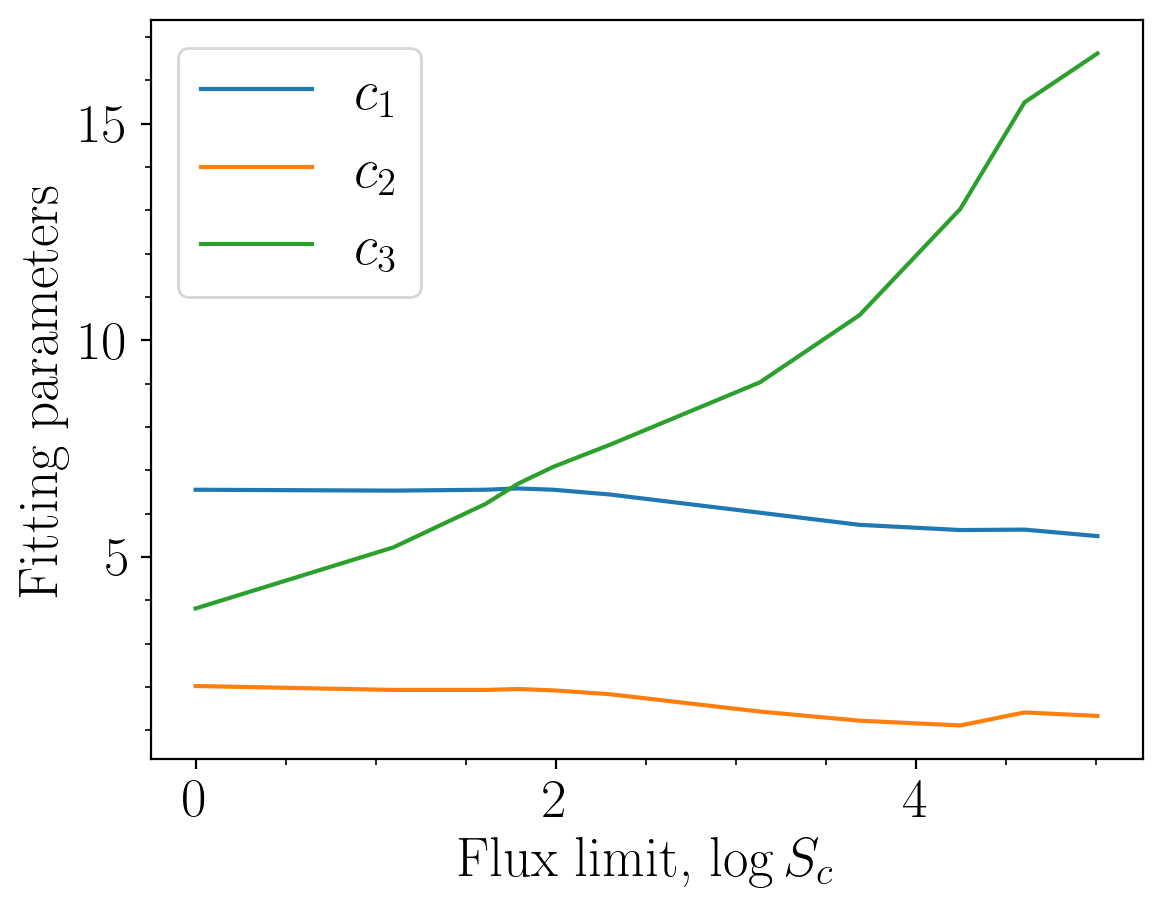

In [6]:
logSc = np.log(Sc[1:])

plt.plot(logSc, c1_log(logSc),'-',label=r'$c_1$')
plt.plot(logSc, c2_log(logSc),'-', label=r'$c_2$')
plt.plot(logSc, c3_log(logSc), '-', label=r'$c_3$')

plt.xlabel(r'Flux limit, $\log{S_{c}}$')
plt.ylabel(r'Fitting parameters')
plt.legend();


In [7]:
zSKA = np.linspace(0.1, 2.0)

Text(0, 0.5, '$N_{\\mathrm{g}}[\\mathrm{deg}^{-2}$ per unit $z]$')

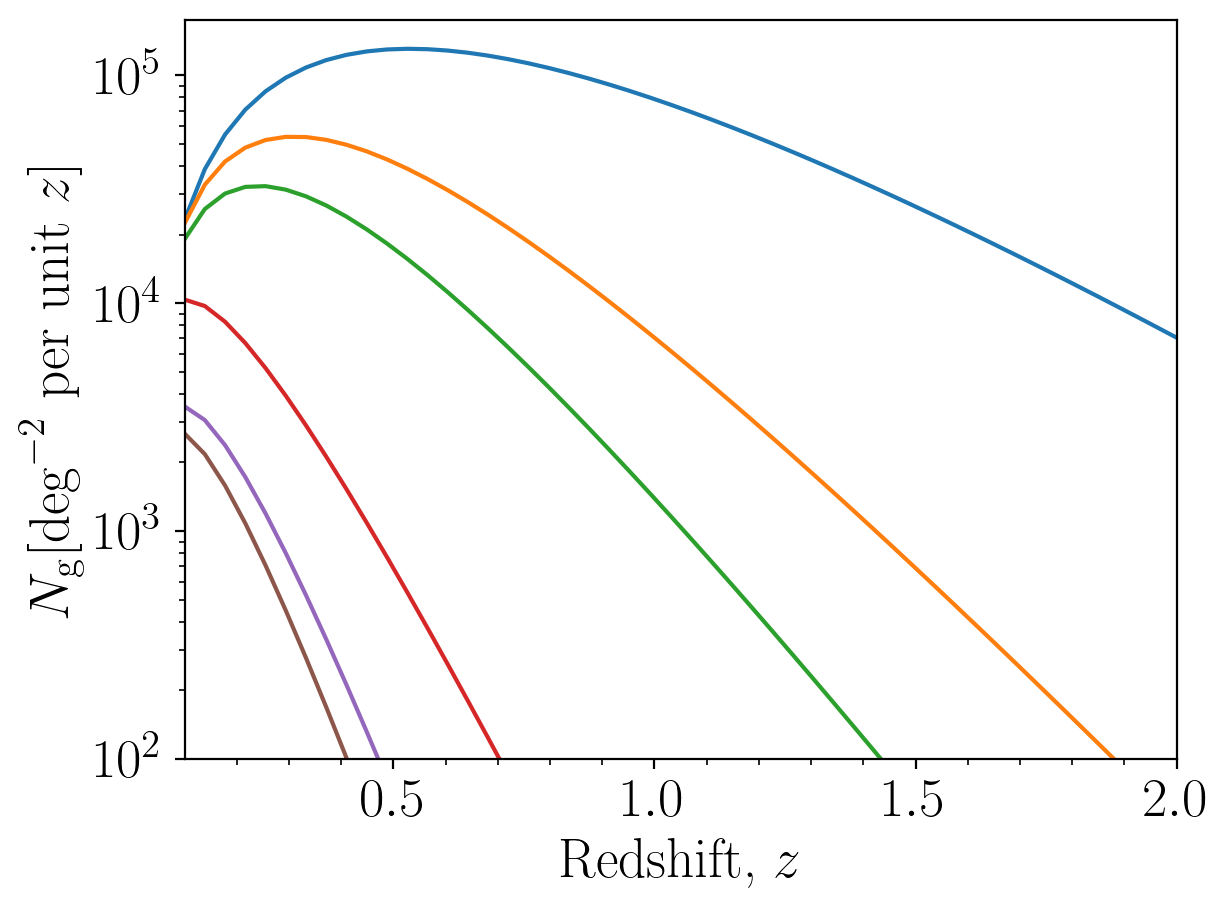

In [8]:
def N_g(z, Sc):
    return 10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z)

plt.plot(zSKA, N_g(zSKA, Sc=1.0))
plt.plot(zSKA, N_g(zSKA, Sc=5.0))
plt.plot(zSKA, N_g(zSKA, Sc=10.0))
plt.plot(zSKA, N_g(zSKA, Sc=50.0))
plt.plot(zSKA, N_g(zSKA, Sc=100.0))
plt.plot(zSKA, N_g(zSKA, Sc=150.0))


plt.ylim(bottom = 100, top = 175000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}}[\mathrm{deg}^{-2}$ per unit $z]$')

Text(0, 0.5, '$\\ln{N_{\\mathrm{g}}}[\\mathrm{deg}^{-2}]$')

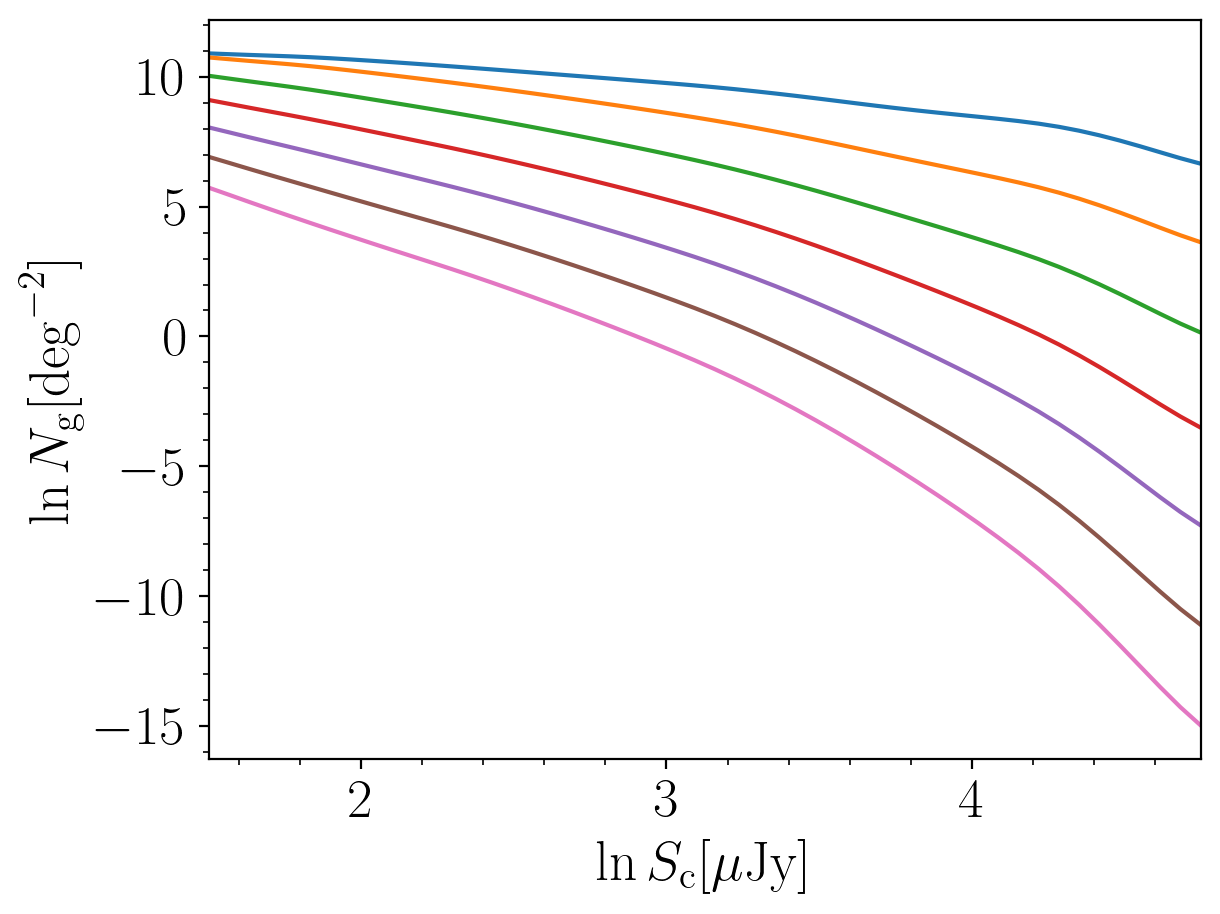

In [9]:
def LogN_g(z, Sc):
    return np.log(10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z))

logSc = np.linspace(1.5, 4.75)
Sc_ = np.exp(logSc)

plt.plot(logSc, LogN_g(0.25, Sc=Sc_))
plt.plot(logSc, LogN_g(0.5, Sc=Sc_))
plt.plot(logSc, LogN_g(0.75, Sc=Sc_))
plt.plot(logSc, LogN_g(1.0, Sc=Sc_))
plt.plot(logSc, LogN_g(1.25, Sc=Sc_))
plt.plot(logSc, LogN_g(1.5, Sc=Sc_))
plt.plot(logSc, LogN_g(1.75, Sc=Sc_))
plt.xlim(1.5, 4.75)

plt.xlabel(r'$\ln{S_\mathrm{c}}[\mu\mathrm{Jy}]$')
plt.ylabel(r'$\ln{N_{\mathrm{g}}}[\mathrm{deg}^{-2}]$')

In [10]:
Sc[1], Sc[-1]

(1.0, 150.0)

Text(0, 0.5, '$\\ln{N_{\\mathrm{g}}}[\\mathrm{deg}^{-2}]$')

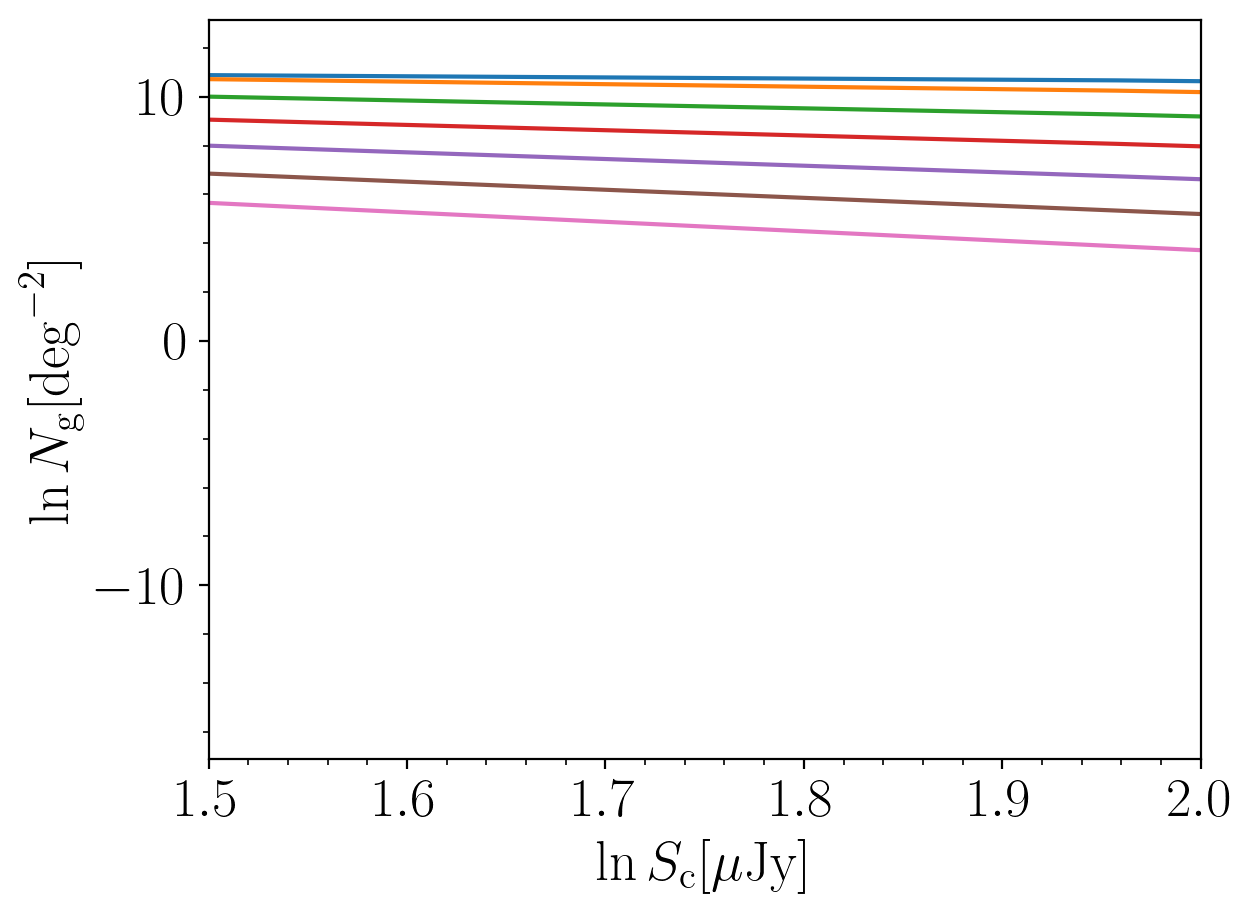

In [11]:
def LogN_g(z, logSc):
    return np.log(10**c1_log(logSc) * z**c2_log(logSc) * np.exp(-c3_log(logSc)*z))
    #return np.log(10)*c1_log(logSc) + np.log(z)*c2_log(logSc)  - c3_log(logSc)*z

logSc = np.log(np.linspace(Sc[1], Sc[-1]))

plt.plot(logSc, LogN_g(0.25, logSc))
plt.plot(logSc, LogN_g(0.5, logSc))
plt.plot(logSc, LogN_g(0.75, logSc))
plt.plot(logSc, LogN_g(1.0, logSc))
plt.plot(logSc, LogN_g(1.25, logSc))
plt.plot(logSc, LogN_g(1.5, logSc))
plt.plot(logSc, LogN_g(1.75, logSc))
plt.xlim(1.5, 2.0)

plt.xlabel(r'$\ln{S_\mathrm{c}}[\mu\mathrm{Jy}]$')
plt.ylabel(r'$\ln{N_{\mathrm{g}}}[\mathrm{deg}^{-2}]$')

Text(0.5, 1.0, 'Flux sensitivity SKAO2 (P. Bull, 2016)')

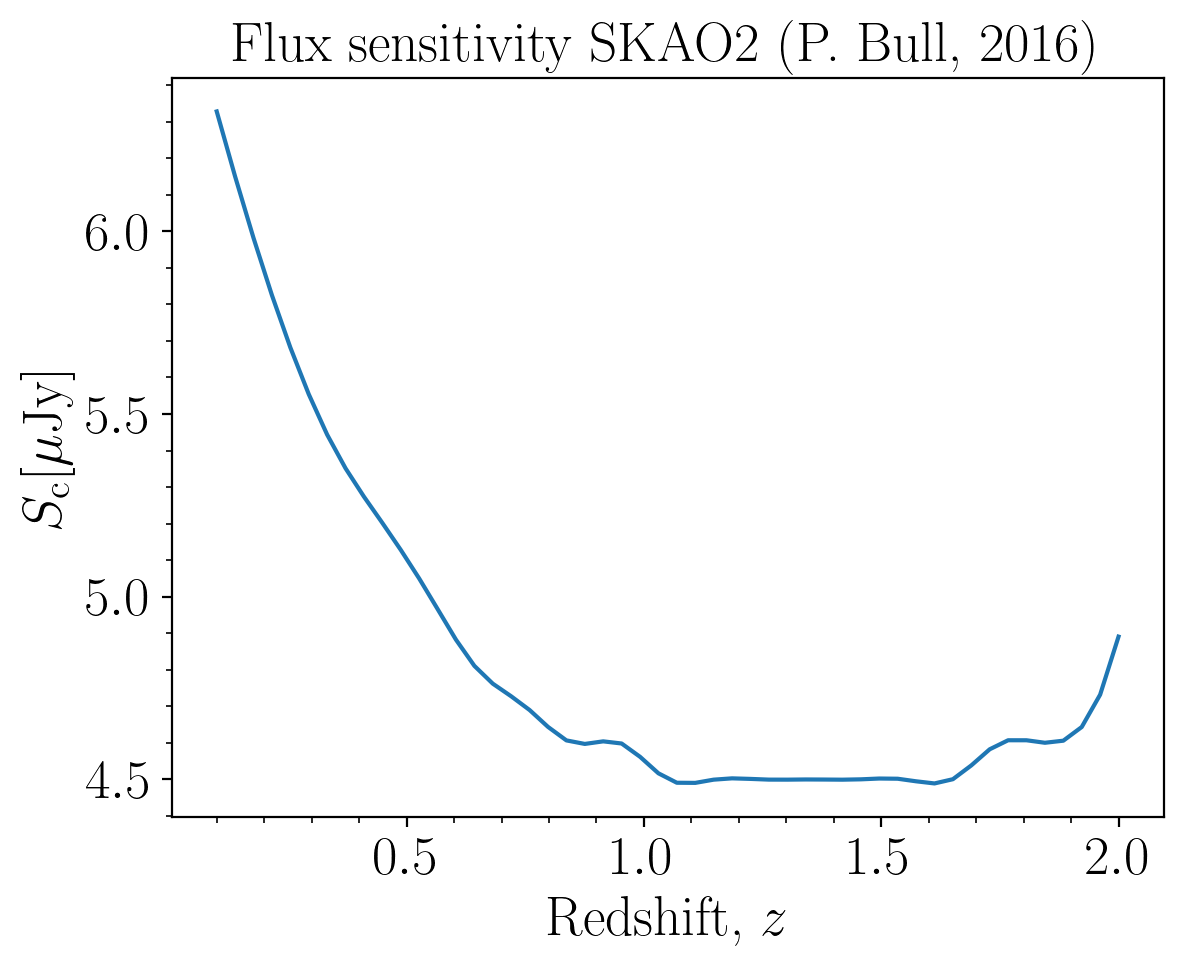

In [12]:
# From P. Bull (2015)

z_data = np.linspace(0.15, 1.95, 19)

Srms_Bull = np.array([6.1, 5.7, 5.4, 5.2, 5.0, 4.8, 4.7, 4.6, 4.6, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.6, 4.6, 4.7])

Srms_fitz = interp1d(z_data, Srms_Bull, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, Srms_fitz(zSKA))
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$S_\mathrm{c}[\mu\mathrm{Jy}]$')
plt.title(r'Flux sensitivity SKAO2 (P. Bull, 2016)')

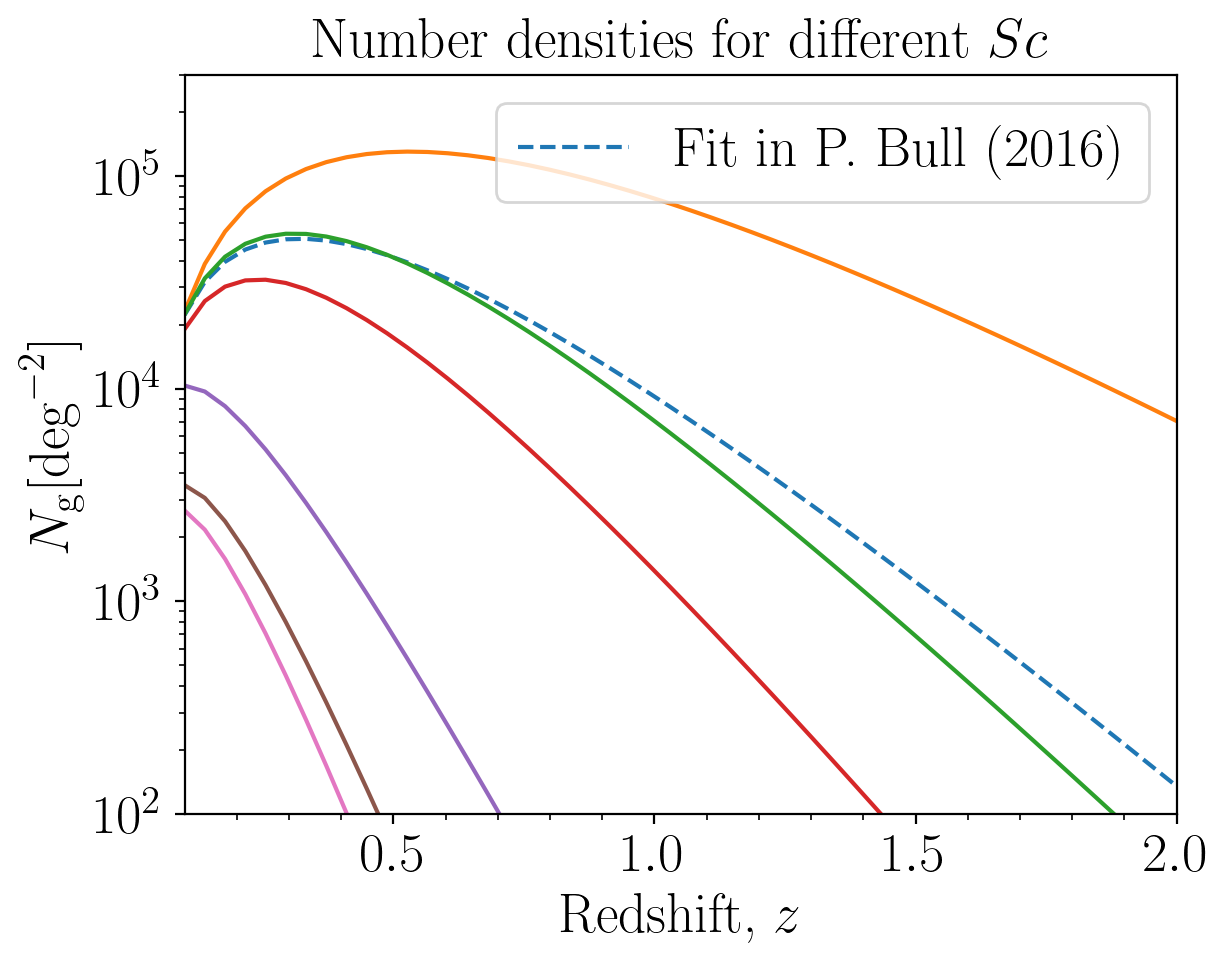

In [13]:
# Fitting functions in P. Bull (2016)

def N_g_fit(z, c1=6.319, c2=1.736, c3=5.423):
    
    return 10**c1 * z**c2 * np.exp(-c3*z)

plt.plot(zSKA, N_g_fit(zSKA), '--', label='Fit in P. Bull (2016)')
plt.plot(zSKA, N_g(zSKA, Sc=1.0))
plt.plot(zSKA, N_g(zSKA, Sc=5.0))
plt.plot(zSKA, N_g(zSKA, Sc=10.0))
plt.plot(zSKA, N_g(zSKA, Sc=50.0))
plt.plot(zSKA, N_g(zSKA, Sc=100.0))
plt.plot(zSKA, N_g(zSKA, Sc=150.0))


plt.ylim(bottom = 100, top = 300000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}}[\mathrm{deg}^{-2}]$')
plt.title(r'Number densities for different $Sc$')
plt.legend()

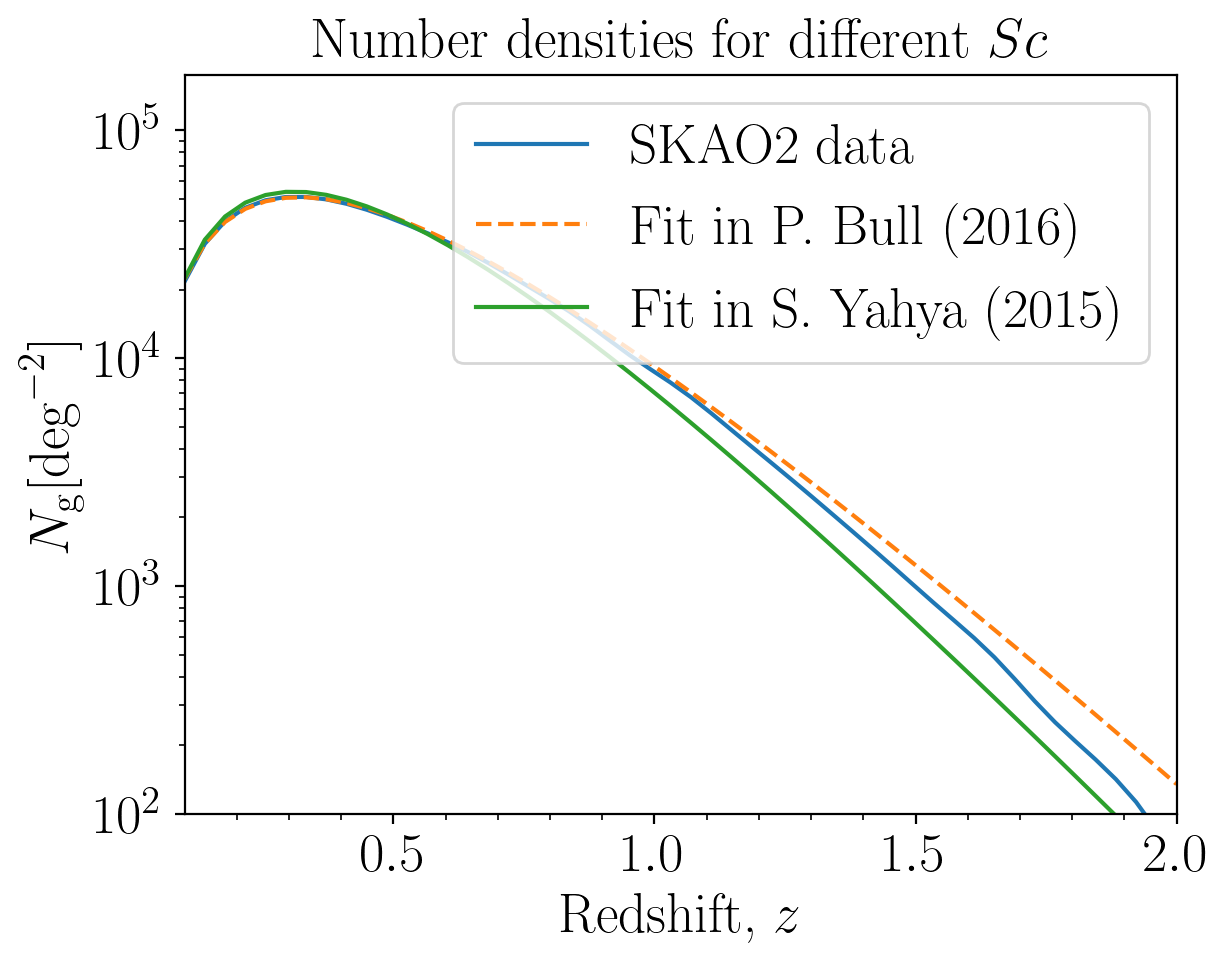

In [14]:
Ncut=10

Sc_fit = Srms_fitz(zSKA) * Ncut/10

plt.plot(zSKA, N_g(zSKA, Sc=Sc_fit), label='SKAO2 data')
plt.plot(zSKA, N_g_fit(zSKA), '--', label='Fit in P. Bull (2016)')
plt.plot(zSKA, N_g(zSKA, Sc=5.0), label='Fit in S. Yahya (2015)')

plt.ylim(bottom = 100, top = 175000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}}[\mathrm{deg}^{-2}]$')
plt.title(r'Number densities for different $Sc$')
plt.legend(loc = "upper right")

Text(0.5, 1.0, 'Flux sensitivity SKAO2 (R. Maartens, 2022)')

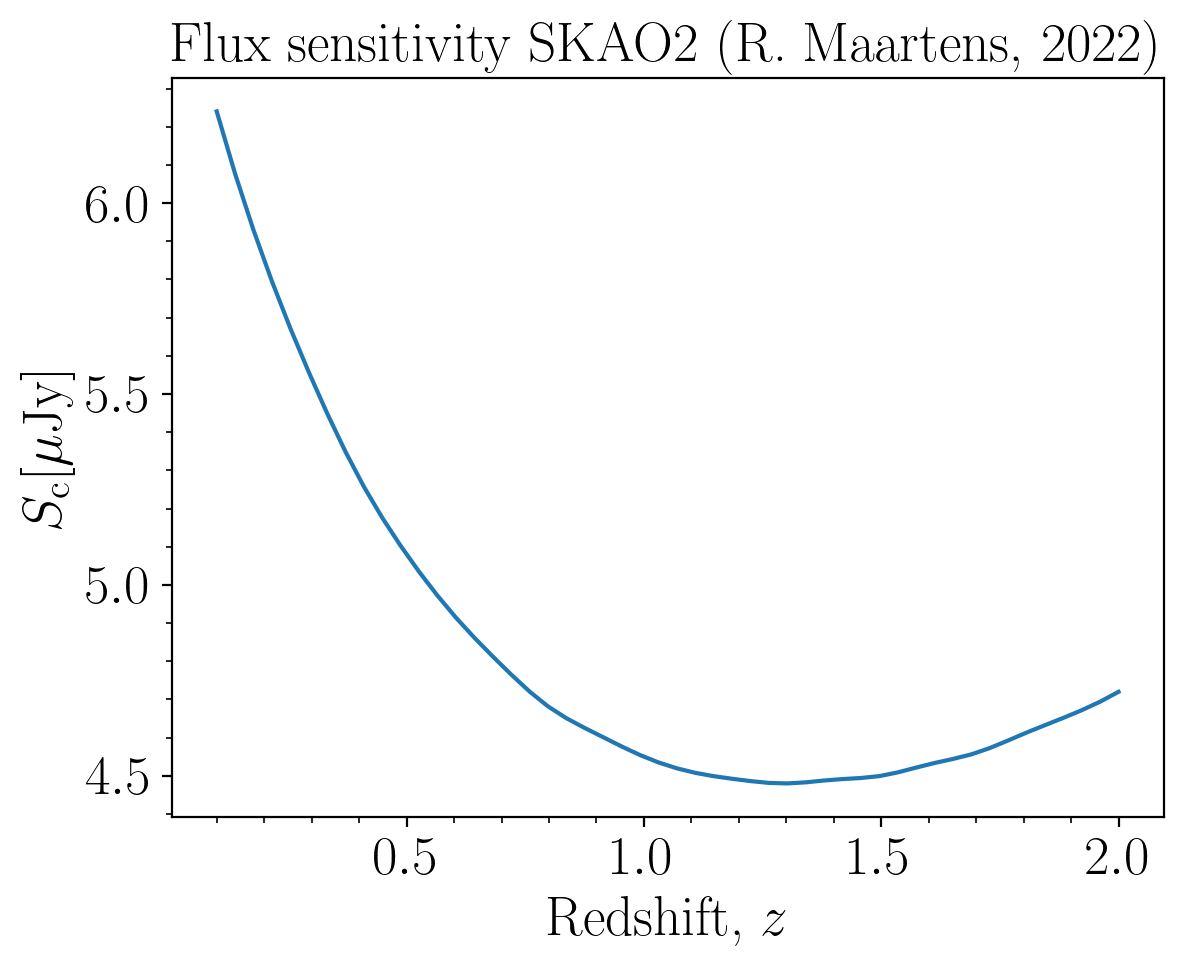

In [15]:
# From R. Maartens et a.l. (2022)

z_data = np.linspace(0.1, 2.0, 20)

Srms_Roy = np.array([6.24, 5.85, 5.54, 5.28, 5.08, 4.92, 4.79, 4.68, 4.61, 4.55, 4.51, 4.49, 4.48, 4.49, 4.5, 4.53, 4.56, 4.61, 4.66, 4.72])

Srms_fitz = interp1d(z_data, Srms_Roy, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, Srms_fitz(zSKA))
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$S_\mathrm{c}[\mu\mathrm{Jy}]$')
plt.title(r'Flux sensitivity SKAO2 (R. Maartens, 2022)')

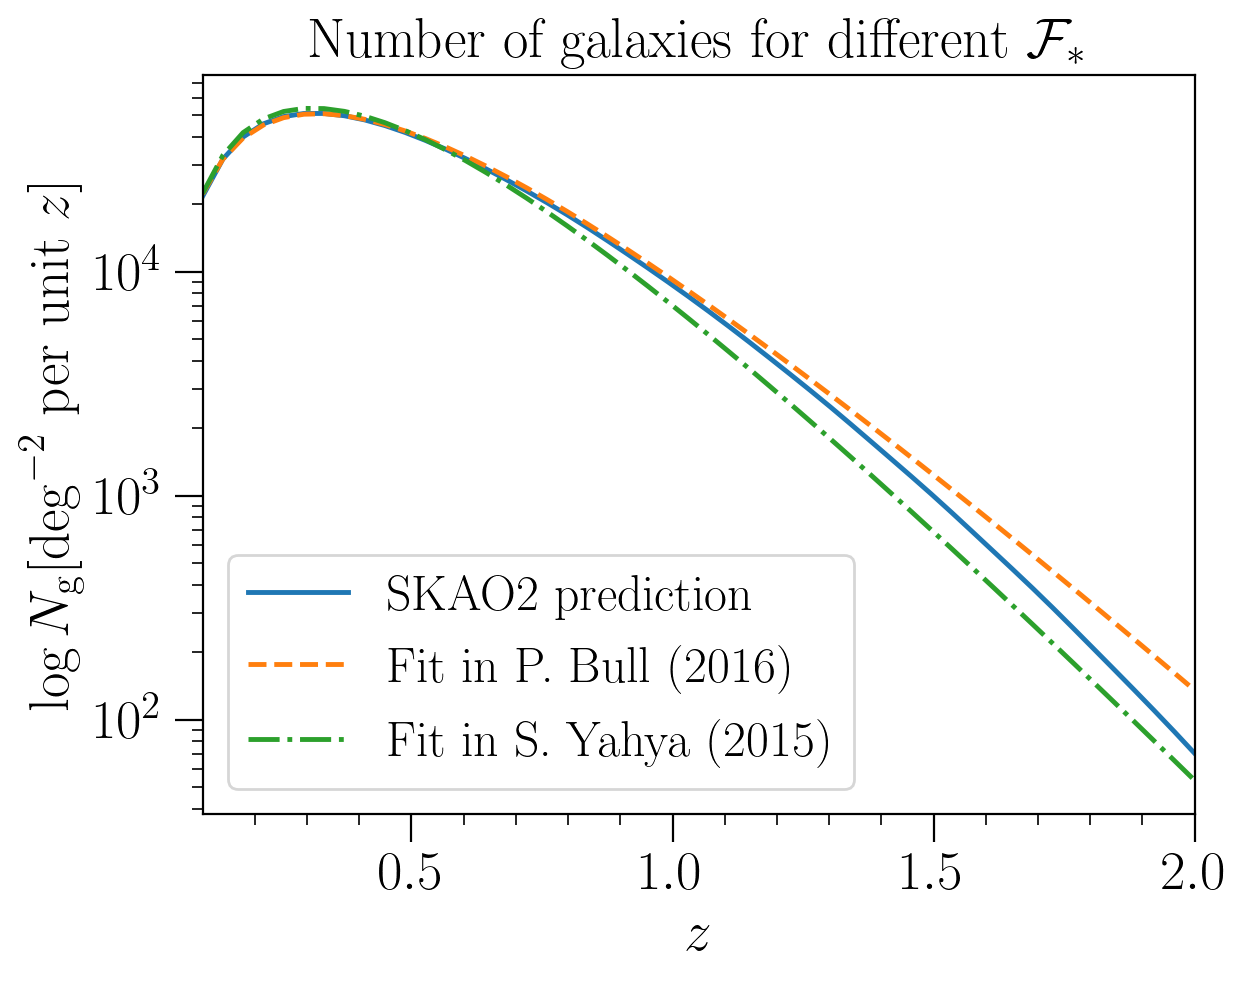

In [16]:
Ncut=10

Sc_fit = Srms_fitz(zSKA) * Ncut/10

plt.plot(zSKA, N_g(zSKA, Sc=Sc_fit), linewidth=1.75, label='SKAO2 prediction')
plt.plot(zSKA, N_g_fit(zSKA), '--', linewidth=1.75, label='Fit in P. Bull (2016)')
plt.plot(zSKA, N_g(zSKA, Sc=5.0), '-.', linewidth=1.75, label='Fit in S. Yahya (2015)')

#plt.ylim(bottom = 100, top = 175000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.tick_params(which = 'major', length = 10)
plt.tick_params(which = 'minor', length = 4)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log{N_{\mathrm{g}}}[\mathrm{deg}^{-2}$ per unit $z]$')
plt.title(r'Number of galaxies for different $\mathcal{F}_*$')
plt.legend(fontsize = 18)

plt.savefig("plots/Ng_as_z.pdf", bbox_inches='tight', format='pdf')

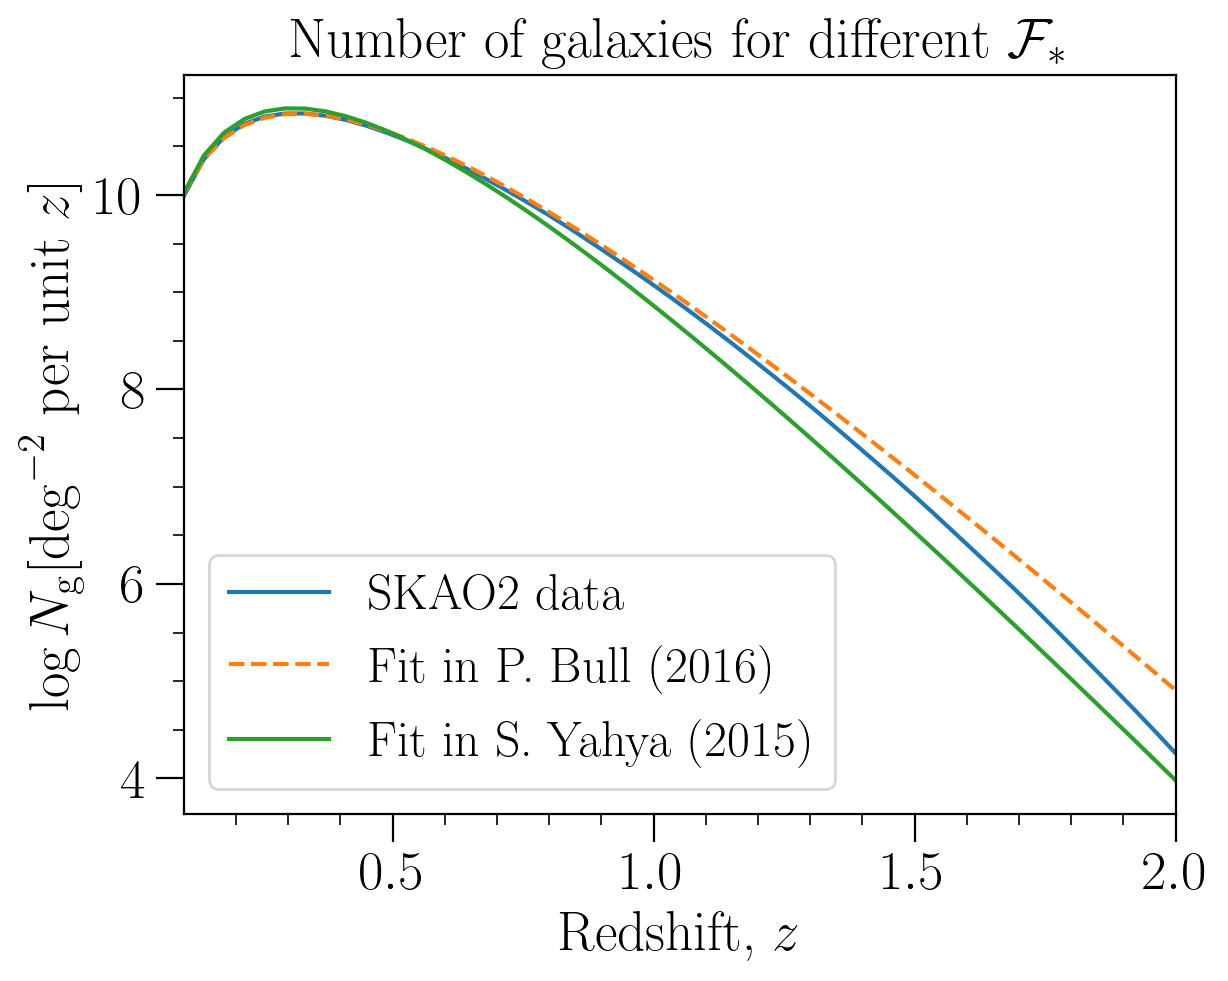

In [17]:
Ncut=10

Sc_fit = Srms_fitz(zSKA) * Ncut/10

plt.plot(zSKA, np.log(N_g(zSKA, Sc=Sc_fit)), label='SKAO2 data')
plt.plot(zSKA, np.log(N_g_fit(zSKA)), '--', label='Fit in P. Bull (2016)')
plt.plot(zSKA, np.log(N_g(zSKA, Sc=5.0)), label='Fit in S. Yahya (2015)')

#plt.ylim(bottom = 100, top = 175000)
plt.xlim(0.1, 2.0)
#plt.yscale('log')

plt.tick_params(which = 'major', length = 10)
plt.tick_params(which = 'minor', length = 4)

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$\log{N_{\mathrm{g}}}[\mathrm{deg}^{-2}$ per unit $z]$')
plt.title(r'Number of galaxies for different $\mathcal{F}_*$')
plt.legend(fontsize = 18)

### New fit for the SKA02 data

We try first with 'curve_fit' method. 

In [18]:
from scipy.optimize import curve_fit

Ncut=10

Sc_fit = Srms_fitz(z_data) * Ncut/10

def N_g_fit_(z, c1, c2, c3):
    
    return 10**c1 * z**c2 * np.exp(-c3*z)

params, covs = curve_fit(N_g_fit_, z_data, N_g(z_data, Sc=Sc_fit))

C:\Users\Daniel SB\AppData\Local\Temp\ipykernel_4008\602142079.py:9: RuntimeWarning: overflow encountered in power
  return 10**c1 * z**c2 * np.exp(-c3*z)
C:\Users\Daniel SB\AppData\Local\Temp\ipykernel_4008\602142079.py:9: RuntimeWarning: overflow encountered in multiply
  return 10**c1 * z**c2 * np.exp(-c3*z)


In [19]:
# Fitting parameters

print('c1 = ', params[0])
print('c2 = ', params[1])
print('c3 = ', params[2])

c1 =  6.367168333043673
c2 =  1.7795917313680287
c3 =  5.60540196081145


#### Parameters are similar than those of [P. Bull (2016)](https://arxiv.org/abs/1509.07562)

In [20]:
print('c1 = ', 6.319)
print('c2 = ', 1.736)
print('c3 = ', 5.424)

c1 =  6.319
c2 =  1.736
c3 =  5.424


In [21]:
MSE = np.mean((N_g(z_data, Sc=Sc_fit) - N_g_fit_(z_data, *params))**2/N_g(z_data, Sc=Sc_fit)**2)
print('Mean Squared Error, MSE = ', MSE)

Mean Squared Error, MSE =  0.028739235373755743


In [22]:
# Your observed data, which I assume is N_g(z_data, Sc=Sc_fit)
observed_values = N_g(z_data, Sc=Sc_fit)

# Obtain the model's predictions for the data points
predicted_values = N_g_fit_(z_data, *params)

# Calculate the residuals (differences between observed and predicted values)
residuals = observed_values - predicted_values

# Compute the Sum of Squared Residuals (SSR)
ssr = np.sum(residuals**2)

# Compute the Total Sum of Squares (SST)
sst = np.sum((observed_values - np.mean(observed_values))**2)

# Calculate the R-squared value
r_squared = 1 - (ssr / sst)

print("R-squared:", r_squared)

R-squared: 0.999918214477413


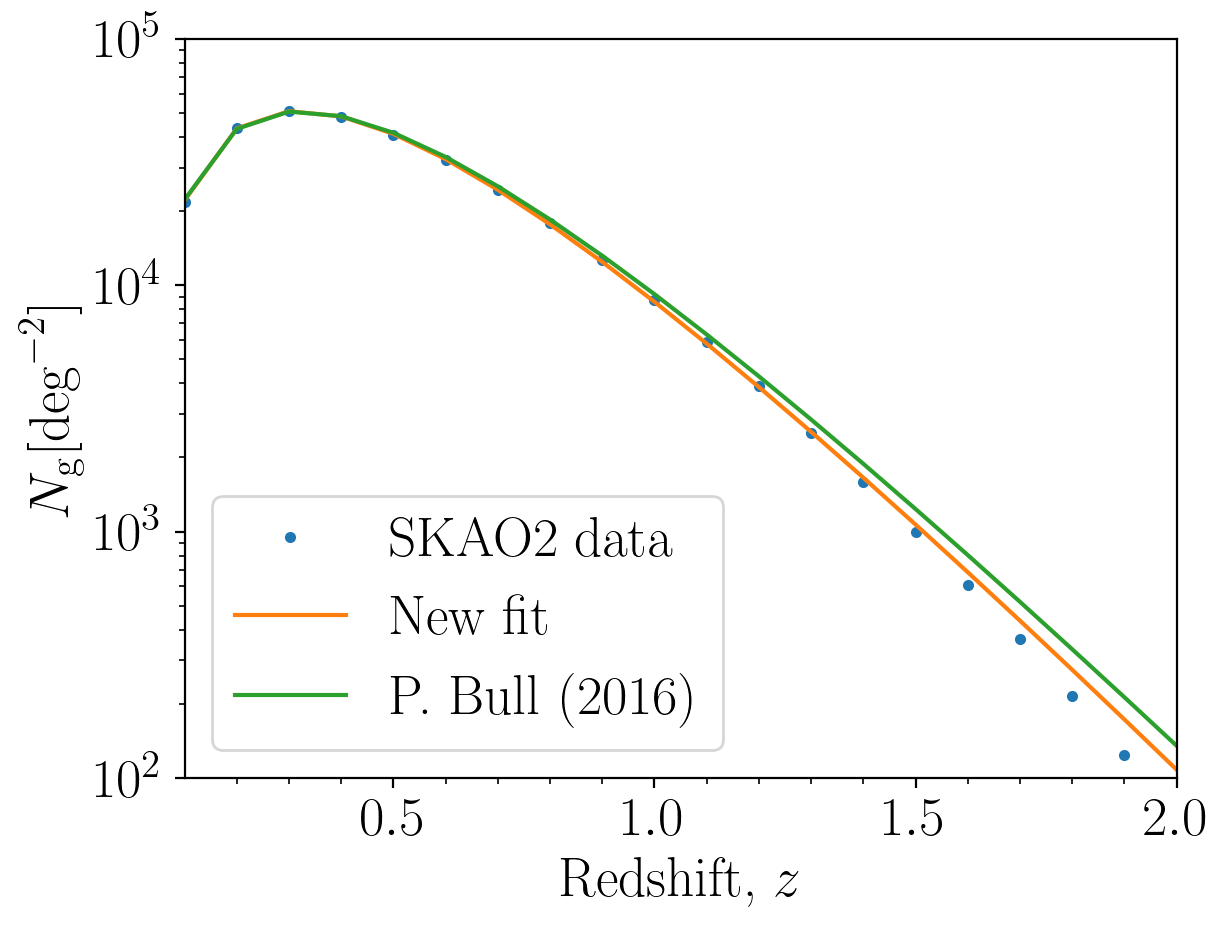

In [23]:
plt.plot(z_data, N_g(z_data, Sc=Sc_fit),'.', label='SKAO2 data')
plt.plot(z_data, N_g_fit_(z_data, *params), label=r'New fit')
plt.plot(z_data, N_g_fit(z_data), label=r'P. Bull (2016)')

plt.ylim(bottom = 100, top = 100000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}}[\mathrm{deg}^{-2}]$')
plt.legend();

### New fit for the SKA02 data

We try with 'least_squares' method. 

In [24]:
from scipy.optimize import least_squares

def fitting_model(params, z):
    c1, c2, c3 = params
    return 10**c1 * z**c2 * np.exp(-c3 * z)

def residuals(params, z, y):
    return y - fitting_model(params, z)

# Your observed data, which I assume is N_g(z_data, Sc=Sc_fit)
Sc_fit = Srms_fitz(z_data) * Ncut/10
y_data = N_g(z_data, Sc=Sc_fit)

# Initial guess for parameters
initial_params = [1, 1, 1]

# Fit the model using least_squares
result = least_squares(residuals, initial_params, args=(z_data, y_data))

# Extract the fitted parameters
params_ = result.x

In [25]:
# Fitting parameters

print('c1 = ', params_[0])
print('c2 = ', params_[1])
print('c3 = ', params_[2])

c1 =  6.367168334147404
c2 =  1.7795917337352392
c3 =  5.605401961153056


In [26]:
# Your observed data, which I assume is N_g(z_data, Sc=Sc_fit)
observed_values = N_g(z_data, Sc=Sc_fit)

# Obtain the model's predictions for the data points
predicted_values = fitting_model(params_, z_data)

# Calculate the residuals (differences between observed and predicted values)
residuals = observed_values - predicted_values

# Compute the Sum of Squared Residuals (SSR)
ssr = np.sum(residuals**2)

# Compute the Total Sum of Squares (SST)
sst = np.sum((observed_values - np.mean(observed_values))**2)

# Calculate the R-squared value
r_squared = 1 - (ssr / sst)

print("R-squared:", r_squared)


R-squared: 0.999918214477413


# Splitting the populations of Galaxies. 


## Magnification bias

We try to apply the same approach as in the biasfuncs.py script. 

For the magnification bias, we take $\log{N_{g}}$ and numerically solve for the flux cuts of the bright population so that we have the same amount of bright and faint galaxies per redshift bin. We take the information of the full SKA Phase 2 survey in this case. 

Now, the $s_{\mathrm{model}}$ is not taken from the fitting function in [S. Camera et a.l. (2016)](https://arxiv.org/abs/1409.8286), but the numerical derivative of $\log{N_{g}}$. 

$$s_{\mathrm{model}} = - \frac{2}{5} \frac{\partial\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}}{\partial\log{S_{\mathrm{c}}}} = \frac{2}{5}\,\mathcal{Q}$$

In [27]:
# Define the functions

from scipy.optimize import fsolve

def stencil_derivative(fun, x, h=0.001):
    if type(x) == list:
        x=np.array(x)    
    d = (-fun(x+2*h) + 8*fun(x+h) - 8*fun(x-h) + fun(x-2*h))/(12*h)
    return d

def LogN_g(z, Sc):
    return np.log(10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z))

def sc_equation(x, z, Sc, n_split=2):
    return np.log(n_split) + LogN_g(z, x) - LogN_g(z, Sc)

def sc_solver(z, Sc, n_split, guess):
        sol = fsolve(sc_equation, guess, args=(z,Sc,n_split))
        return sol


In [28]:
# Calculate the flux cuts for the bright population

Ncut = 10

Sc_data = Srms_fitz(z_data) * Ncut/10

n_split = 2.

guess = np.array([1.]*len(z_data))

Sc_bright = sc_solver(z=z_data, Sc=Sc_data, n_split=n_split, guess=guess)

print(np.log(Sc_bright))

[3.79200477 2.82129841 2.49756396 2.32140605 2.19284828 2.08988111
 2.00513361 1.93368815 1.87680415 1.82772122 1.78800271 1.75735487
 1.73304632 1.71658474 1.70282105 1.69565301 1.69020909 1.69055349
 1.6920217  1.69658188]


In [29]:
print(np.log(Sc_data))

[1.83098018 1.76644166 1.7119945  1.6639261  1.62531126 1.59330853
 1.56653041 1.54329811 1.52822786 1.51512723 1.50629715 1.5018527
 1.49962305 1.5018527  1.5040774  1.51072194 1.51732262 1.52822786
 1.53901545 1.5518088 ]


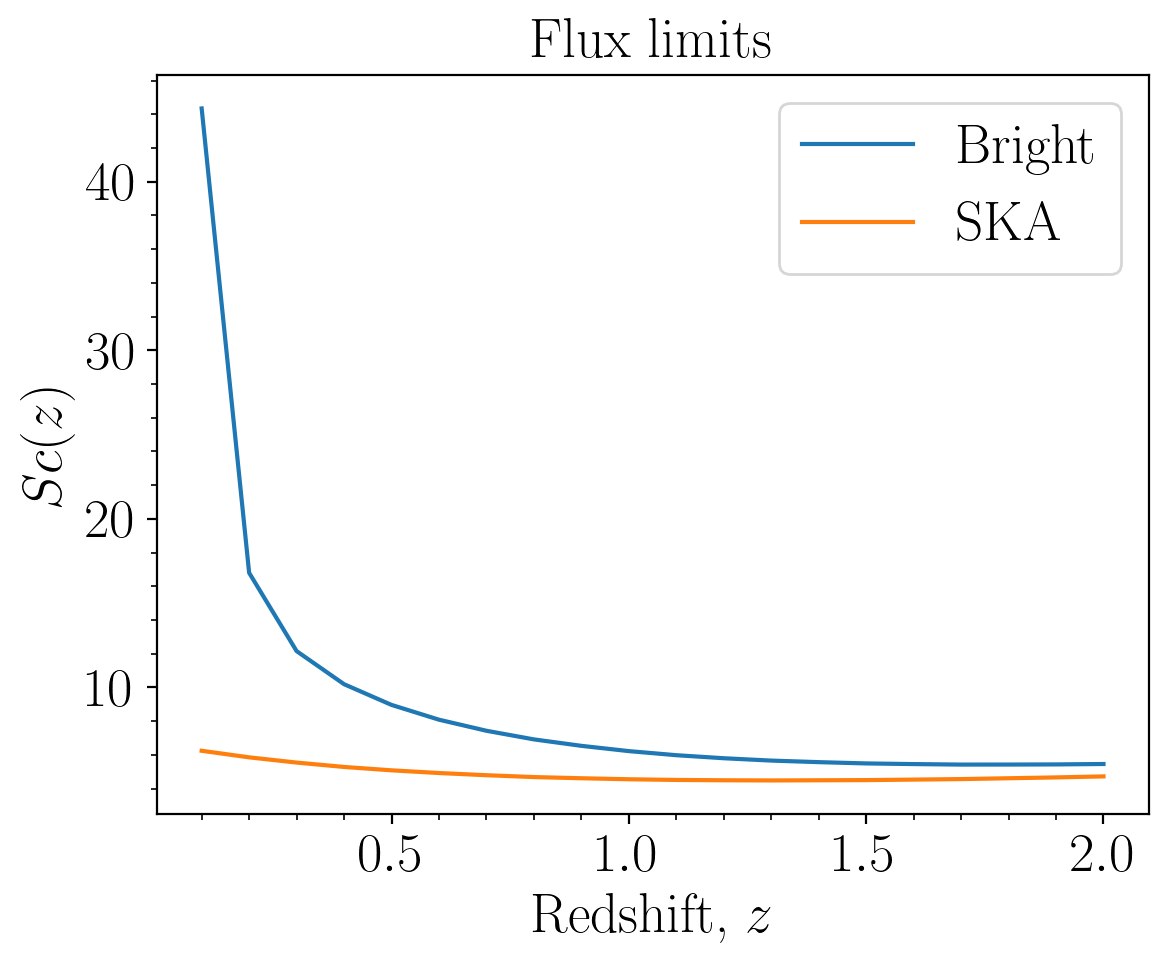

In [30]:
plt.plot(z_data, Sc_bright, label='Bright')
plt.plot(z_data, Sc_data, label='SKA')

plt.title(r'Flux limits')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$Sc(z)$')
plt.legend()

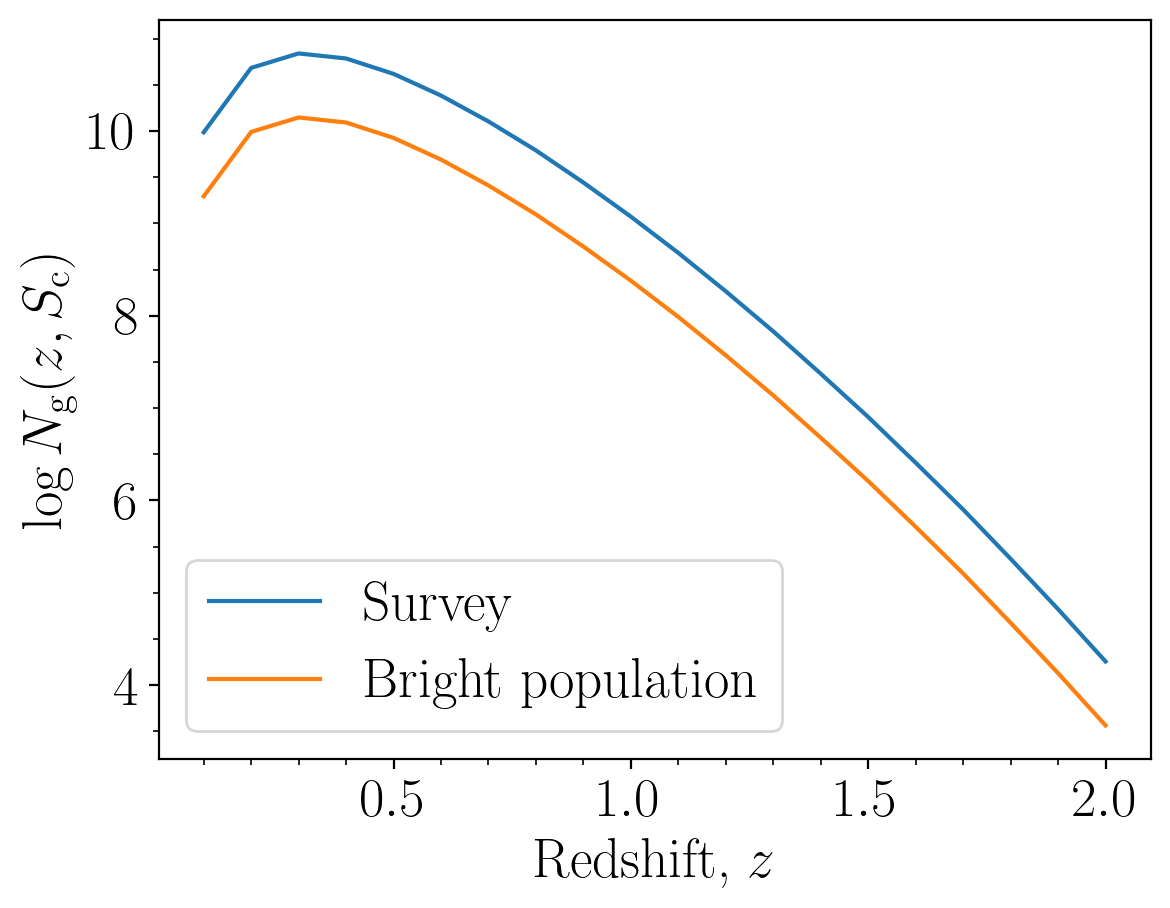

In [31]:
plt.plot(z_data, LogN_g(z_data, Sc_data), label='Survey')
plt.plot(z_data, LogN_g(z_data, Sc_bright), label='Bright population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}$')
plt.legend();

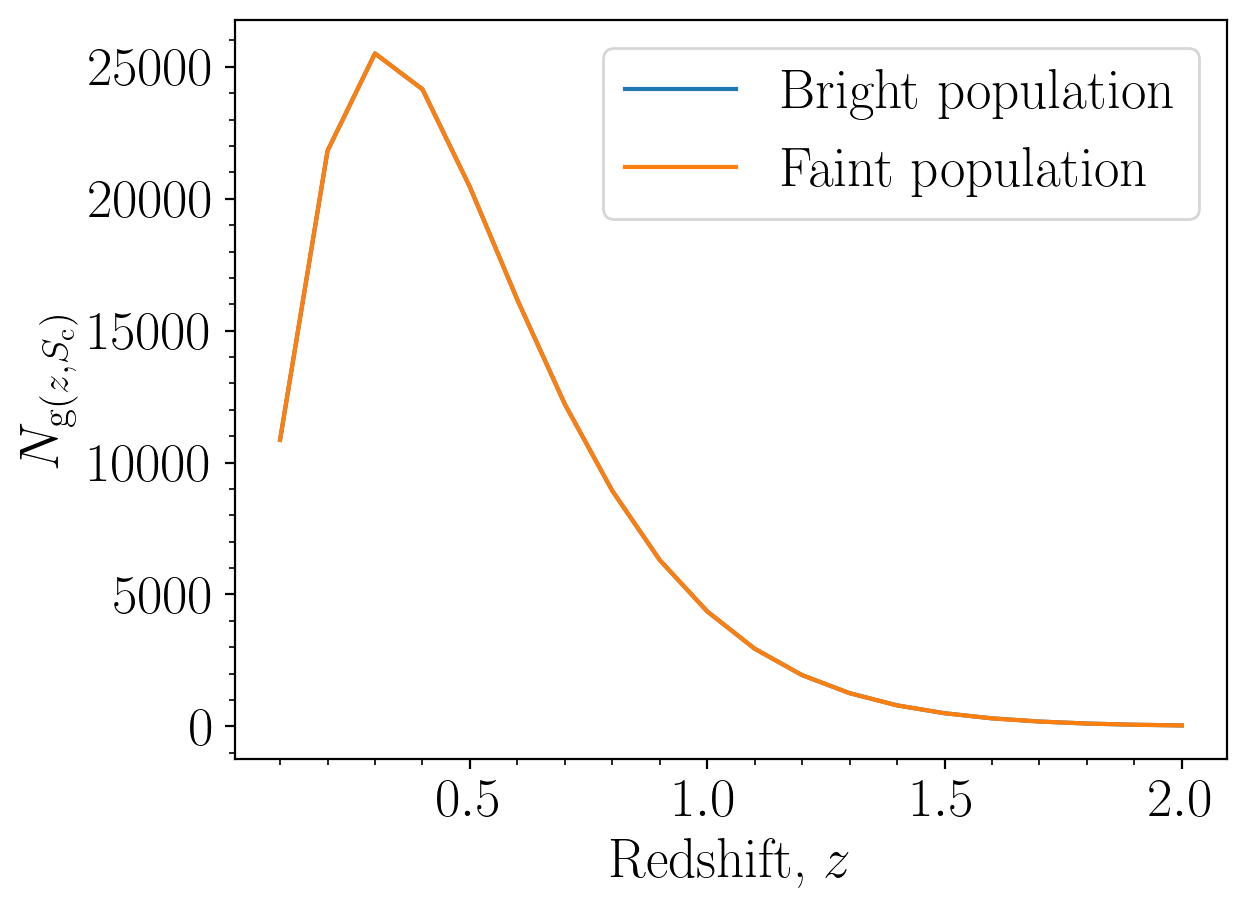

In [32]:
#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(z_data, np.exp(LogN_g(z_data, Sc_bright)), label='Bright population')
plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)) - np.exp(LogN_g(z_data, Sc_bright)), label='Faint population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

Using the fittin formula for $N_{\mathrm{g}}(z, S_{\mathrm{c}})$ of [S. Yahya et a.l. (2015)](https://arxiv.org/abs/1412.4700), it is convenient to find te logarithm of it:

$$ \log{N_{\mathrm{g}}(z, S_{\mathrm{c}})} = c_1(S_{\mathrm{c}})\,\log{10} + c_2(S_{\mathrm{c}})\,\log{z} + c_3(S_{\mathrm{c}})\,z$$

In [33]:
# Derivative of Qmodel as Log N_g with respect to log Sc

def Qmodel(z, Sc):
    res = - Sc * ( stencil_derivative(c1_int, x=Sc)*np.log(10) + stencil_derivative(c2_int, x=Sc)*np.log(z) - stencil_derivative(c3_int, x=Sc)*z )
    return res

# Magnification bias

def s_model(z, Sc):
    return 2/5 * Qmodel(z, Sc)

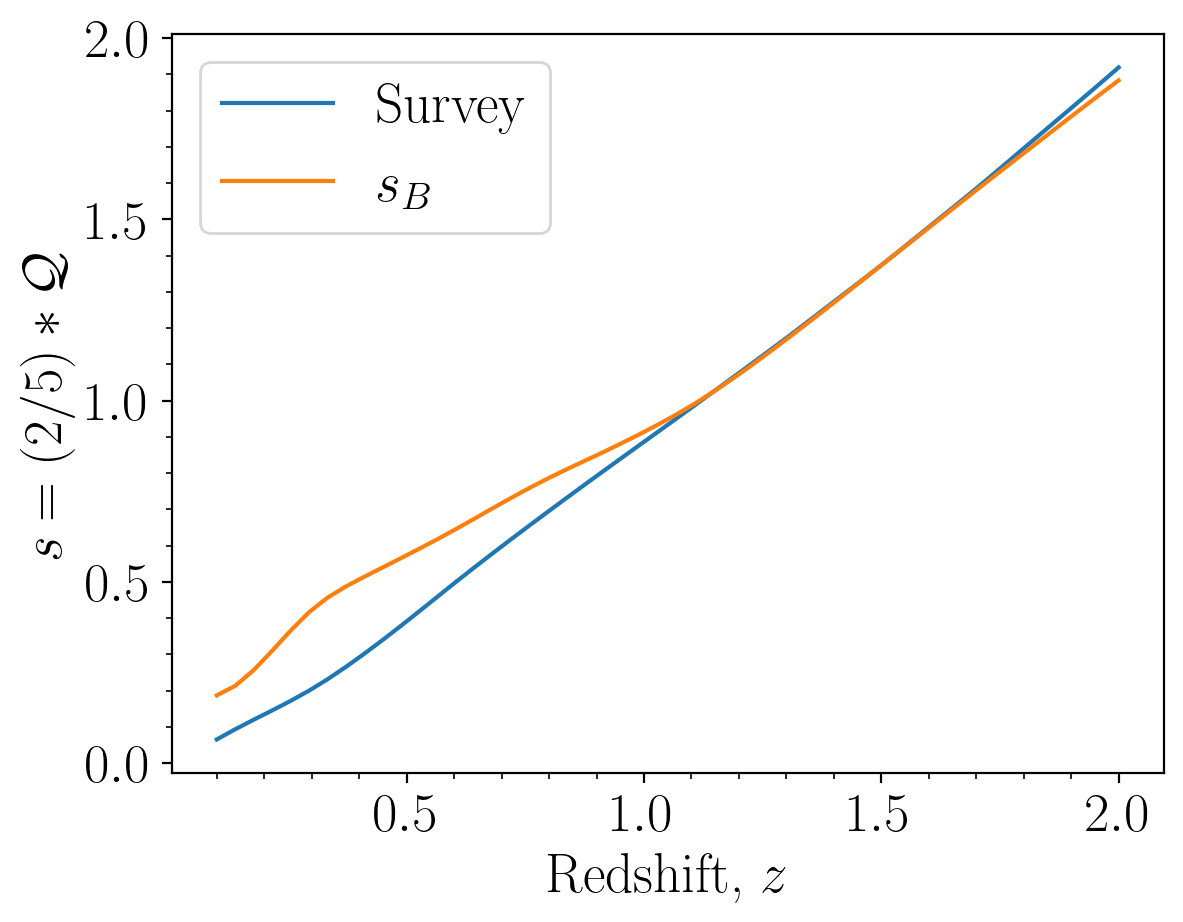

In [34]:
smodelF_data = s_model(z_data, Sc_data)
smodelB_data = s_model(z_data, Sc_bright)

smodelF = interp1d(z_data, smodelF_data, kind='cubic', fill_value='extrapolate')
smodelB = interp1d(z_data, smodelB_data, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, smodelF(zSKA), label='Survey')
plt.plot(zSKA, smodelB(zSKA), label='$s_B$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$s = (2/5) * \mathcal{Q}$')
plt.legend();

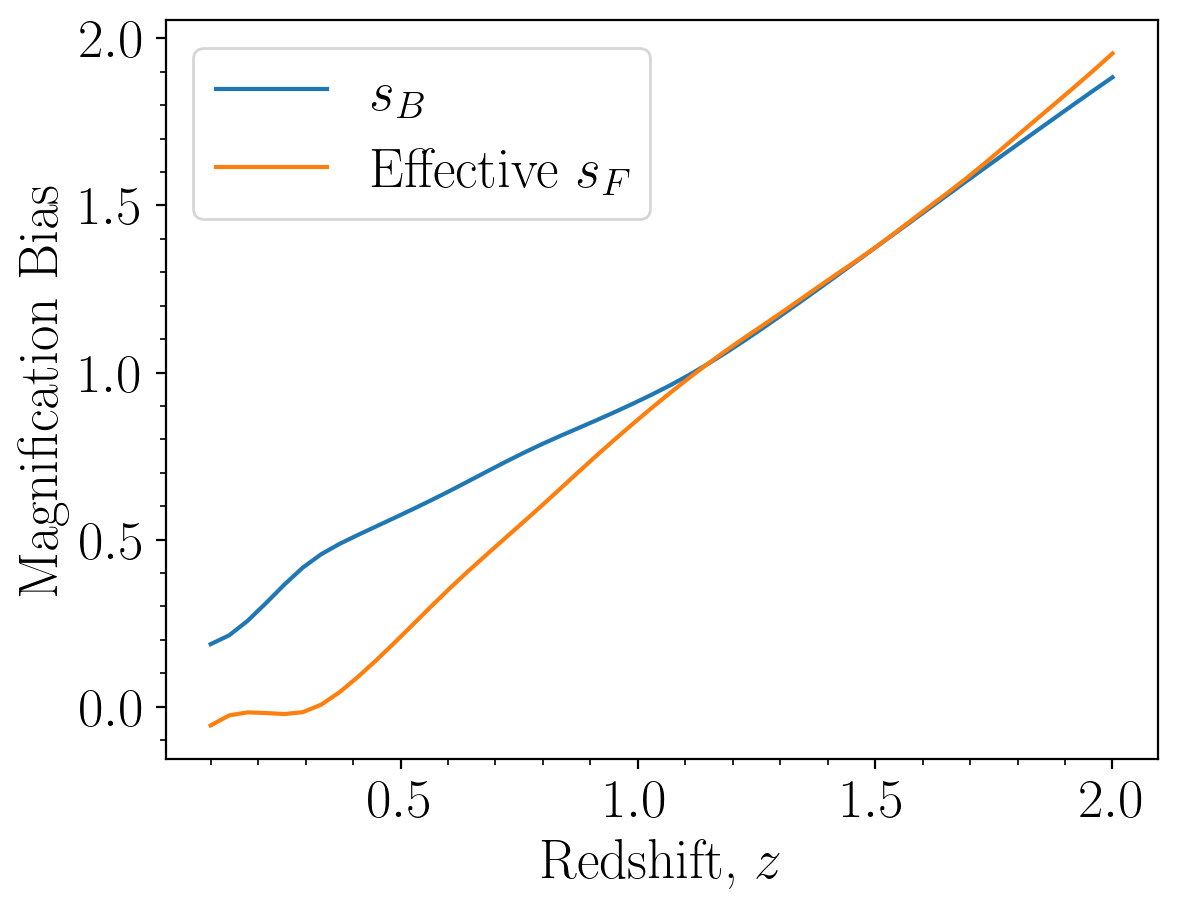

In [35]:
sBright = smodelB(z_data)
sFaint = n_split * smodelF(z_data) - smodelB(z_data)

#plt.plot(z_data, sBright, 'r.',label='$s_B$, SKA2')
#plt.plot(z_data, sFaint, 'k.',label='$s_F$ SKA2')

plt.plot(zSKA, smodelB(zSKA), label='$s_B$')
plt.plot(zSKA, 2*smodelF(zSKA) - smodelB(zSKA), label='Effective $s_F$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Magnification Bias')
plt.legend();

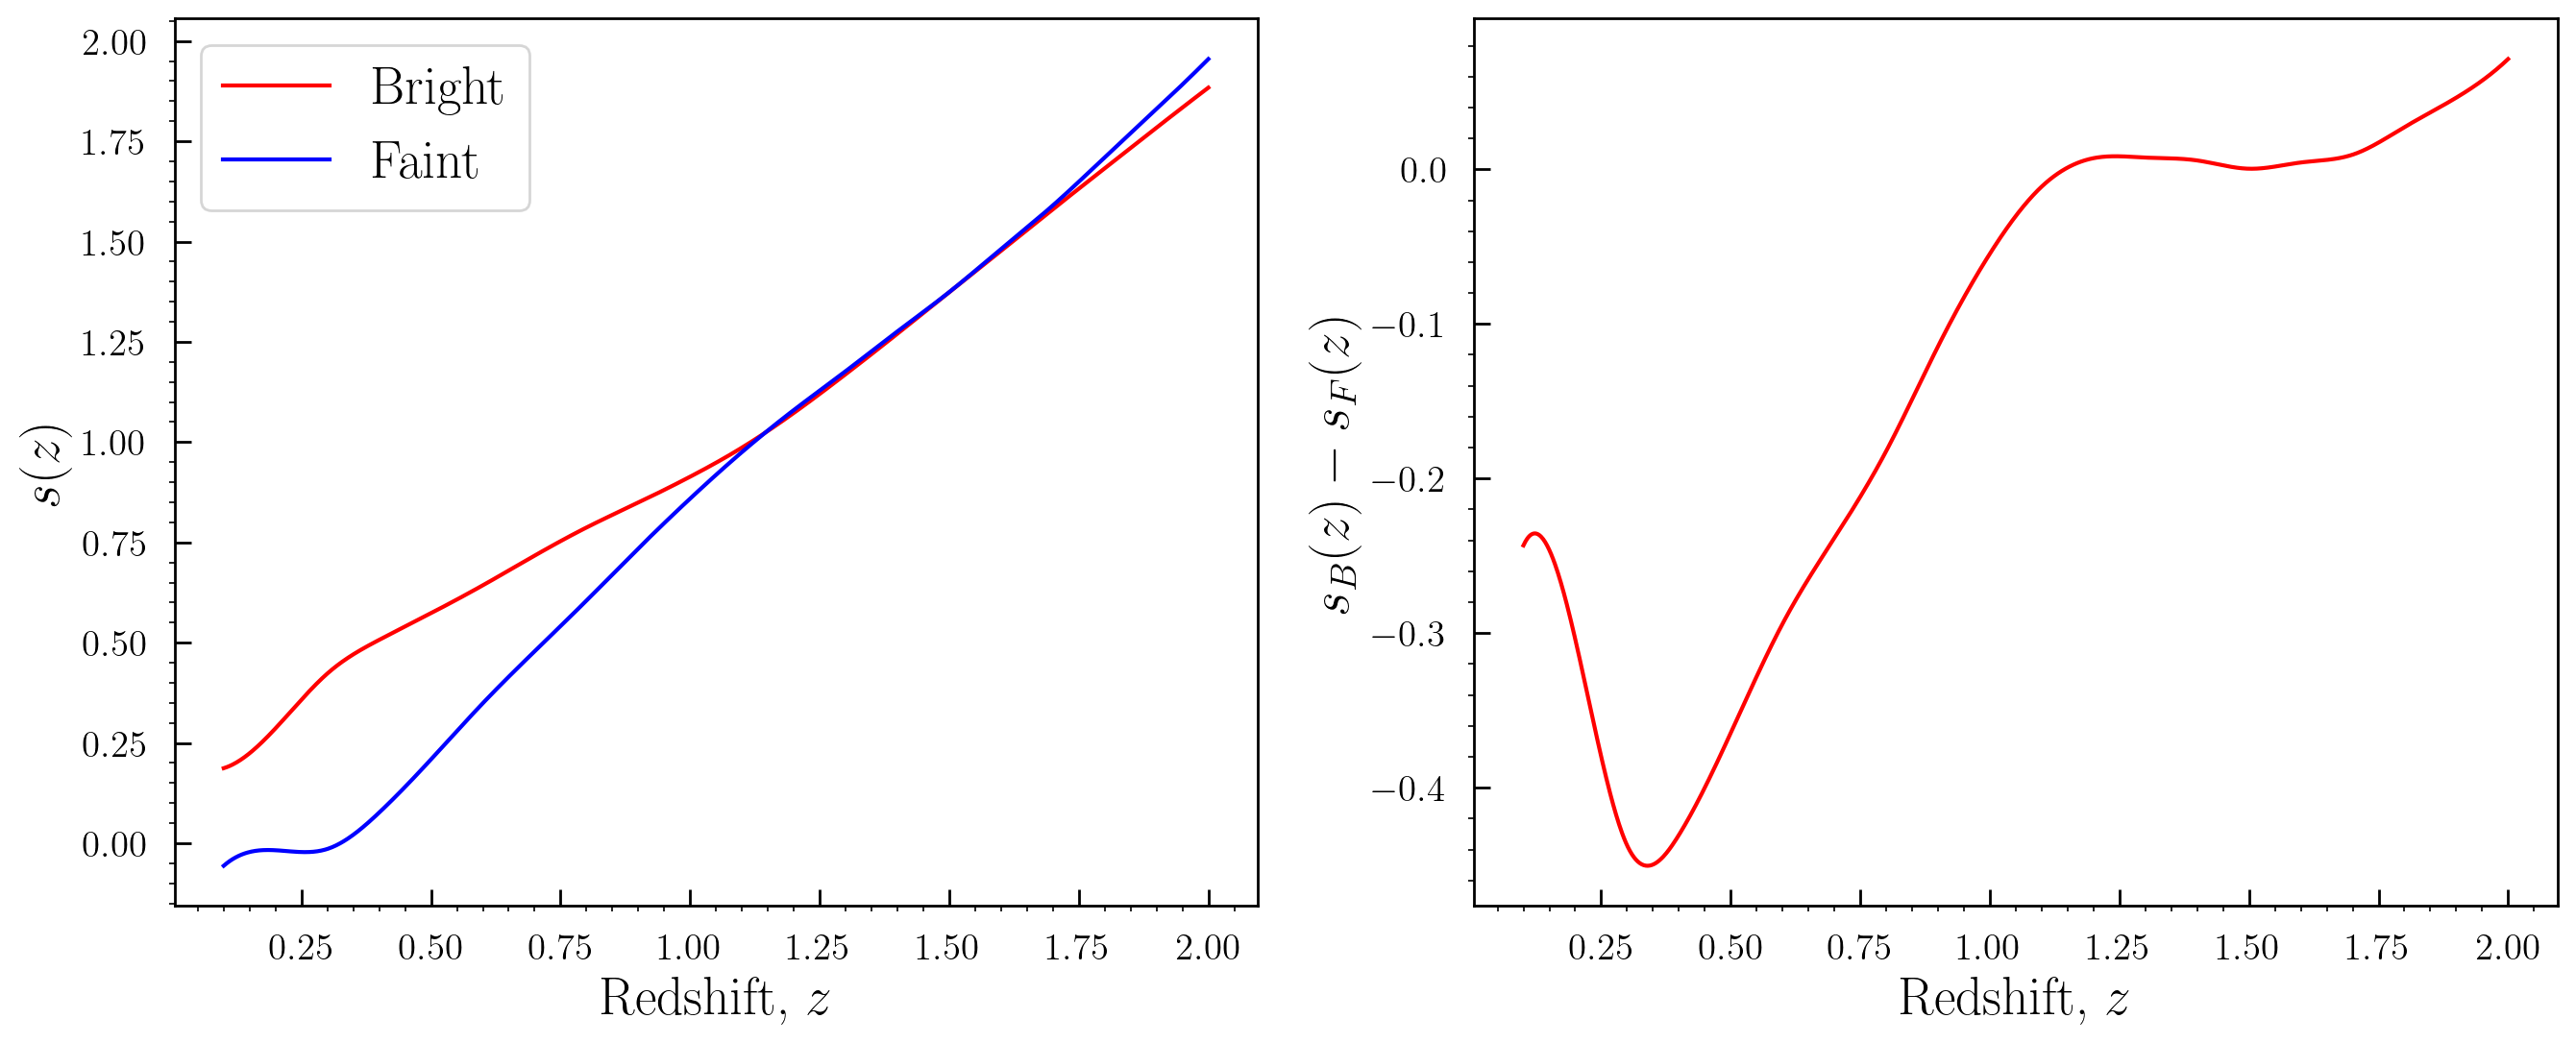

In [36]:
zs = np.linspace(0.1, 2.0, 1000)

sB = smodelB(zs)
sF = n_split * smodelF(zs) - smodelB(zs)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zs, sB, color = 'r', label = 'Bright')
ax[0].plot(zs, sF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$s(z)$');
ax[0].legend();

ax[1].plot(zs, sF-sB, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{B}(z)-s_{F}(z)$');
ax[1].set_ylim();

## Evolution bias

We want to calculate the evolution bias for the two populations of galaxies. We follow [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401), where

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{(1+z)}} + 2\,\frac{(1+z)}{r\,H} - 2\,\left(1+\frac{1+z}{r\,H}\right)\,\mathcal{Q}$$

Where after splitting the populations, we should use $N_\mathrm{g}$ and $\mathcal{Q}$ of each population. 

In [37]:
# Define the contributions which do not depend on the population

from scipy.integrate import quad

def r_(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c # Mpc^{-1} units
    Oml = 1-Om
    # Comoving distance
    result = quad(lambda x: 1/(H0*np.sqrt(Om * (1+x)**3 + Oml)), 0, z)
    value=result[0]
    return np.array(value)

r=np.vectorize(r_)

def H(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c
    H = H0 * np.sqrt(Om*(1+np.array(z))**3 + (1-Om))
    return H
    
def dlogH_f(z, Om=0.3111, h=0.677):
    z = np.array(z)
    c = 299792.458
    H0 = 100*h/c
    derivative = H0**2/2 * (3*Om*(1+z)**2) / (H(z)**2)
    return derivative

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

In [38]:
# Term that depends on Q = (5/2) * s_model

Q_bright = 5/2 * smodelB(zSKA)
Q_faint = 5/2 * smodelF(zSKA)

QtermB = 2 * (1 + rHterm) * Q_bright
QtermF = 2 * (1 + rHterm) * Q_faint

### Derivative of N_g with respect to z (using interpolation of C's wrt to Sc)

In [39]:
Ncut=10

Sc_data = Srms_fitz(z_data) * Ncut/10

def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

def dlogN_dz(z, Sc):
    res = (1+z)* (stencil_derivative(c1_int, x=Sc)*stencil_derivative(Sc_z, x=z)*np.log(10) 
                        + (stencil_derivative(c2_int, x=Sc)*stencil_derivative(Sc_z, x=z)*np.log(z) + c2_int(Sc_z(z))/z) 
                        - (stencil_derivative(c3_int, x=Sc)*stencil_derivative(Sc_z, x=z)*z + c3_int(Sc_z(z))))
    return res 

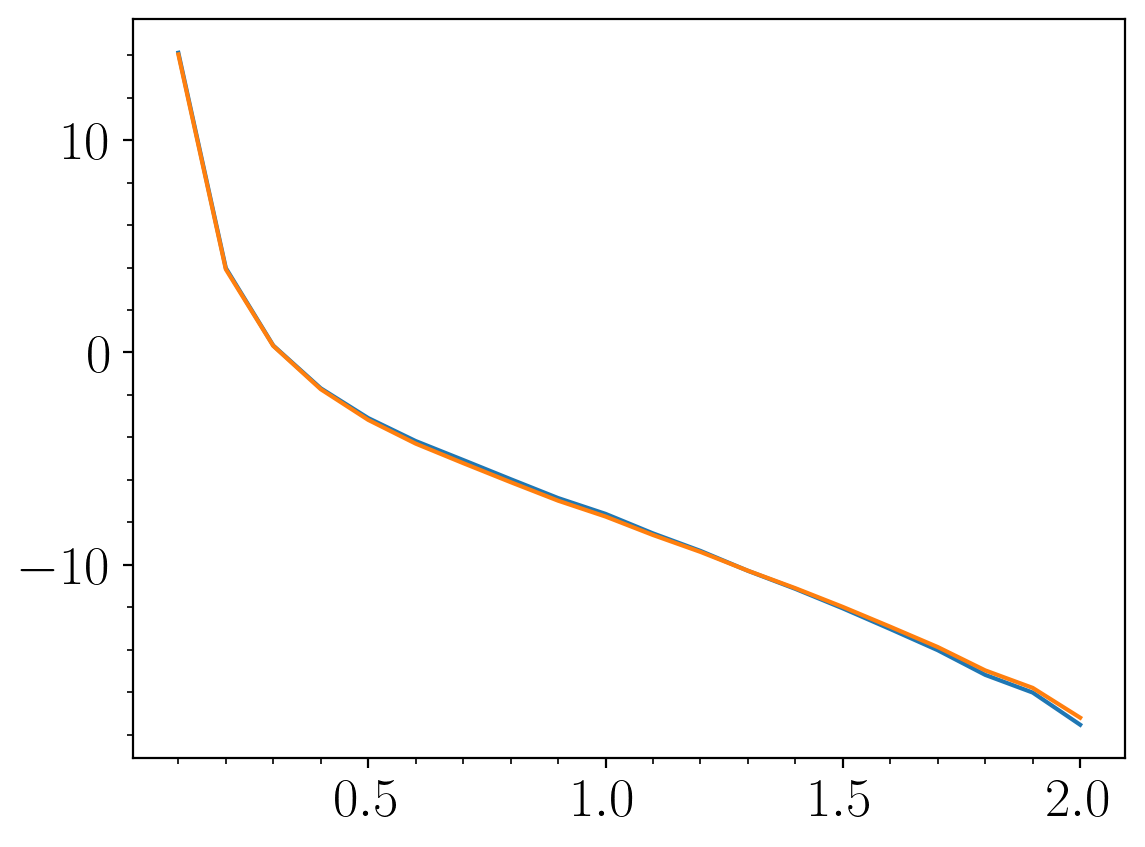

In [40]:
plt.plot(z_data, dlogN_dz(z_data, Sc_data))
plt.plot(z_data, dlogN_dz(z_data, Sc_bright))

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{1+z}} + 2\,\frac{(1+z)}{r\,H} - 2\,\left(1+\frac{1+z}{r\,H}\right)\,\mathcal{Q}$$


In [41]:
# Evolution biases

dlogH = (1+z_data) * dlogH_f(z_data)
dlogNB_dz = dlogN_dz(z_data, Sc_bright)
dlogNF_dz = dlogN_dz(z_data, Sc_data) 
rHterm = (1+z_data)/(r(z_data)*H(z_data))

Q_bright = Qmodel(z_data, Sc_bright)
Q_faint = Qmodel(z_data, Sc_data)

QtermB = 2 * (1 + rHterm) * Q_bright
QtermF = 2 * (1 + rHterm) * Q_faint


fBright = - dlogNB_dz - dlogH + 2 * rHterm - QtermB
fFaint = - dlogNF_dz - dlogH + 2 * rHterm - QtermF

fBright_ = interp1d(z_data, fBright, kind='cubic', fill_value='extrapolate')
fFaint_ = interp1d(z_data, fFaint, kind='cubic', fill_value='extrapolate')

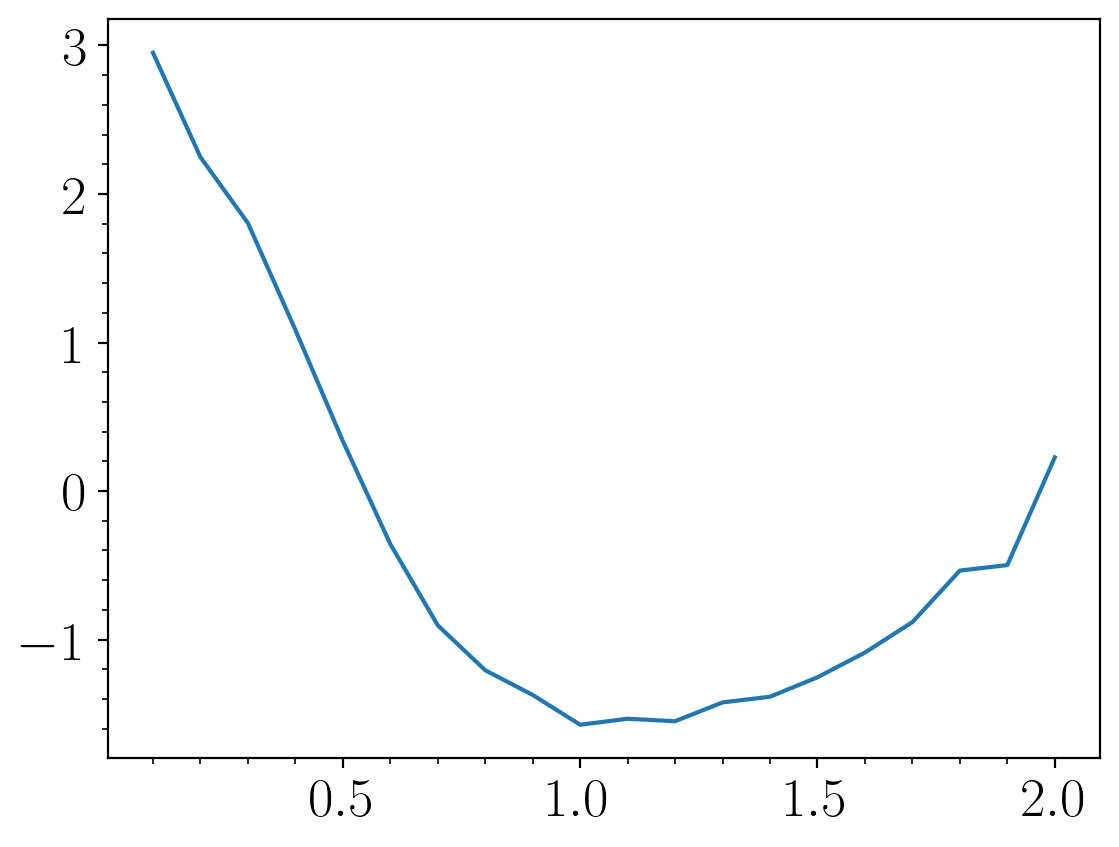

In [42]:
# Check be in R. Maartens et a.l. (2022)

Qterm = 2*(1+rHterm)*Qmodel(z_data, Sc_data)

fevol = - dlogN_dz(z_data, Sc_data) - dlogH + 2 * rHterm - Qterm

plt.plot(z_data, fevol)

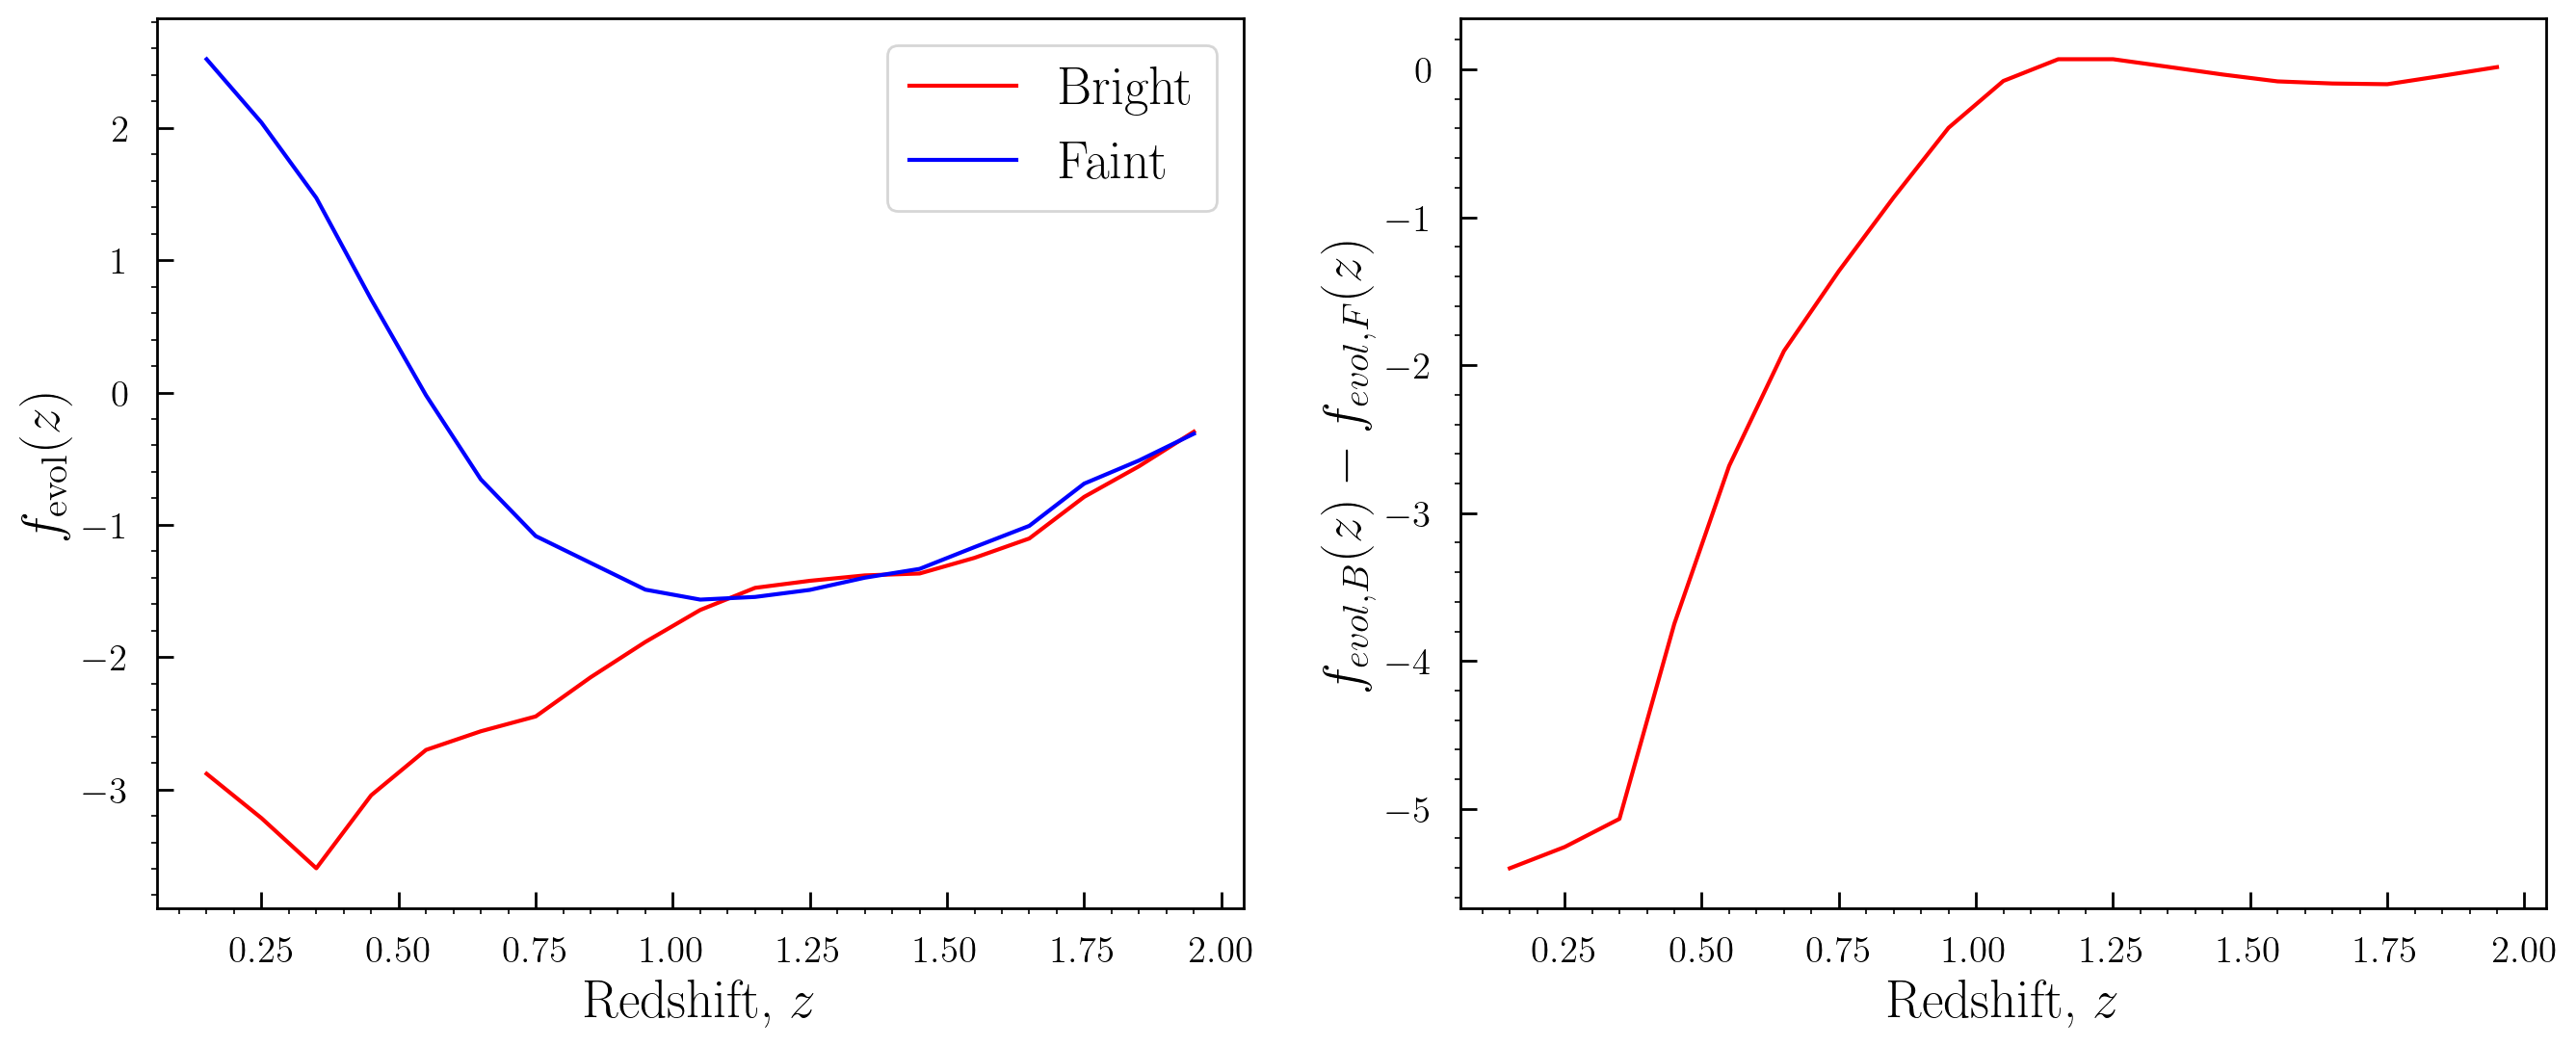

In [43]:
z_analysis = np.linspace(0.15, 1.95, 19)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(z_analysis, fBright_(z_analysis), color = 'r', label = 'Bright')
ax[0].plot(z_analysis, fFaint_(z_analysis), color = 'b', label = 'Faint')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{\mathrm{evol}}(z)$');
ax[0].legend();

ax[1].plot(z_analysis, fBright_(z_analysis) - fFaint_(z_analysis), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

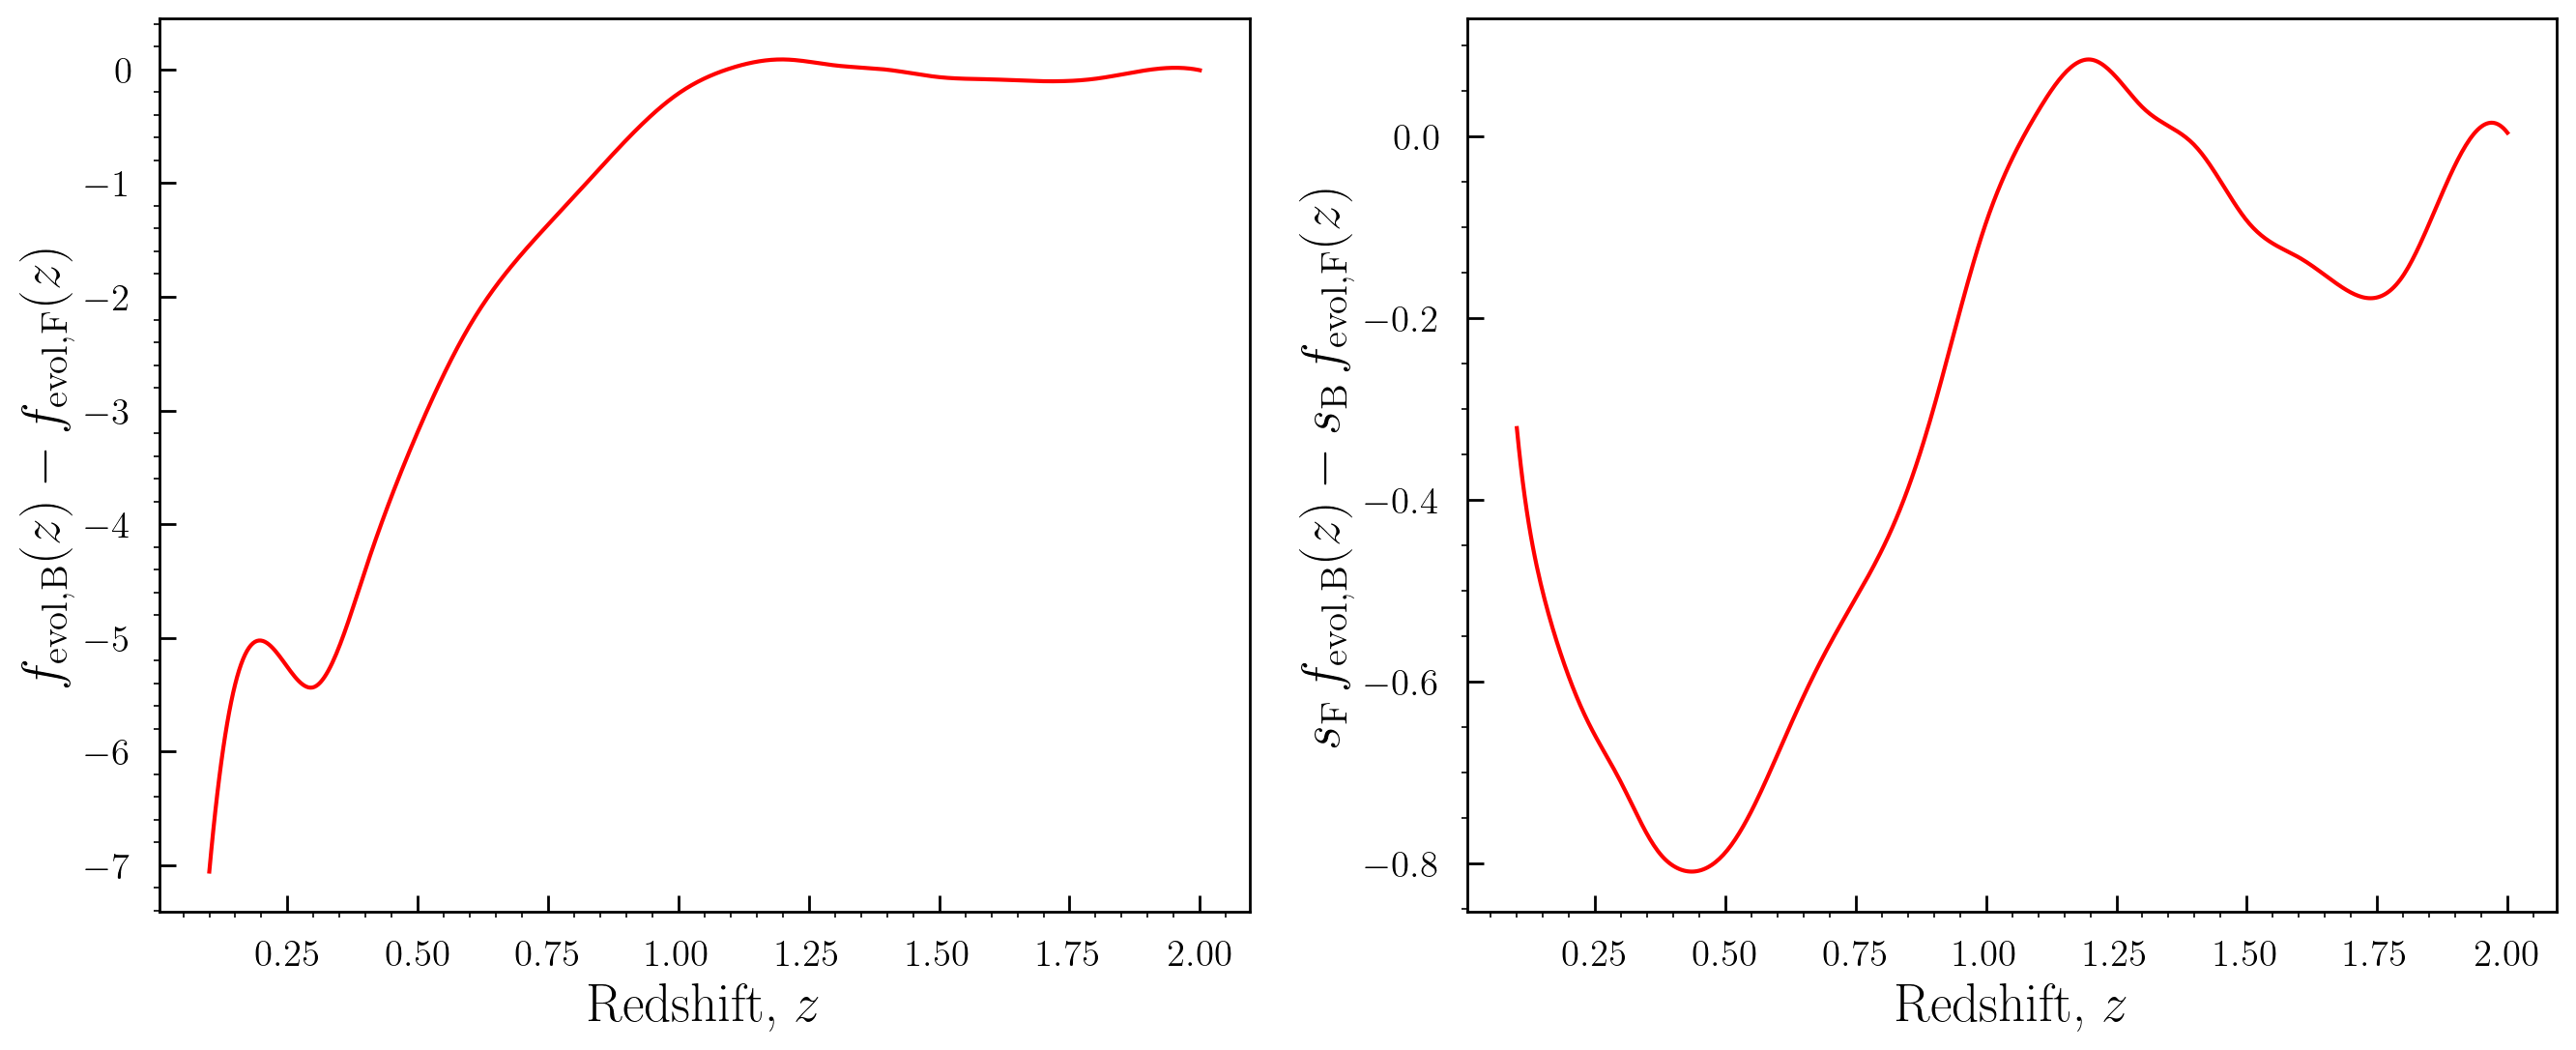

In [44]:
# Plot the different contributions to the dipole

zSKA = np.linspace(0.1, 2.0, 500)

sBright = smodelB(zSKA)
sFaint = n_split * smodelF(zSKA) - smodelB(zSKA)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fBright_(zSKA) - fFaint_(zSKA), color = 'r')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_\mathrm{evol, B}(z)-f_\mathrm{evol, F}(z)$');

ax[1].plot(zSKA, sFaint*fBright_(zSKA) - sBright*fFaint_(zSKA), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{\mathrm{F}}\,f_\mathrm{evol, B}(z)-s_{\mathrm{B}}\,f_\mathrm{evol, F}(z)$');
ax[1].set_ylim();

### Derivative of N_g with respect to z (using interpolation of C's wrt to z)

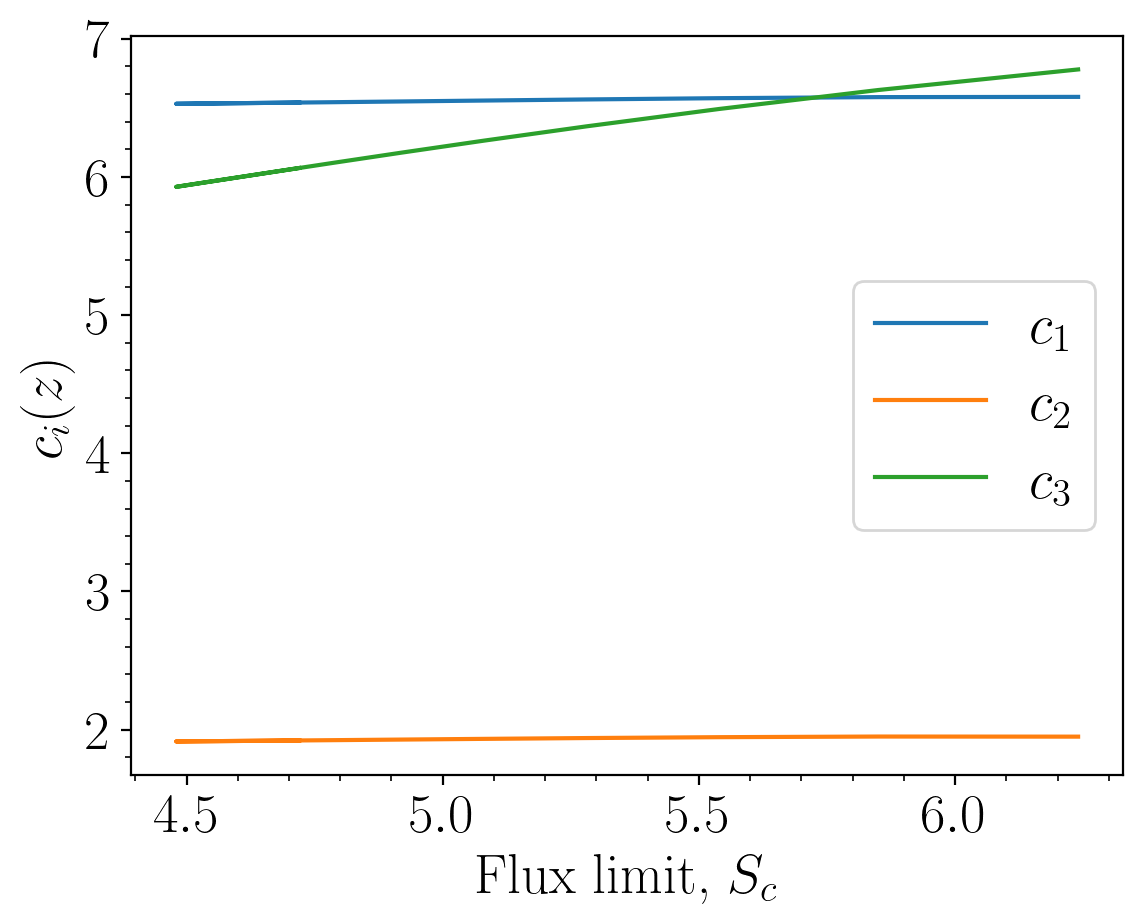

In [45]:
# C coefficients per population

plt.plot(Sc_data, c1_int(Sc_data), label=r'$c_1$')
plt.plot(Sc_data, c2_int(Sc_data), label=r'$c_2$')
plt.plot(Sc_data, c3_int(Sc_data), label=r'$c_3$')
plt.xlabel(r'Flux limit, $S_c$')
plt.ylabel(r'$c_i(z)$')
plt.legend();

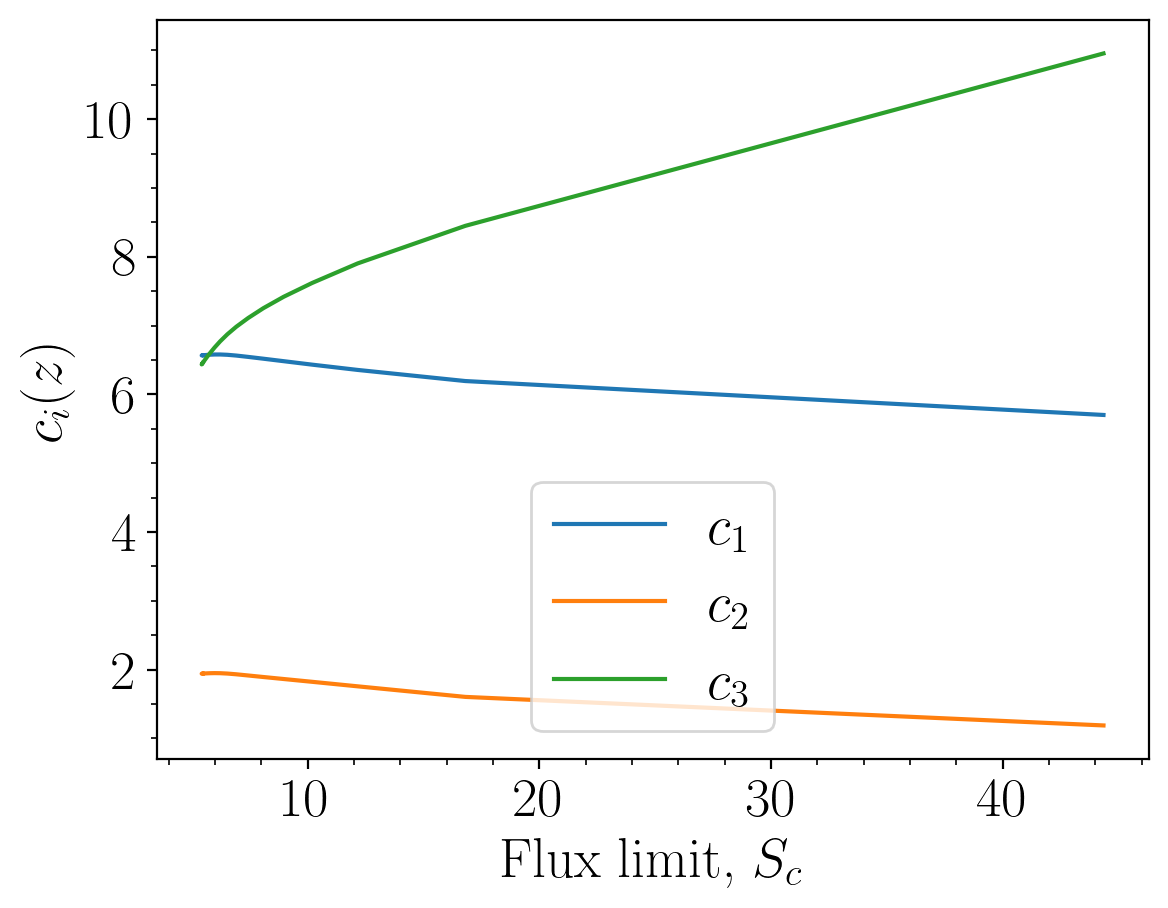

In [46]:
# C coefficients per population

plt.plot(Sc_bright, c1_int(Sc_bright), label=r'$c_1$')
plt.plot(Sc_bright, c2_int(Sc_bright), label=r'$c_2$')
plt.plot(Sc_bright, c3_int(Sc_bright), label=r'$c_3$')
plt.xlabel(r'Flux limit, $S_c$')
plt.ylabel(r'$c_i(z)$')
plt.legend();

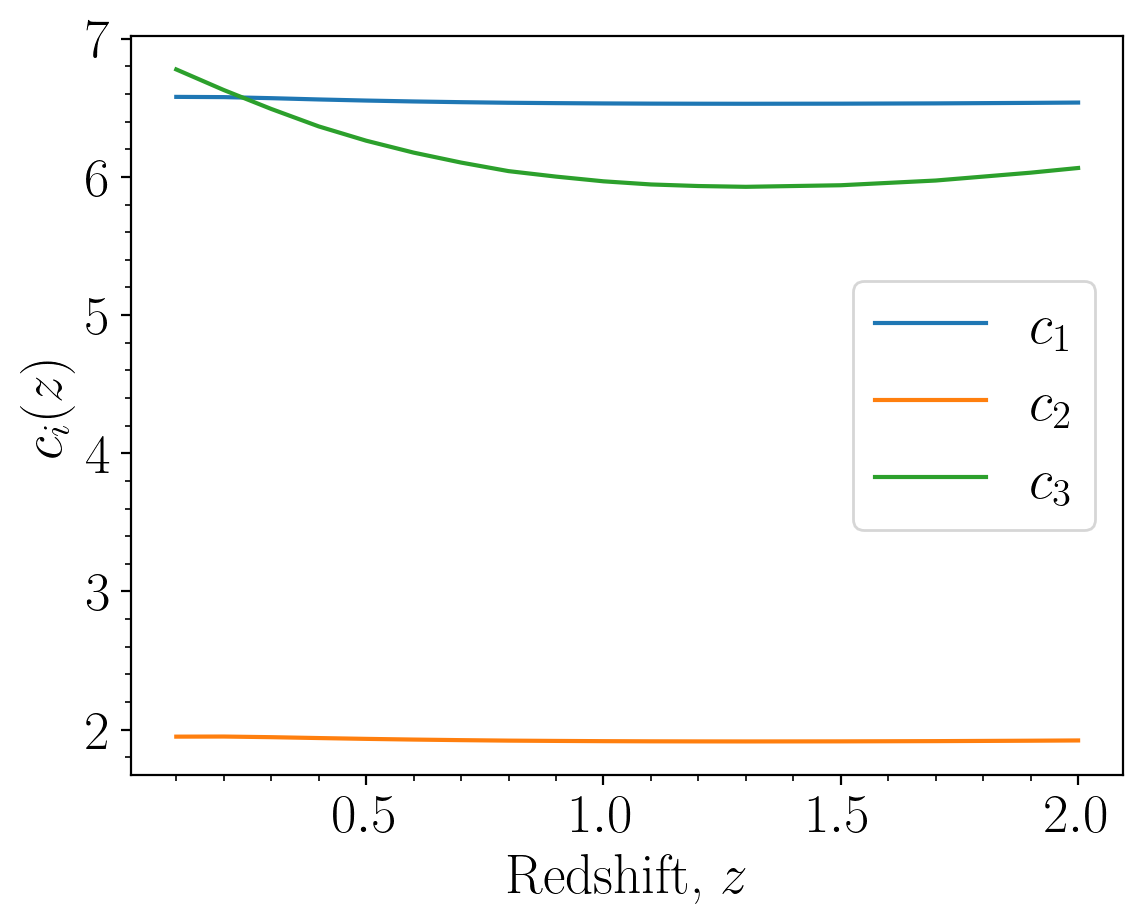

In [47]:
# Derivative of N_g(z, Sc) with respect to z (log(1+z))

# First study the redshift dependence of the c's
 
Ncut=10
Sc_data = Srms_fitz(z_data) * Ncut/10

def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

plt.plot(z_data, c1_int(Sc_z(z_data)), label=r'$c_1$')
plt.plot(z_data, c2_int(Sc_z(z_data)), label=r'$c_2$')
plt.plot(z_data, c3_int(Sc_z(z_data)), label=r'$c_3$')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$c_i(z)$')
plt.legend();

In [48]:
c1_int_z = interp1d(z_data, c1_int(Sc_z(z_data)), kind='cubic', fill_value='extrapolate')
c2_int_z = interp1d(z_data, c2_int(Sc_z(z_data)), kind='cubic', fill_value='extrapolate') 
c3_int_z = interp1d(z_data, c3_int(Sc_z(z_data)), kind='cubic', fill_value='extrapolate')

c1_bright_z = interp1d(z_data, c1_int(Sc_bright), kind='cubic', fill_value='extrapolate')
c2_bright_z = interp1d(z_data, c2_int(Sc_bright), kind='cubic', fill_value='extrapolate')
c3_bright_z = interp1d(z_data, c3_int(Sc_bright), kind='cubic', fill_value='extrapolate')

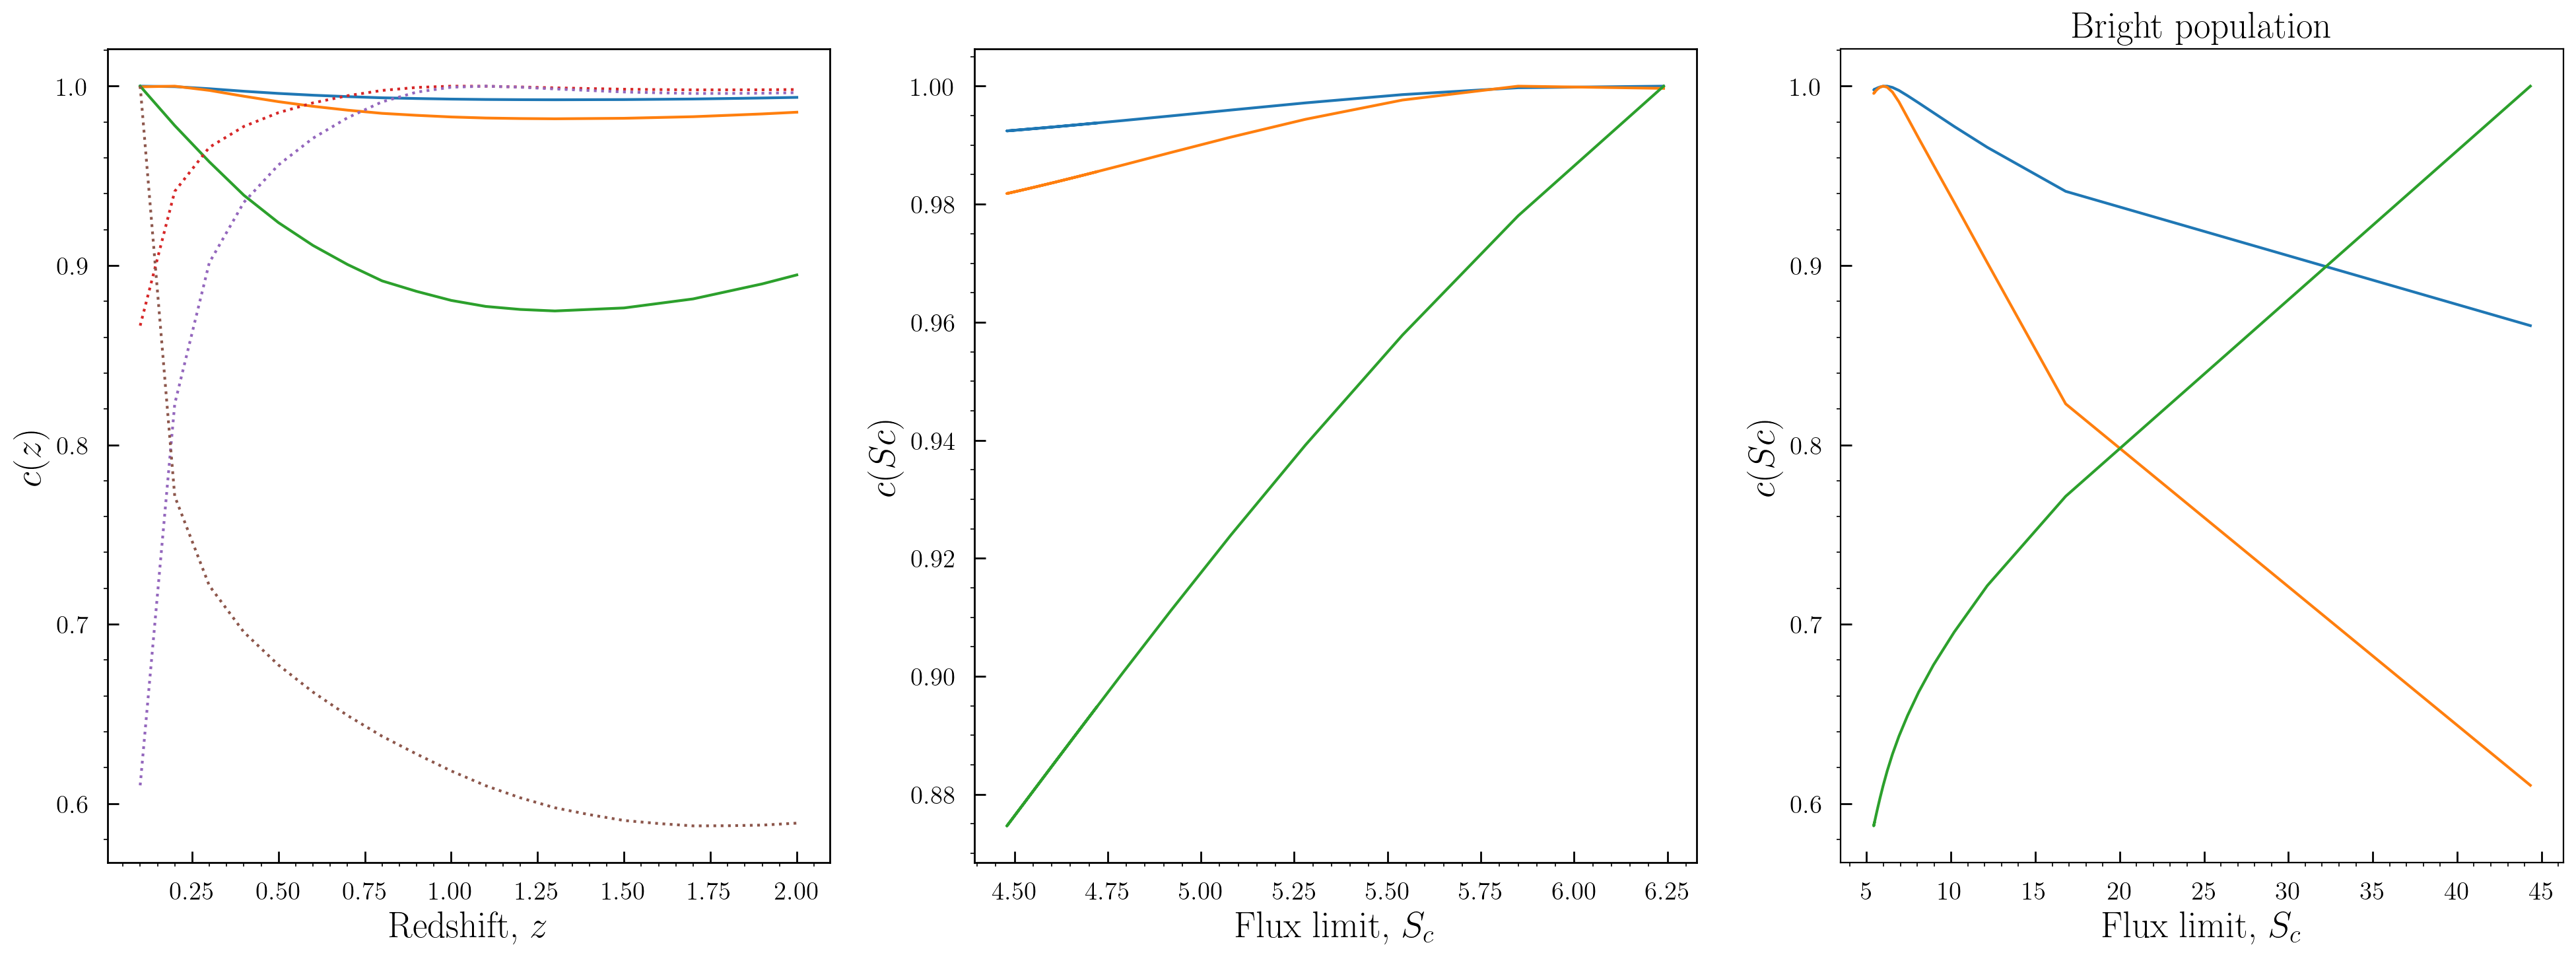

In [49]:
fig, ax = plt.subplots(1, 3, figsize = (24,8))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(z_data, c1_int_z(z_data)/np.max(c1_int_z(z_data)))
ax[0].plot(z_data, c2_int_z(z_data)/np.max(c2_int_z(z_data)))
ax[0].plot(z_data, c3_int_z(z_data)/np.max(c3_int_z(z_data)))
ax[0].plot(z_data, c1_bright_z(z_data)/np.max(c1_bright_z(z_data)), ':')
ax[0].plot(z_data, c2_bright_z(z_data)/np.max(c2_bright_z(z_data)), ':')
ax[0].plot(z_data, c3_bright_z(z_data)/np.max(c3_bright_z(z_data)), ':')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$c(z)$');

ax[1].plot(Sc_data, c1_int(Sc_data)/np.max(c1_int(Sc_data)))
ax[1].plot(Sc_data, c2_int(Sc_data)/np.max(c2_int(Sc_data)))
ax[1].plot(Sc_data, c3_int(Sc_data)/np.max(c3_int(Sc_data)))


ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Flux limit, $S_c$');
ax[1].set_ylabel(r'$c(Sc)$');
ax[1].set_ylim();

ax[2].plot(Sc_bright, c1_int(Sc_bright)/np.max(c1_int(Sc_bright)))
ax[2].plot(Sc_bright, c2_int(Sc_bright)/np.max(c2_int(Sc_bright)))
ax[2].plot(Sc_bright, c3_int(Sc_bright)/np.max(c3_int(Sc_bright)))
ax[2].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[2].set_title('Bright population')
ax[2].set_xlabel(r'Flux limit, $S_c$');
ax[2].set_ylabel(r'$c(Sc)$');
ax[2].set_ylim();

In [50]:
# Derivative of Log N_g(z, Sc) with respect to redshift

def dlogN_dz_(z):
    return (1+z)*(stencil_derivative(c1_int_z, x=z)*np.log(10) + (stencil_derivative(c2_int_z, x=z)*np.log(z) + c2_int_z(z)/z) - (stencil_derivative(c3_int_z, x=z)*z + c3_int_z(z)))

def dlogN_dz_bright(z):
    return (1+z)*(stencil_derivative(c1_bright_z, x=z)*np.log(10) + (stencil_derivative(c2_bright_z, x=z)*np.log(z) + c2_bright_z(z)/z) - (stencil_derivative(c3_bright_z, x=z)*z + c3_bright_z(z)))
   

Text(0, 0.5, '$d\\log{N_g}/d\\log{(1+z)}$')

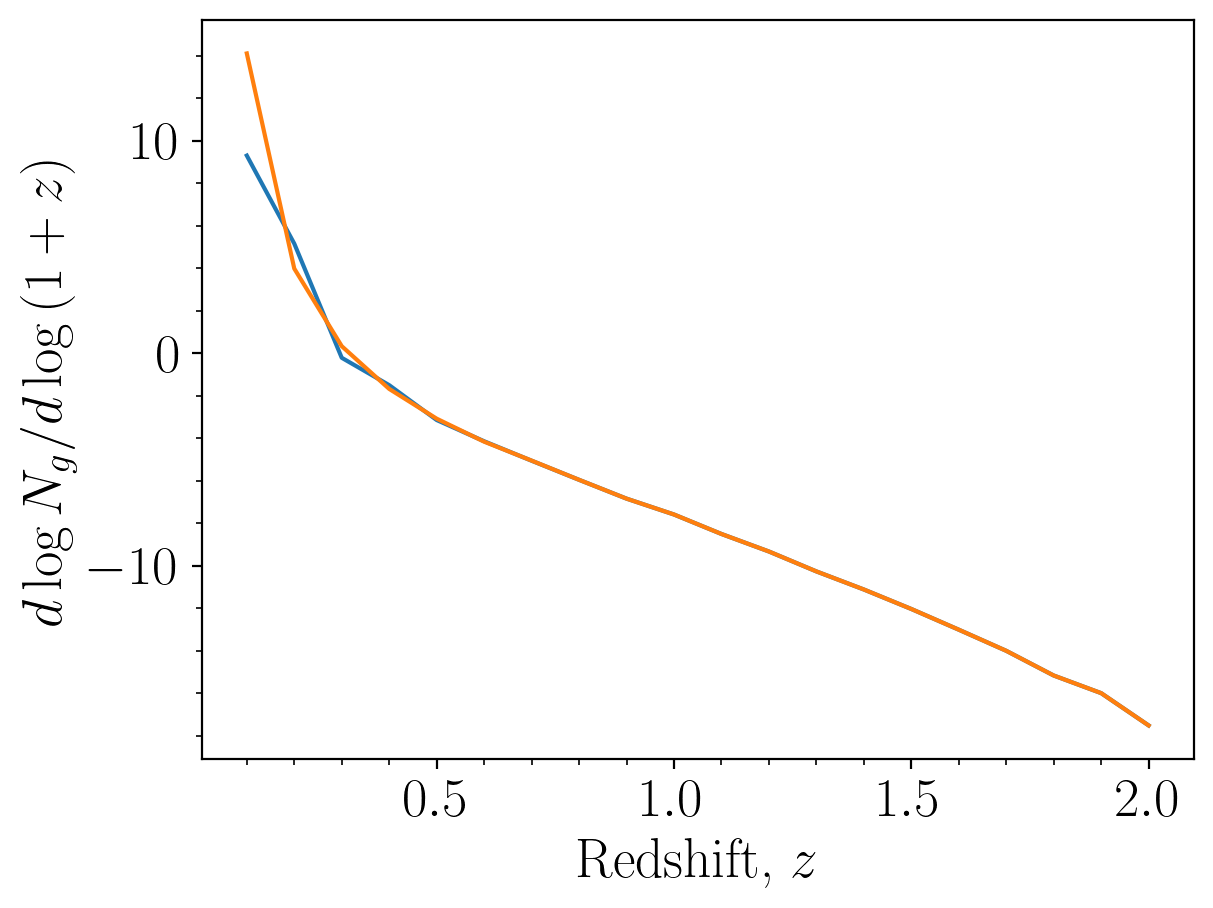

In [51]:
plt.plot(z_data, dlogN_dz_bright(z_data))
plt.plot(z_data, dlogN_dz_(z_data))

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N_g}/d\log{(1+z)}$')

In [52]:
# Evolution biases

dlogH = (1+z_data) * dlogH_f(z_data)
dlogNB_dz = dlogN_dz_bright(z_data)
dlogNF_dz = dlogN_dz_(z_data) 
rHterm = (1+z_data)/(r(z_data)*H(z_data))

Q_bright = 5/2 * smodelB(z_data)
Q_faint = 5/2 * (n_split * smodelF(z_data) - smodelB(z_data))

QtermB = 2 * (1 + rHterm) * Q_bright
QtermF = 2 * (1 + rHterm) * Q_faint


fBright = - dlogNB_dz - dlogH + 2 * rHterm - QtermB
fFaint = - dlogNF_dz - dlogH + 2 * rHterm - QtermF

fBright_ = interp1d(z_data, fBright, kind='cubic', fill_value='extrapolate')
fFaint_ = interp1d(z_data, fFaint, kind='cubic', fill_value='extrapolate')

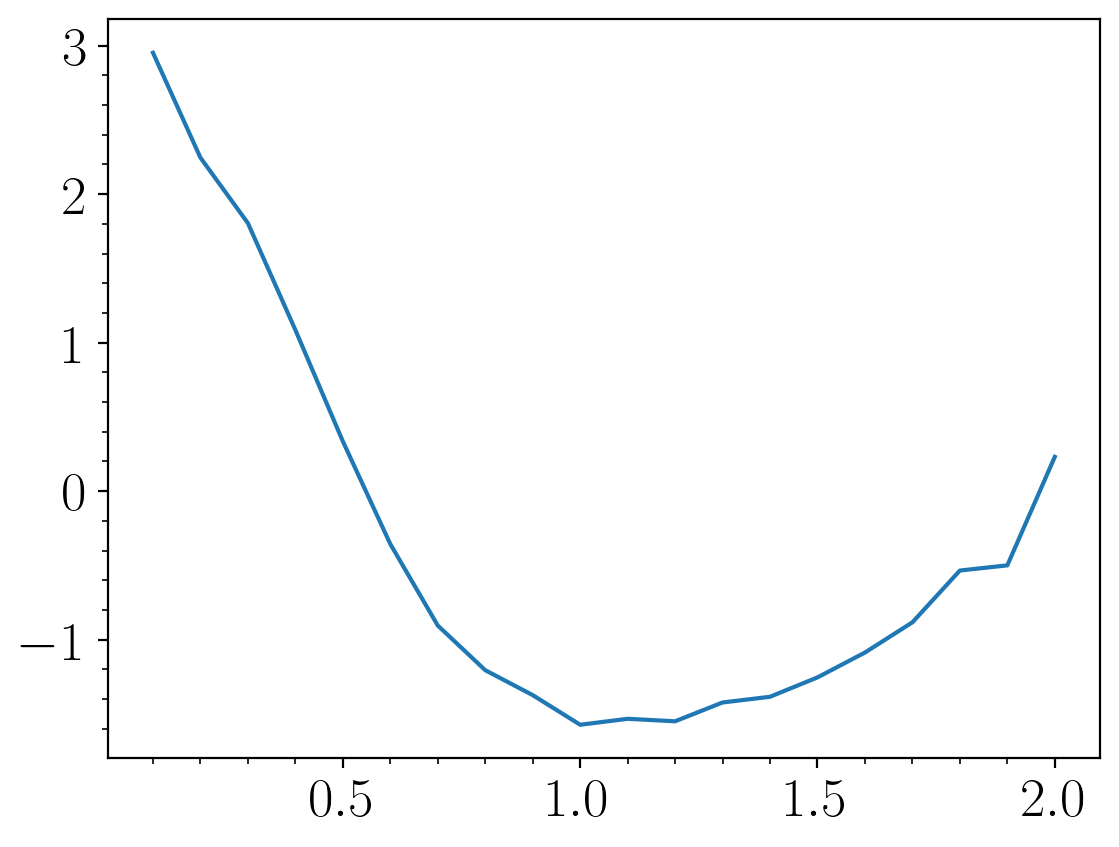

In [53]:
# Check be in R. Maartens et a.l. (2022)

Qterm = 2*(1+rHterm)* Qmodel(z_data, Sc_data)

fevol = - dlogN_dz_(z_data) - dlogH + 2 * rHterm - Qterm

plt.plot(z_data, fevol)

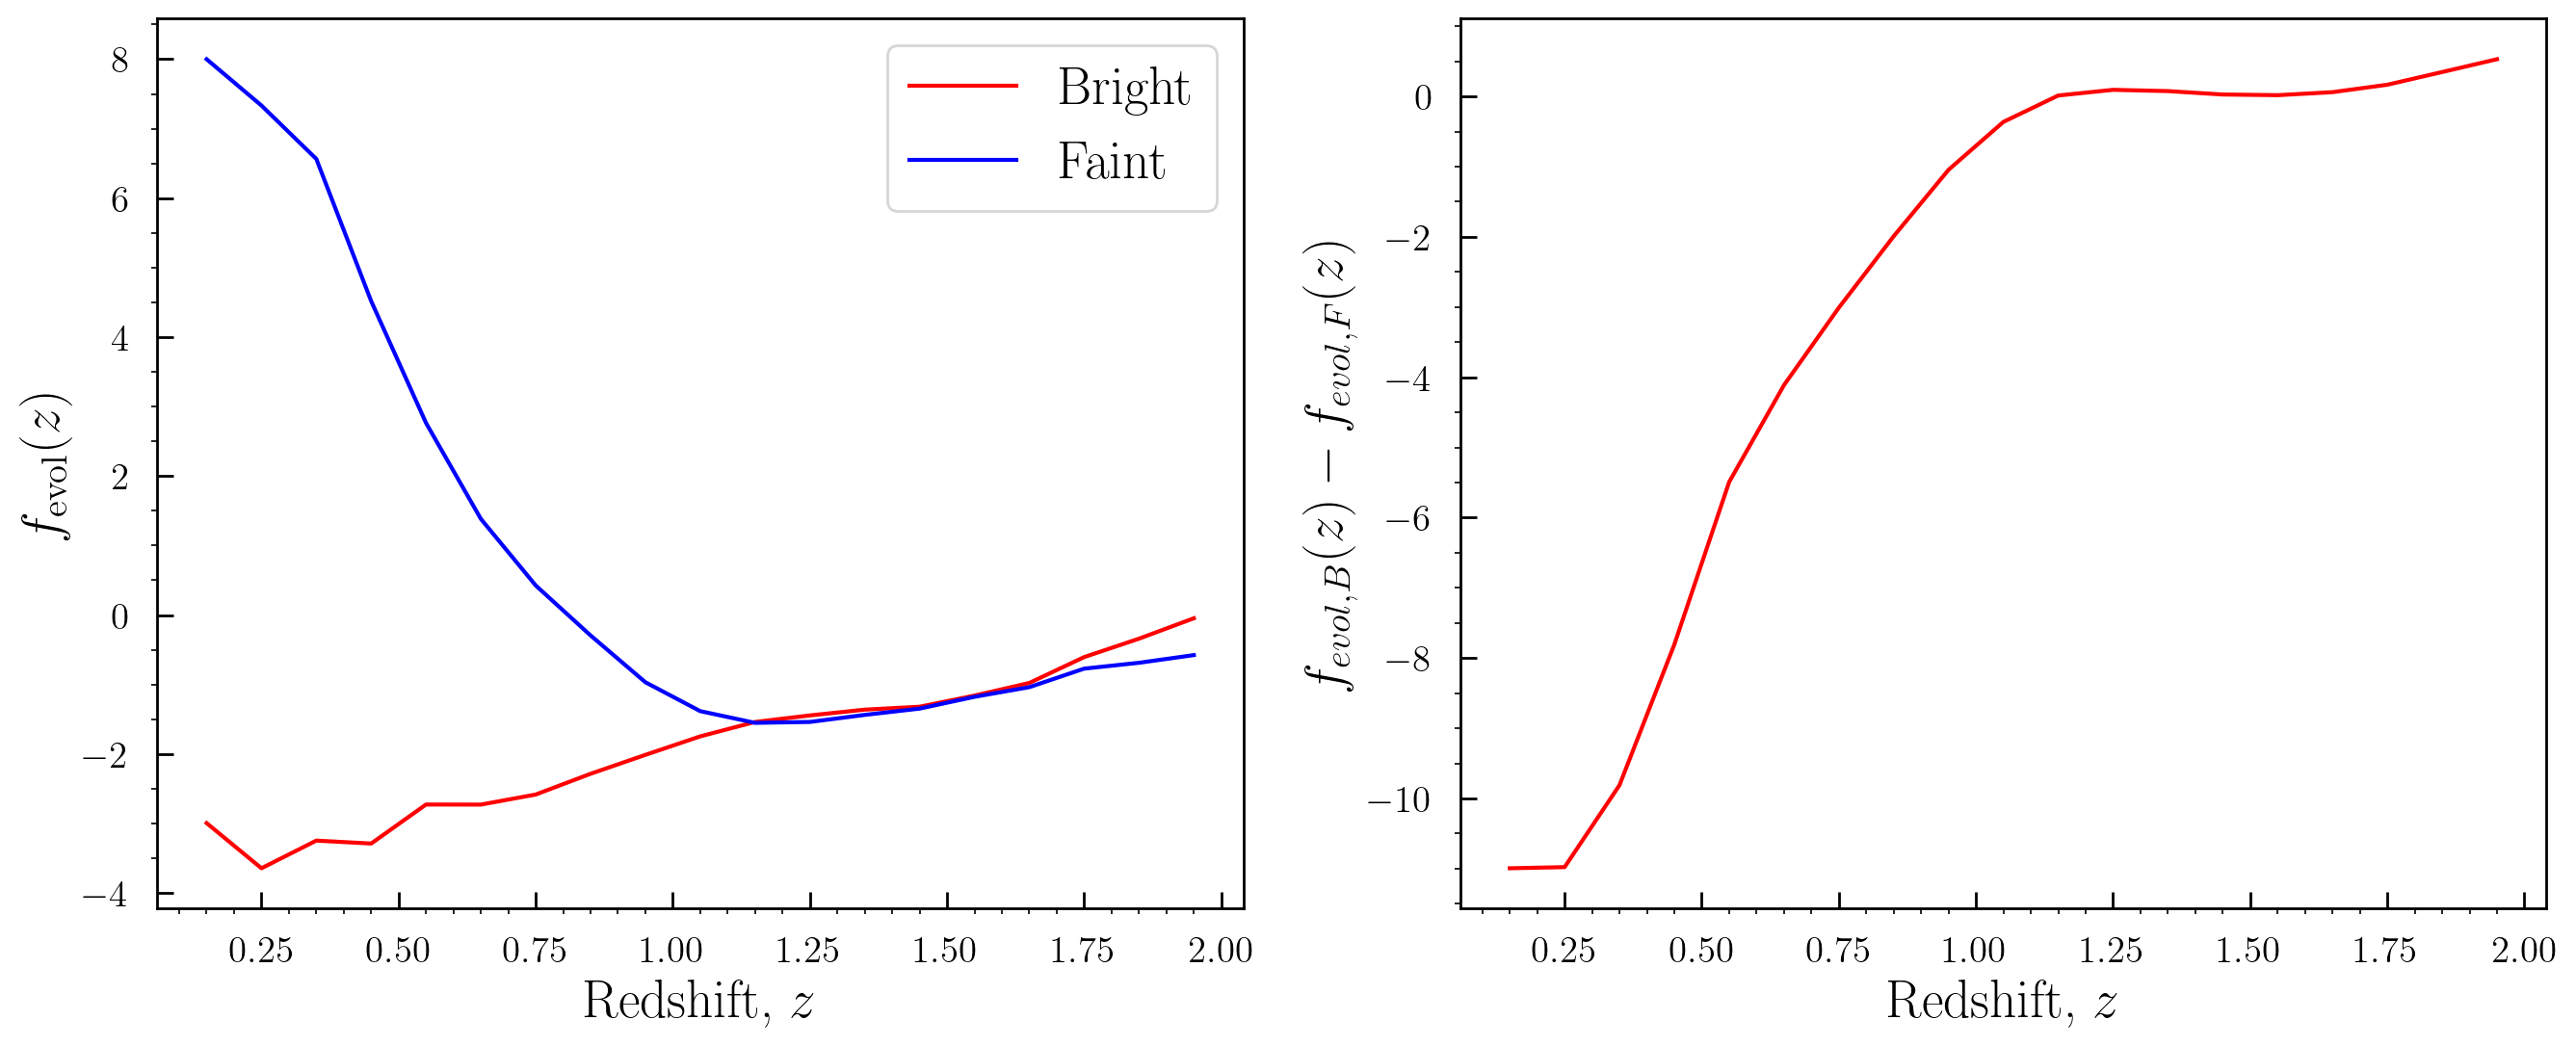

In [54]:
z_analysis = np.linspace(0.15, 1.95, 19)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(z_analysis, fBright_(z_analysis), color = 'r', label = 'Bright')
ax[0].plot(z_analysis, fFaint_(z_analysis), color = 'b', label = 'Faint')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{\mathrm{evol}}(z)$');
ax[0].legend();

ax[1].plot(z_analysis, fBright_(z_analysis) - fFaint_(z_analysis), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

### TOTAL Derivative of N_g with respect to z (using interpolation of C's wrt to z)

In [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401), where

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{1+z}} + 2\,\frac{(1+z)}{r\,H} - 2\,\left(1+\frac{1+z}{r\,H}\right)\,\mathcal{Q}$$

Where after splitting the populations, we should use $N_\mathrm{g}$ and $\mathcal{Q}$ of each population. The expression is written in terms of the total derivative. Given that we have a flux limit that depends on the redshift, $S_{\mathrm{c}}(z)$:

$$ \frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} = (1+z)\;\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{dz} = (1+z)\,\left[\frac{\partial\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{\partial z} + \frac{\partial\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{\partial S_{\mathrm{c}}}\,\frac{\partial S_{\mathrm{c}}}{\partial z}\right] ,$$

Using the parametrization given also in [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401) (and refs. therein), we have:

$$ \log{N_{\mathrm{g}}}(z,S_{\mathrm{c}}) = \log{10}\,c_1(S_{\mathrm{c}}(z)) + c_2(S_{\mathrm{c}}(z))\,\log{z} - c_3(S_{\mathrm{c}}(z))\,z .$$ 

For the first term in the total derivative, we can perform an intermediate interpolation of the fitting parameters, which depend implicitely on z through the flux limit. Hence, we can get $c_i(z)$. We can then use the Five-point-Stencil method. For the second term, we may use the interpolation with respect to the flux limits, so that $c_i(S_{\mathrm{c}})$. We also have the interpolated function for the flux limits as a function of redshift, $S_{\mathrm{c}}(z)$.

In [55]:
# Derivative of Log N_g(z, Sc) with respect to redshift

def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

Sc_z_bright = interp1d(z_data, Sc_bright, kind='cubic', fill_value = 'extrapolate')

def partial_dlogN_dz(z, pop='none'):
    if pop=='b':
        return (stencil_derivative(c1_bright_z, x=z)*np.log(10) + (stencil_derivative(c2_bright_z, x=z)*np.log(z) + c2_bright_z(z)/z) - (stencil_derivative(c3_bright_z, x=z)*z + c3_bright_z(z)))
    else:
        return (stencil_derivative(c1_int_z, x=z)*np.log(10) + (stencil_derivative(c2_int_z, x=z)*np.log(z) + c2_int_z(z)/z) - (stencil_derivative(c3_int_z, x=z)*z + c3_int_z(z)))

def partial_dlogN_dS(z, Sc):
    return Sc * (np.log(10)*stencil_derivative(c1_int, x=Sc) + stencil_derivative(c2_int, x=Sc)*np.log(z) - stencil_derivative(c3_int, x=Sc)*z)

def total_dlogN_dz(z, Sc, pop='none'):
    if pop=='b':
        return (1+z)*(partial_dlogN_dz(z, pop) + partial_dlogN_dS(z, Sc)*stencil_derivative(Sc_z_bright, x=z)/Sc)
    else:
        return (1+z)*(partial_dlogN_dz(z, pop) + partial_dlogN_dS(z, Sc)*stencil_derivative(Sc_z, x=z)/Sc)

Text(0, 0.5, '$d\\log{N_g}/dz$')

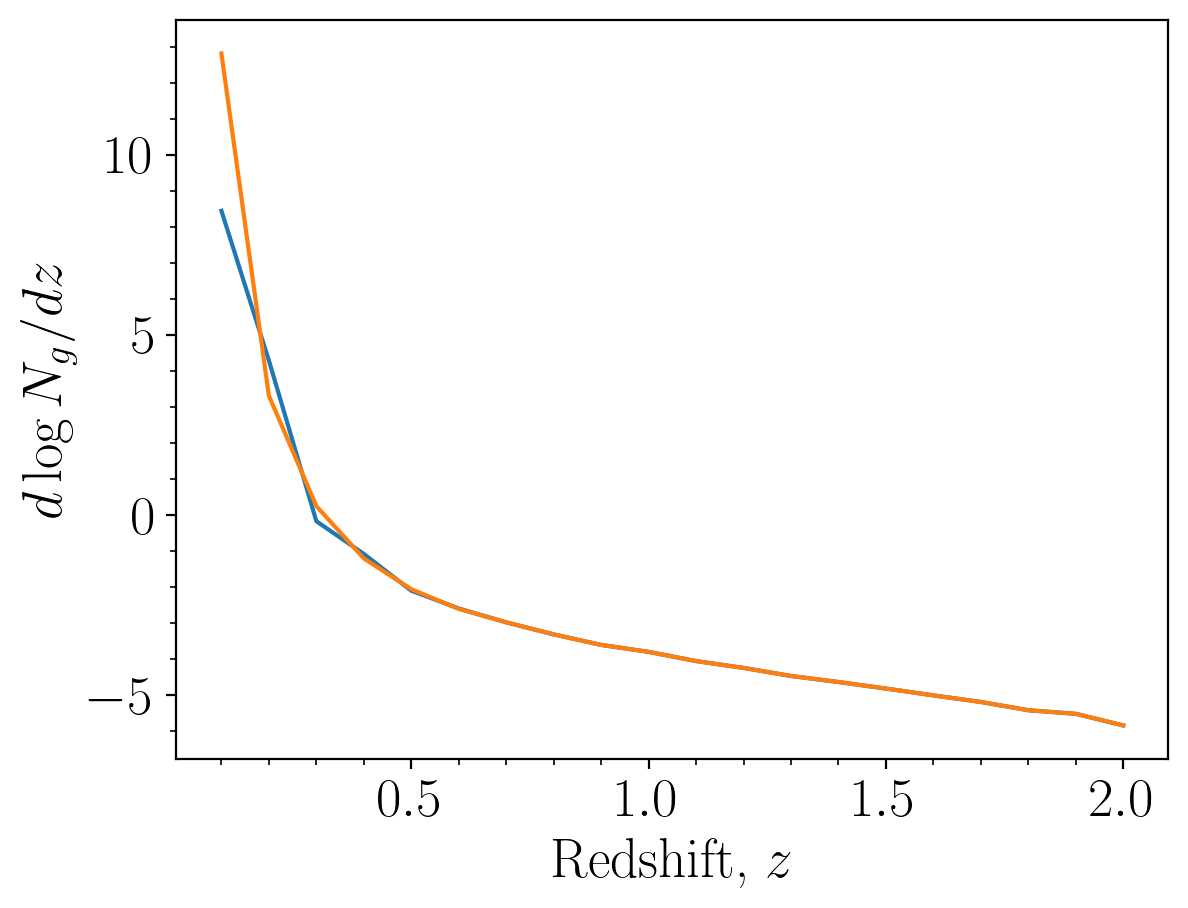

In [56]:
plt.plot(z_data, partial_dlogN_dz(z_data, pop='b'))
plt.plot(z_data, partial_dlogN_dz(z_data))

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N_g}/dz$')

Text(0, 0.5, '$d\\log{N_g}/dS_c$')

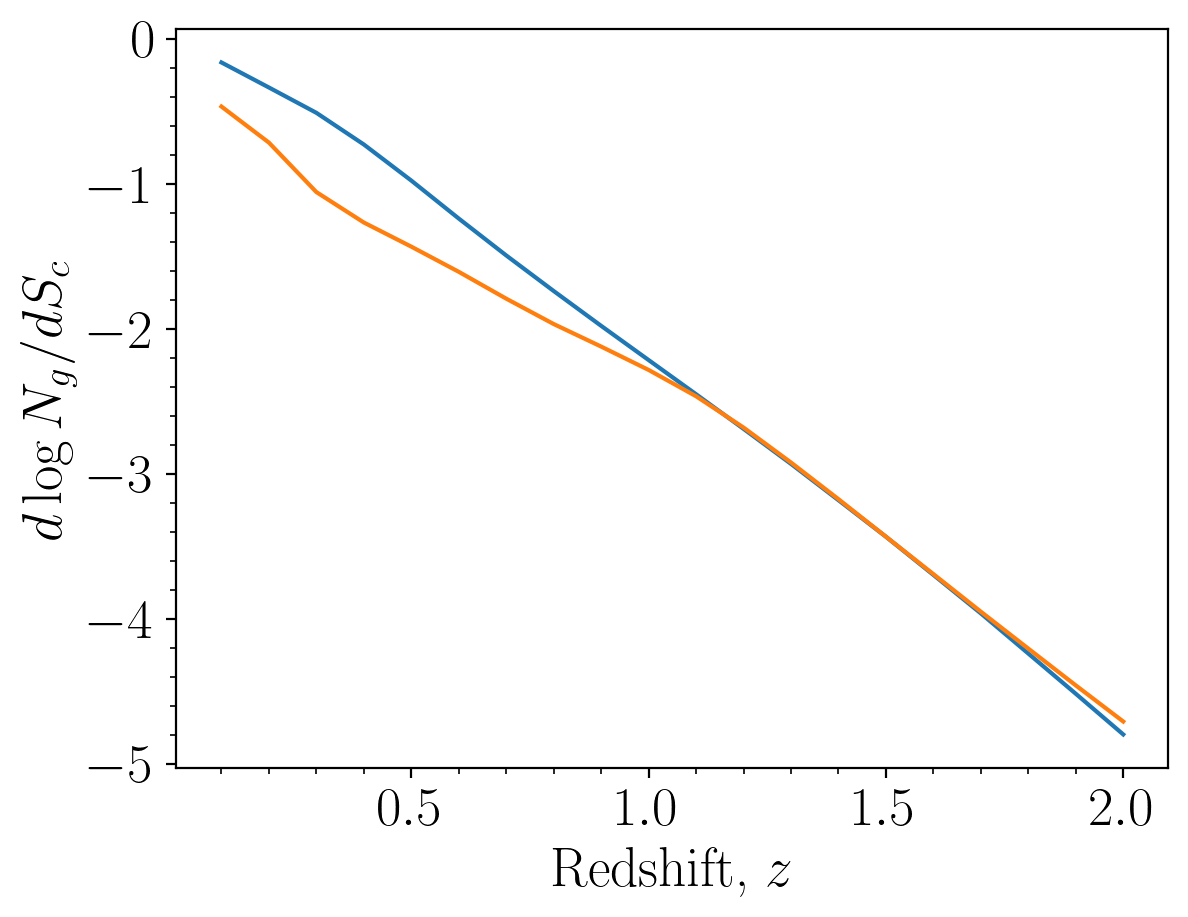

In [57]:
plt.plot(z_data, partial_dlogN_dS(z_data, Sc_data))
plt.plot(z_data, partial_dlogN_dS(z_data, Sc_bright))

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N_g}/dS_c$')

Text(0, 0.5, '$d\\log{N_g}/d\\log{(1+z)}$')

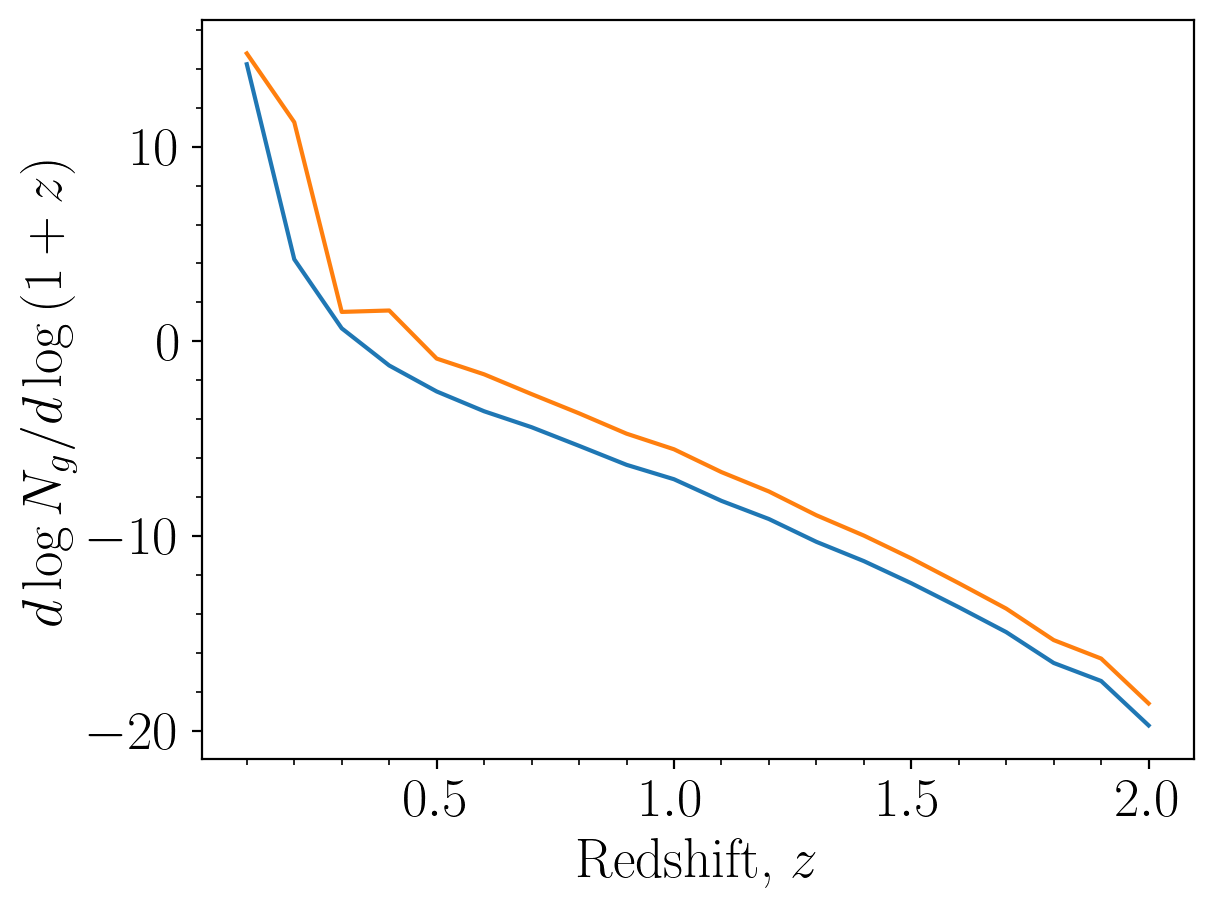

In [58]:
plt.plot(z_data, total_dlogN_dz(z_data, Sc_data))
plt.plot(z_data, total_dlogN_dz(z_data, Sc_bright, pop='b'))

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N_g}/d\log{(1+z)}$')

In [59]:
# Evolution biases

dlogH = (1+z_data)/H(z_data) * stencil_derivative(H, z_data, h=0.0001)
dlogNB_dz = total_dlogN_dz(z_data, Sc_bright, pop='b')
dlogNF_dz = total_dlogN_dz(z_data, Sc_data) 
rHterm = (1+z_data)/(r(z_data)*H(z_data))

Q_bright = 5/2 * smodelB(z_data)
Q_faint = 5/2 * (n_split * smodelF(z_data) - smodelB(z_data))

QtermB = 2 * (1 + rHterm) * Q_bright
QtermF = 2 * (1 + rHterm) * Q_faint

fBright = - dlogNB_dz - dlogH + 2 * rHterm - QtermB
fFaint = - dlogNF_dz - dlogH + 2 * rHterm - QtermF

fBright_ = interp1d(z_data, fBright, kind='cubic', fill_value='extrapolate')
fFaint_ = interp1d(z_data, fFaint, kind='cubic', fill_value='extrapolate')

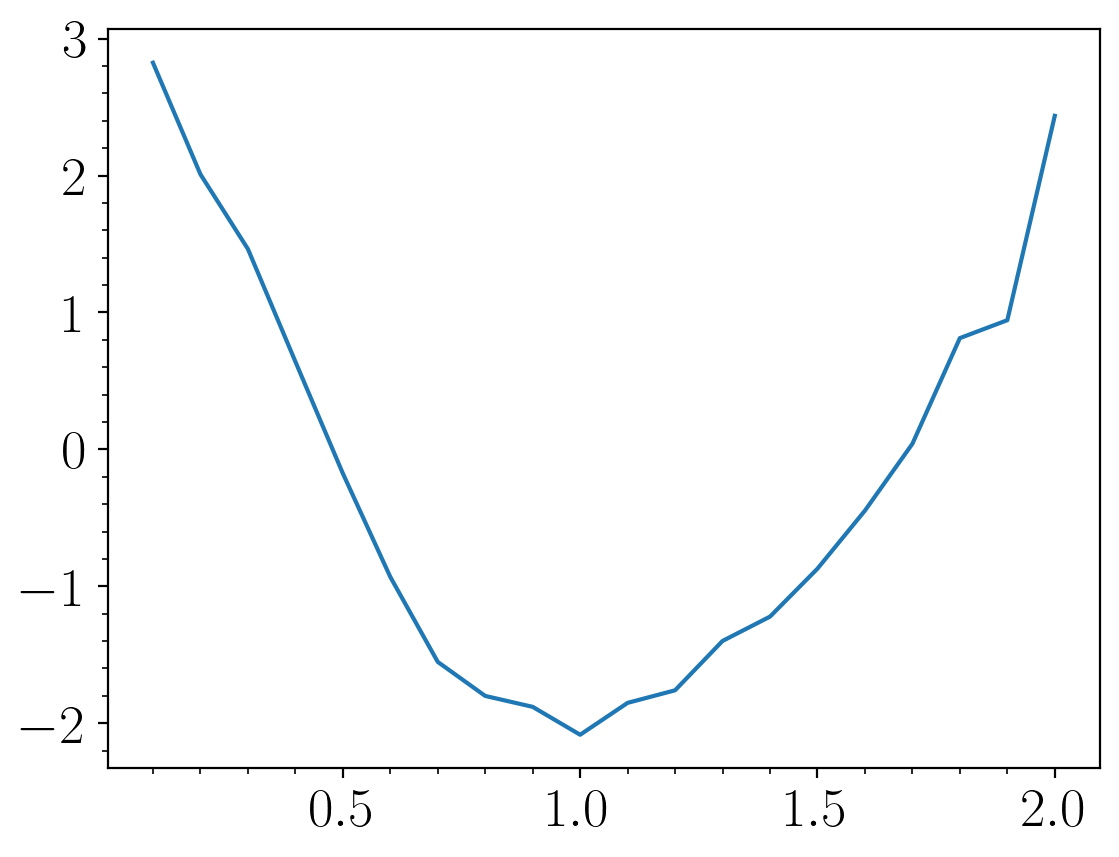

In [60]:
# Check be in R. Maartens et a.l. (2022)

Qterm = 2 * (1 + rHterm) * Qmodel(z_data, Sc_data)

fevol = - total_dlogN_dz(z_data, Sc_data) - dlogH + 2 * rHterm - Qterm

plt.plot(z_data, fevol)

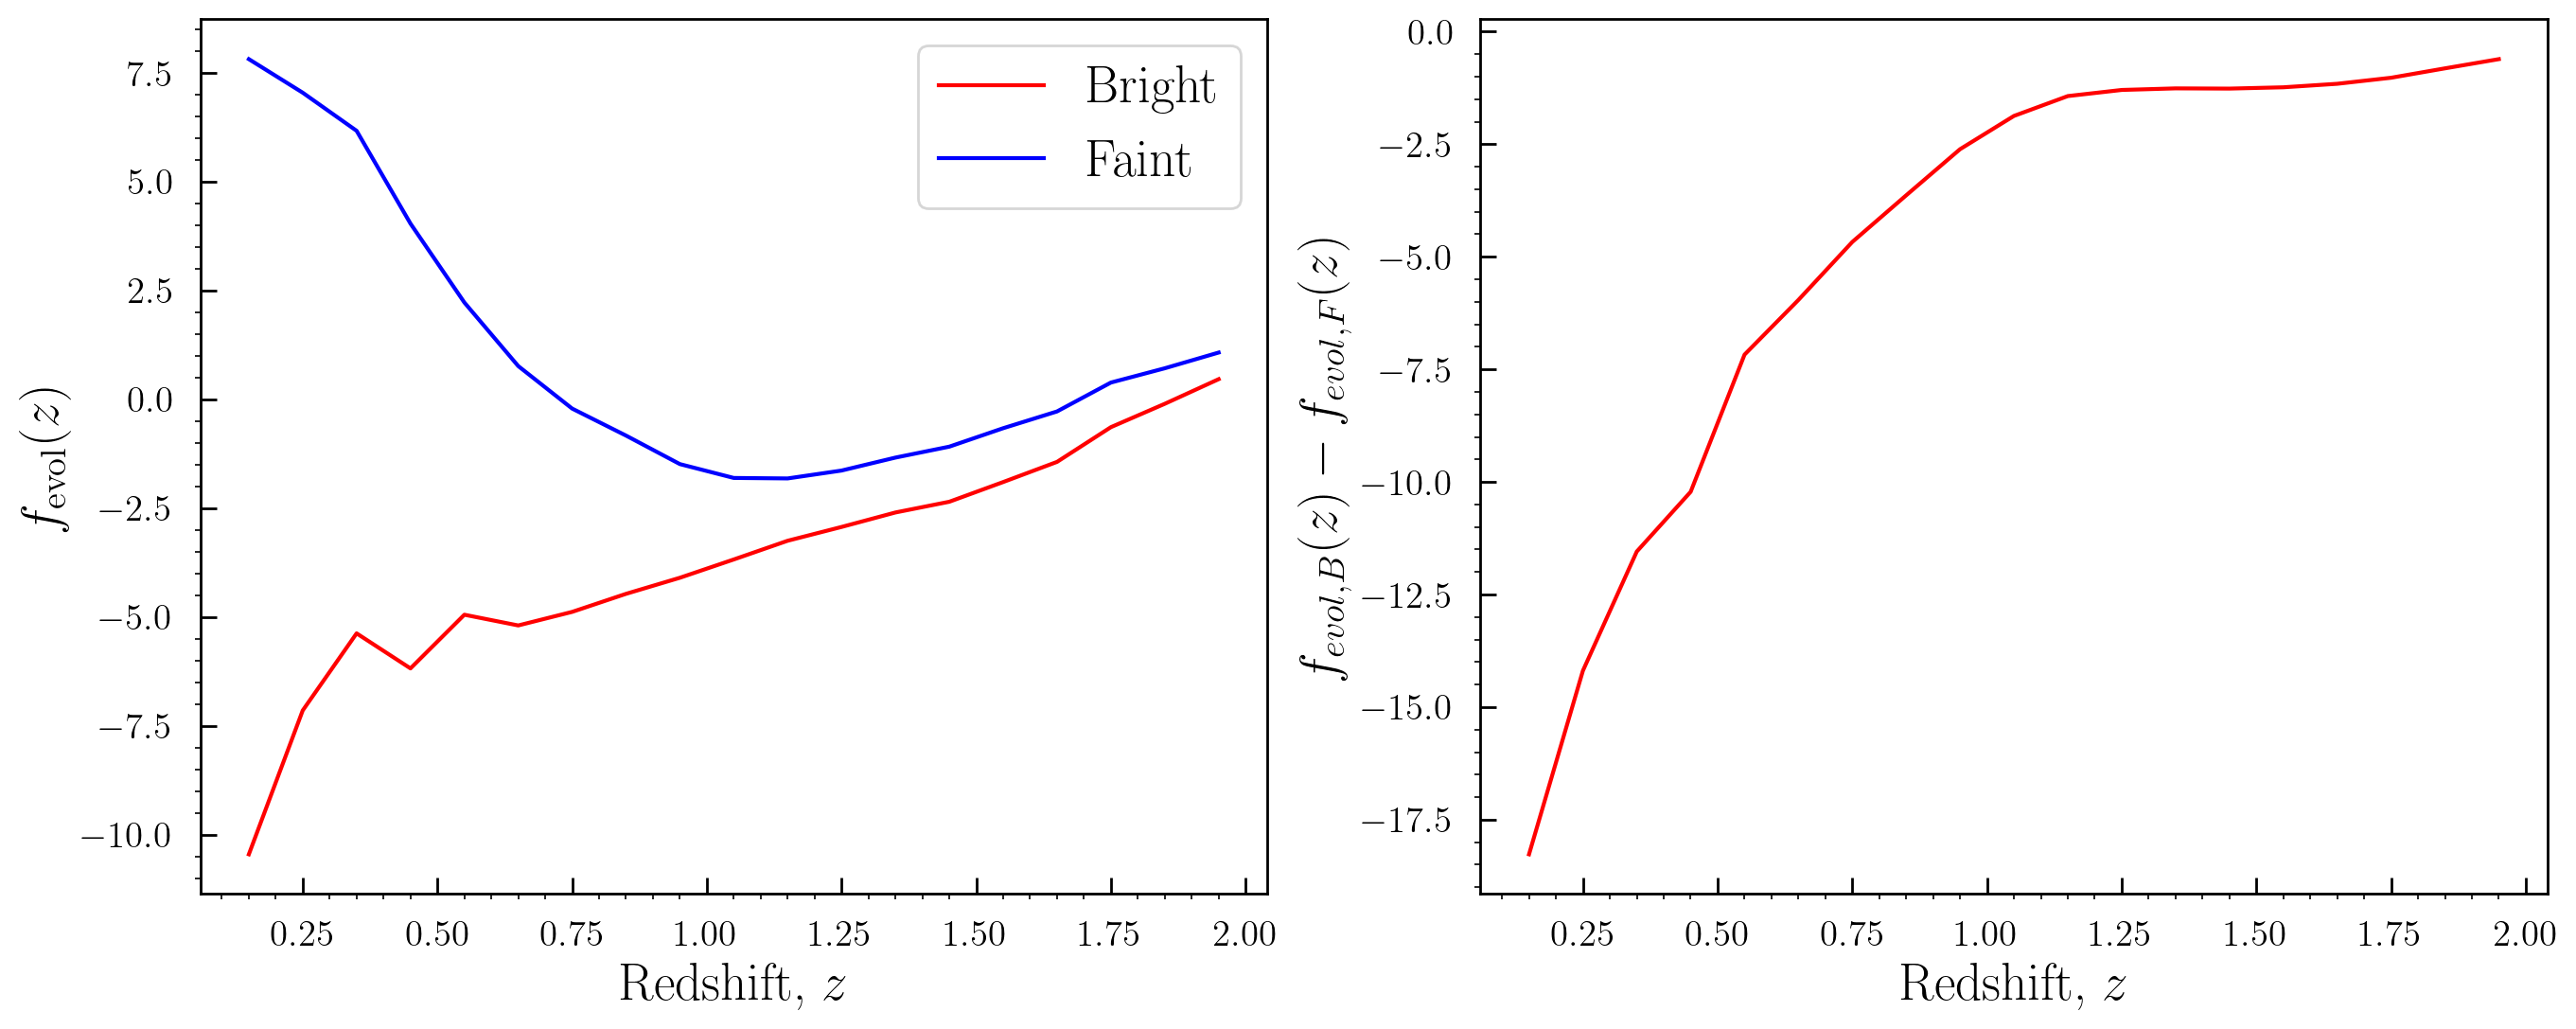

In [61]:
z_analysis = np.linspace(0.15, 1.95, 19)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(z_analysis, fBright_(z_analysis), color = 'r', label = 'Bright')
ax[0].plot(z_analysis, fFaint_(z_analysis), color = 'b', label = 'Faint')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{\mathrm{evol}}(z)$');
ax[0].legend();

ax[1].plot(z_analysis, fBright_(z_analysis) - fFaint_(z_analysis), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

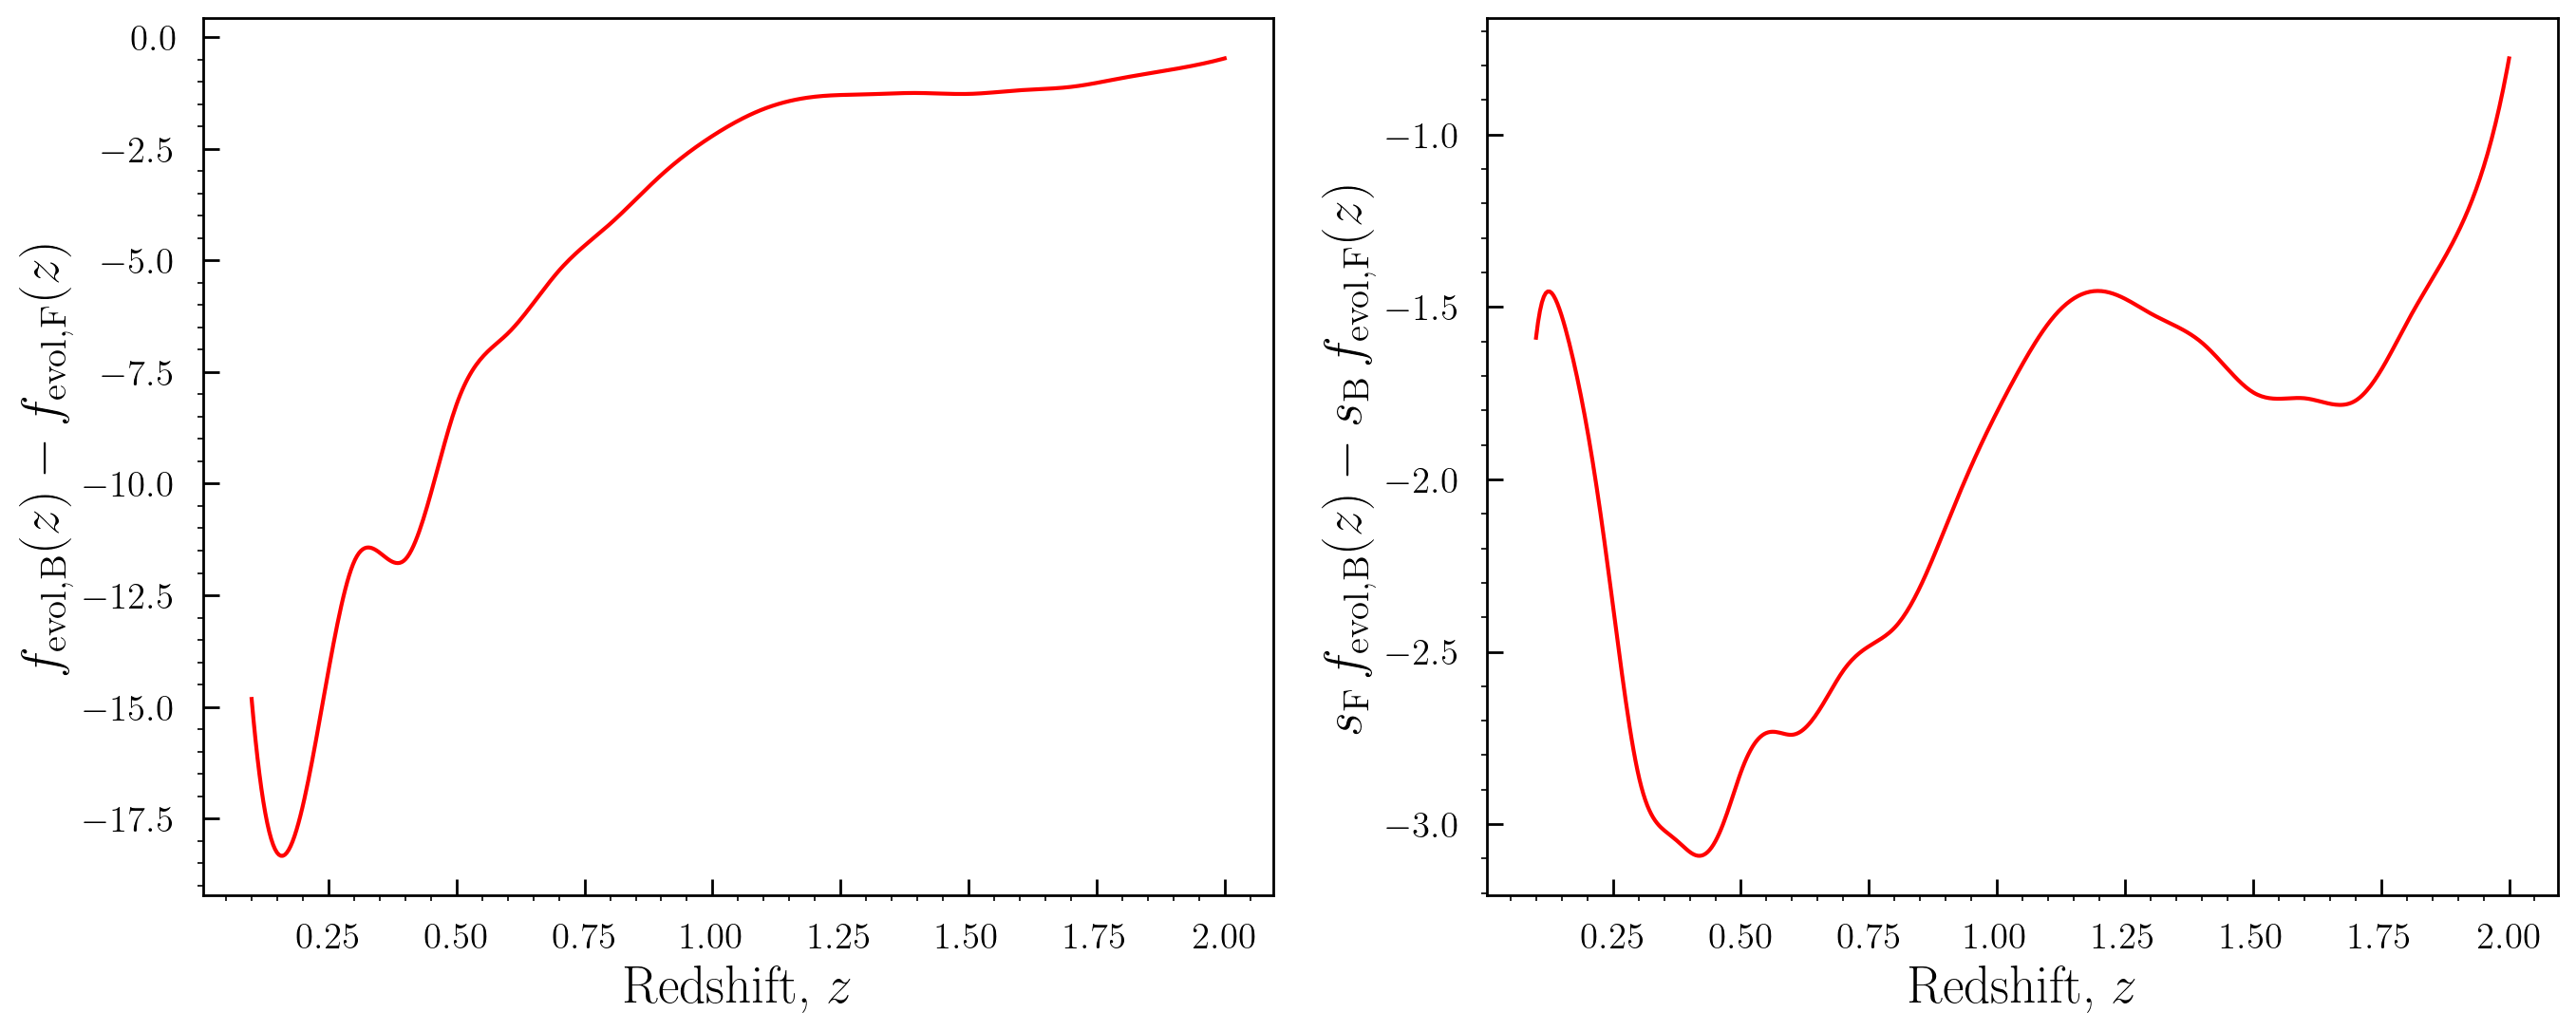

In [62]:
# Plot the different contributions to the dipole

zSKA = np.linspace(0.1, 2.0, 500)

sBright = smodelB(zSKA)
sFaint = n_split * smodelF(zSKA) - smodelB(zSKA)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fBright_(zSKA) - fFaint_(zSKA), color = 'r')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_\mathrm{evol, B}(z)-f_\mathrm{evol, F}(z)$');

ax[1].plot(zSKA, sFaint*fBright_(zSKA) - sBright*fFaint_(zSKA), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{\mathrm{F}}\,f_\mathrm{evol, B}(z)-s_{\mathrm{B}}\,f_\mathrm{evol, F}(z)$');
ax[1].set_ylim();

### TOTAL Derivative of N_g with respect to z (CORRECT ?)

In [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401), where

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{1+z}} + 2\,\frac{(1+z)}{r\,H} - 2\,\left(1+\frac{1+z}{r\,H}\right)\,\mathcal{Q}$$

Where after splitting the populations, we should use $N_\mathrm{g}$ and $\mathcal{Q}$ of each population. The expression is written in terms of the total derivative. Given that we have a flux limit that depends on the redshift, $S_{\mathrm{c}}(z)$:

$$ \frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} = (1+z)\;\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{dz} = (1+z)\,\left[\frac{\partial\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{\partial z}\Bigg|_{S_c} + \frac{\partial\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{\partial S_{\mathrm{c}}}\,\frac{\partial S_{\mathrm{c}}}{\partial z}\right] ,$$

Using the parametrization given also in [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401) (and refs. therein), we have:

$$ \log{N_{\mathrm{g}}}(z,S_{\mathrm{c}}) = \log{10}\,c_1(S_{\mathrm{c}}(z)) + c_2(S_{\mathrm{c}}(z))\,\log{z} - c_3(S_{\mathrm{c}}(z))\,z .$$ 

For the first term in the total derivative, we can perform an intermediate interpolation of the fitting parameters, which depend implicitely on z through the flux limit. Hence, we can get $c_i(z)$. We can then use the Five-point-Stencil method. For the second term, we may use the interpolation with respect to the flux limits, so that $c_i(S_{\mathrm{c}})$. We also have the interpolated function for the flux limits as a function of redshift, $S_{\mathrm{c}}(z)$. Finally, the expression of the total derivative reads:

$$ \frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} = (1+z)\,\left[\frac{c_2(S_{\mathrm{c}})}{z} - c_3(S_{\mathrm{c}}) + \left(c_1'(S_{\mathrm{c}}) \log(10) + c_2'(S_{\mathrm{c}}) \log(z) - c_3'(S_{\mathrm{c}}) z\right) \frac{\partial S_{\mathrm{c}}}{\partial z}\right], $$

where the primes denote derivatives with respect to $S_{\mathrm{c}}$.

In [63]:
# Define the contributions which do not depend on the population

from scipy.integrate import quad

def r_(z, Om = 0.3111):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100/c # h/Mpc^{-1} units
    Oml = 1-Om
    # Comoving distance
    result = quad(lambda x: 1/(H0*np.sqrt(Om * (1+x)**3 + Oml)), 0, z)
    value=result[0]
    return np.array(value)

r=np.vectorize(r_)

def H(z, Om = 0.3111):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100/c # h/Mpc^{-1} units
    H = H0 * np.sqrt(Om*(1+np.array(z))**3 + (1-Om))
    return H
    
def dlogH_f(z, Om=0.3111):
    z = np.array(z)
    c = 299792.458
    H0 = 100/c # h/Mpc^{-1} units
    derivative = H0**2/2 * (3*Om*(1+z)**2) / (H(z)**2)
    return derivative

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

In [64]:
Ncut=10

Sc_data = Srms_fitz(z_data) * Ncut/10

def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

def dlogN_dz(z, Sc, eps=0.0001):
    res = (1+z)*(c2_int(Sc)/z - c3_int(Sc) 
                 + (stencil_derivative(c1_int, x=Sc, h=eps)*np.log(10) + stencil_derivative(c2_int, x=Sc, h=eps)*np.log(z) - stencil_derivative(c3_int, x=Sc, h=eps)*z)*stencil_derivative(Sc_z, x=z, h=eps))
    return res

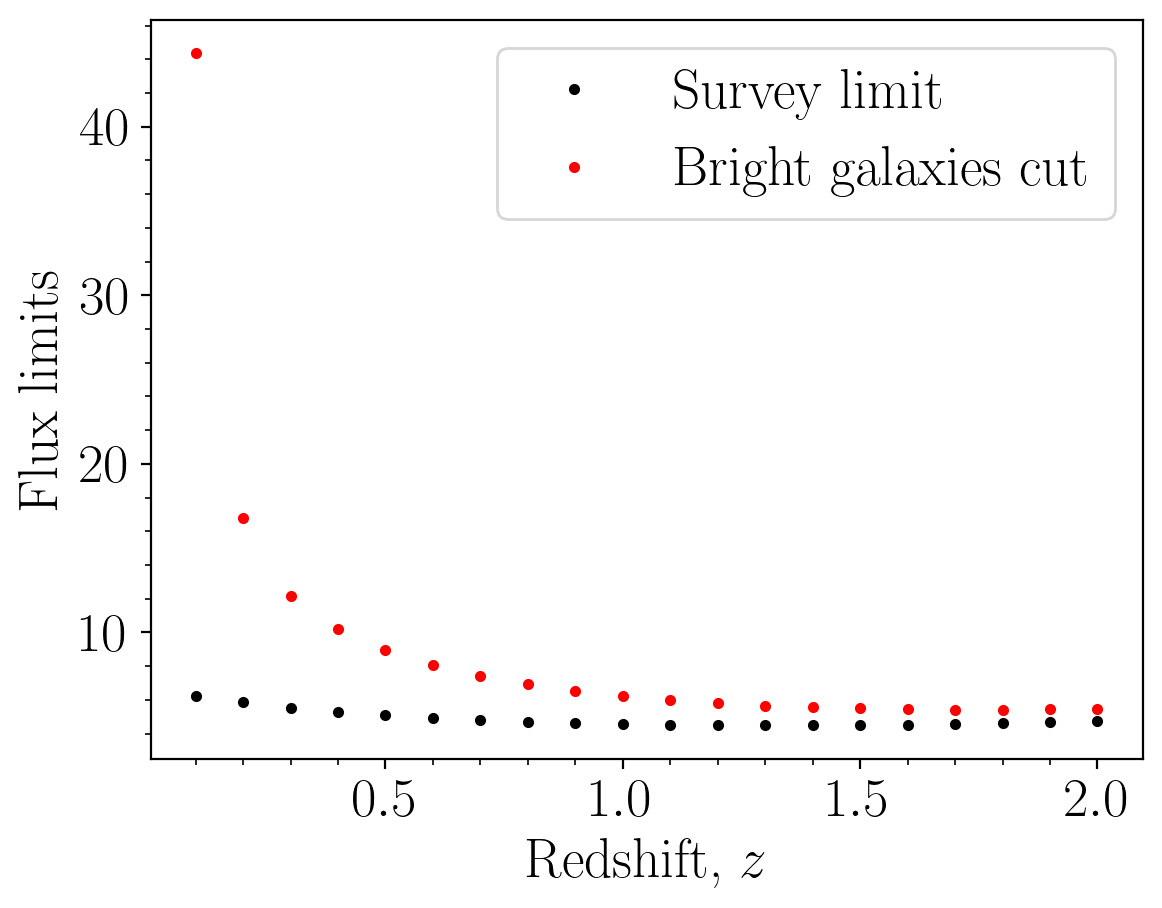

In [65]:
plt.plot(z_data, Sc_data, 'k.', label='Survey limit')
plt.plot(z_data, Sc_bright, 'r.', label='Bright galaxies cut')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Flux limits')
plt.legend();

In [66]:
# Evolution biases

dlogH = (1+z_data) * dlogH_f(z_data)
dlogNB_dz = dlogN_dz(z_data, Sc_bright)
dlogNF_dz = dlogN_dz(z_data, Sc_data) 
rHterm = (1+z_data)/(r(z_data)*H(z_data))

Q_bright = Qmodel(z_data, Sc_bright)
Q_faint = (n_split * Qmodel(z_data, Sc_data) - Qmodel(z_data, Sc_bright))

QtermB = 2 * (1 + rHterm) * Q_bright
QtermF = 2 * (1 + rHterm) * Q_faint


fBright = - dlogNB_dz - dlogH + 2 * rHterm - QtermB
fFaint = - dlogNF_dz - dlogH + 2 * rHterm - QtermF

fBright_ = interp1d(z_data, fBright, kind='cubic', fill_value='extrapolate')
fFaint_ = interp1d(z_data, fFaint, kind='cubic', fill_value='extrapolate')

Text(0, 0.5, '$b_e$')

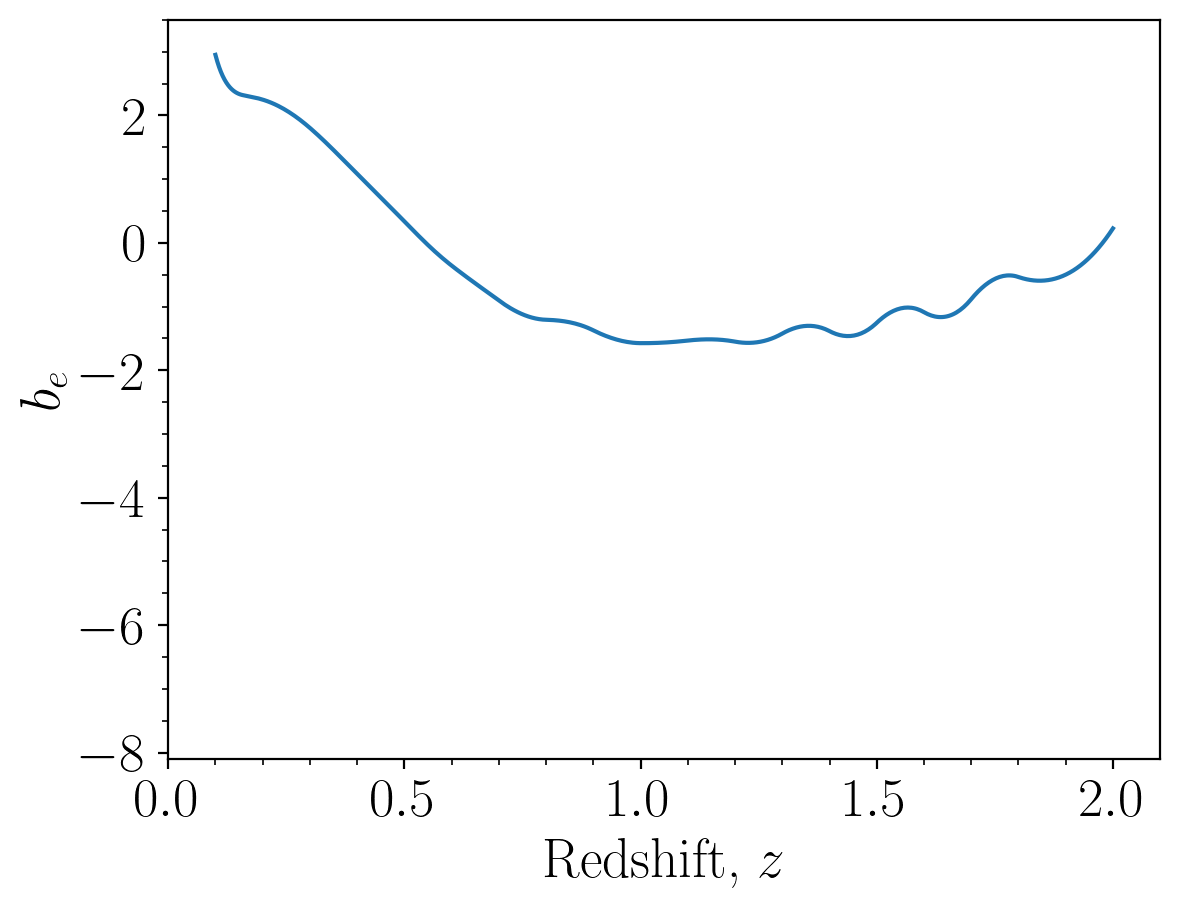

In [67]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+zSKA)/(r(zSKA) * H(zSKA))

dlogH_ = (1+zSKA) * dlogH_f(zSKA)

Qterm_ = 2 * (1 + rHterm_) * Qmodel(zSKA, Sc_z(zSKA))

fevol = - dlogN_dz(zSKA, Sc_z(zSKA)) - dlogH_ + 2 * rHterm_ - Qterm_

plt.plot(zSKA, fevol)
plt.ylim([-8.1, 3.5])
plt.xlim([0.0, 2.1])
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$b_e$')

Text(0, 0.5, '$b_e$')

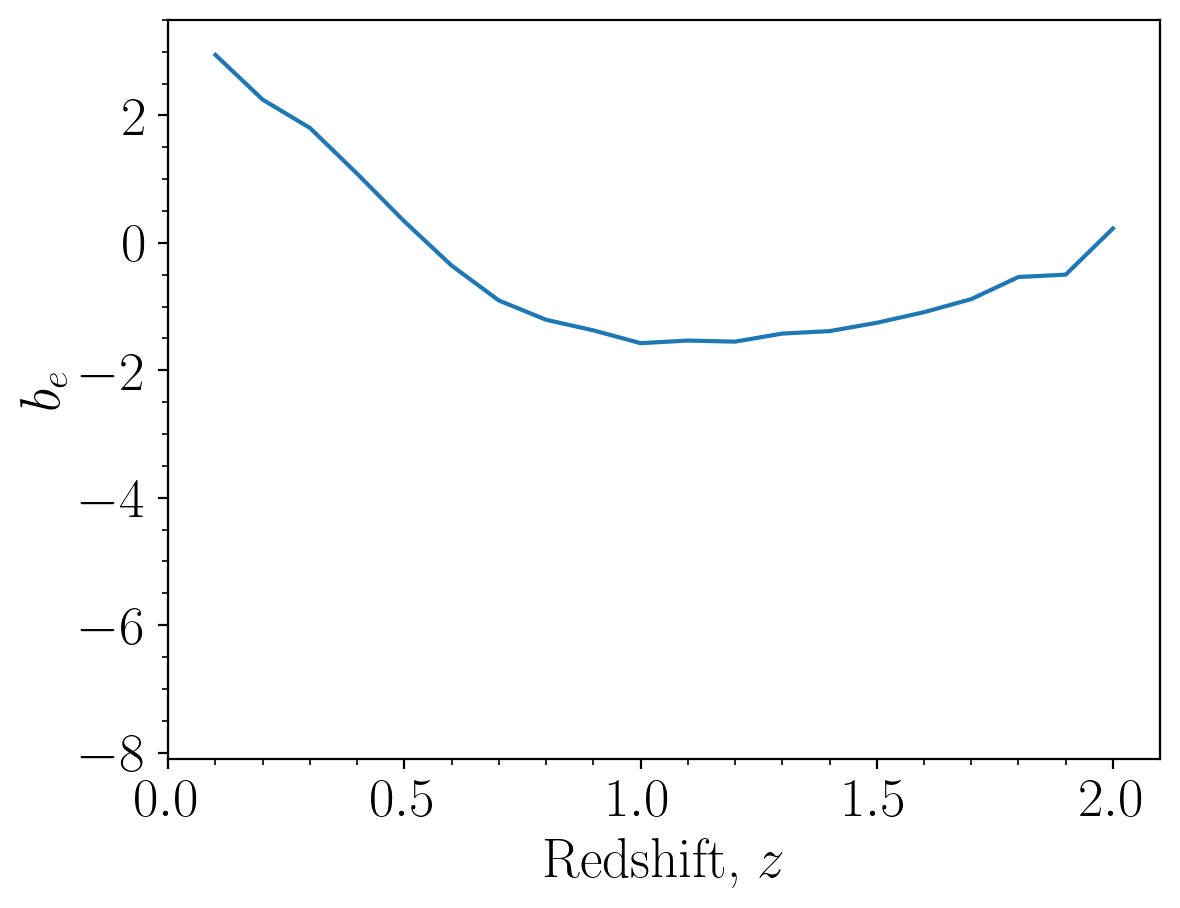

In [68]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+z_data)/(r(z_data) * H(z_data))

dlogH_ = (1+z_data) * dlogH_f(z_data)

Qterm_ = 2 * (1 + rHterm_) * Qmodel(z_data, Sc_z(z_data))

fevol = - dlogN_dz(z_data, Sc_z(z_data)) - dlogH_ + 2 * rHterm_ - Qterm_

plt.plot(z_data, fevol)
plt.ylim([-8.1, 3.5])
plt.xlim([0.0, 2.1])
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$b_e$')

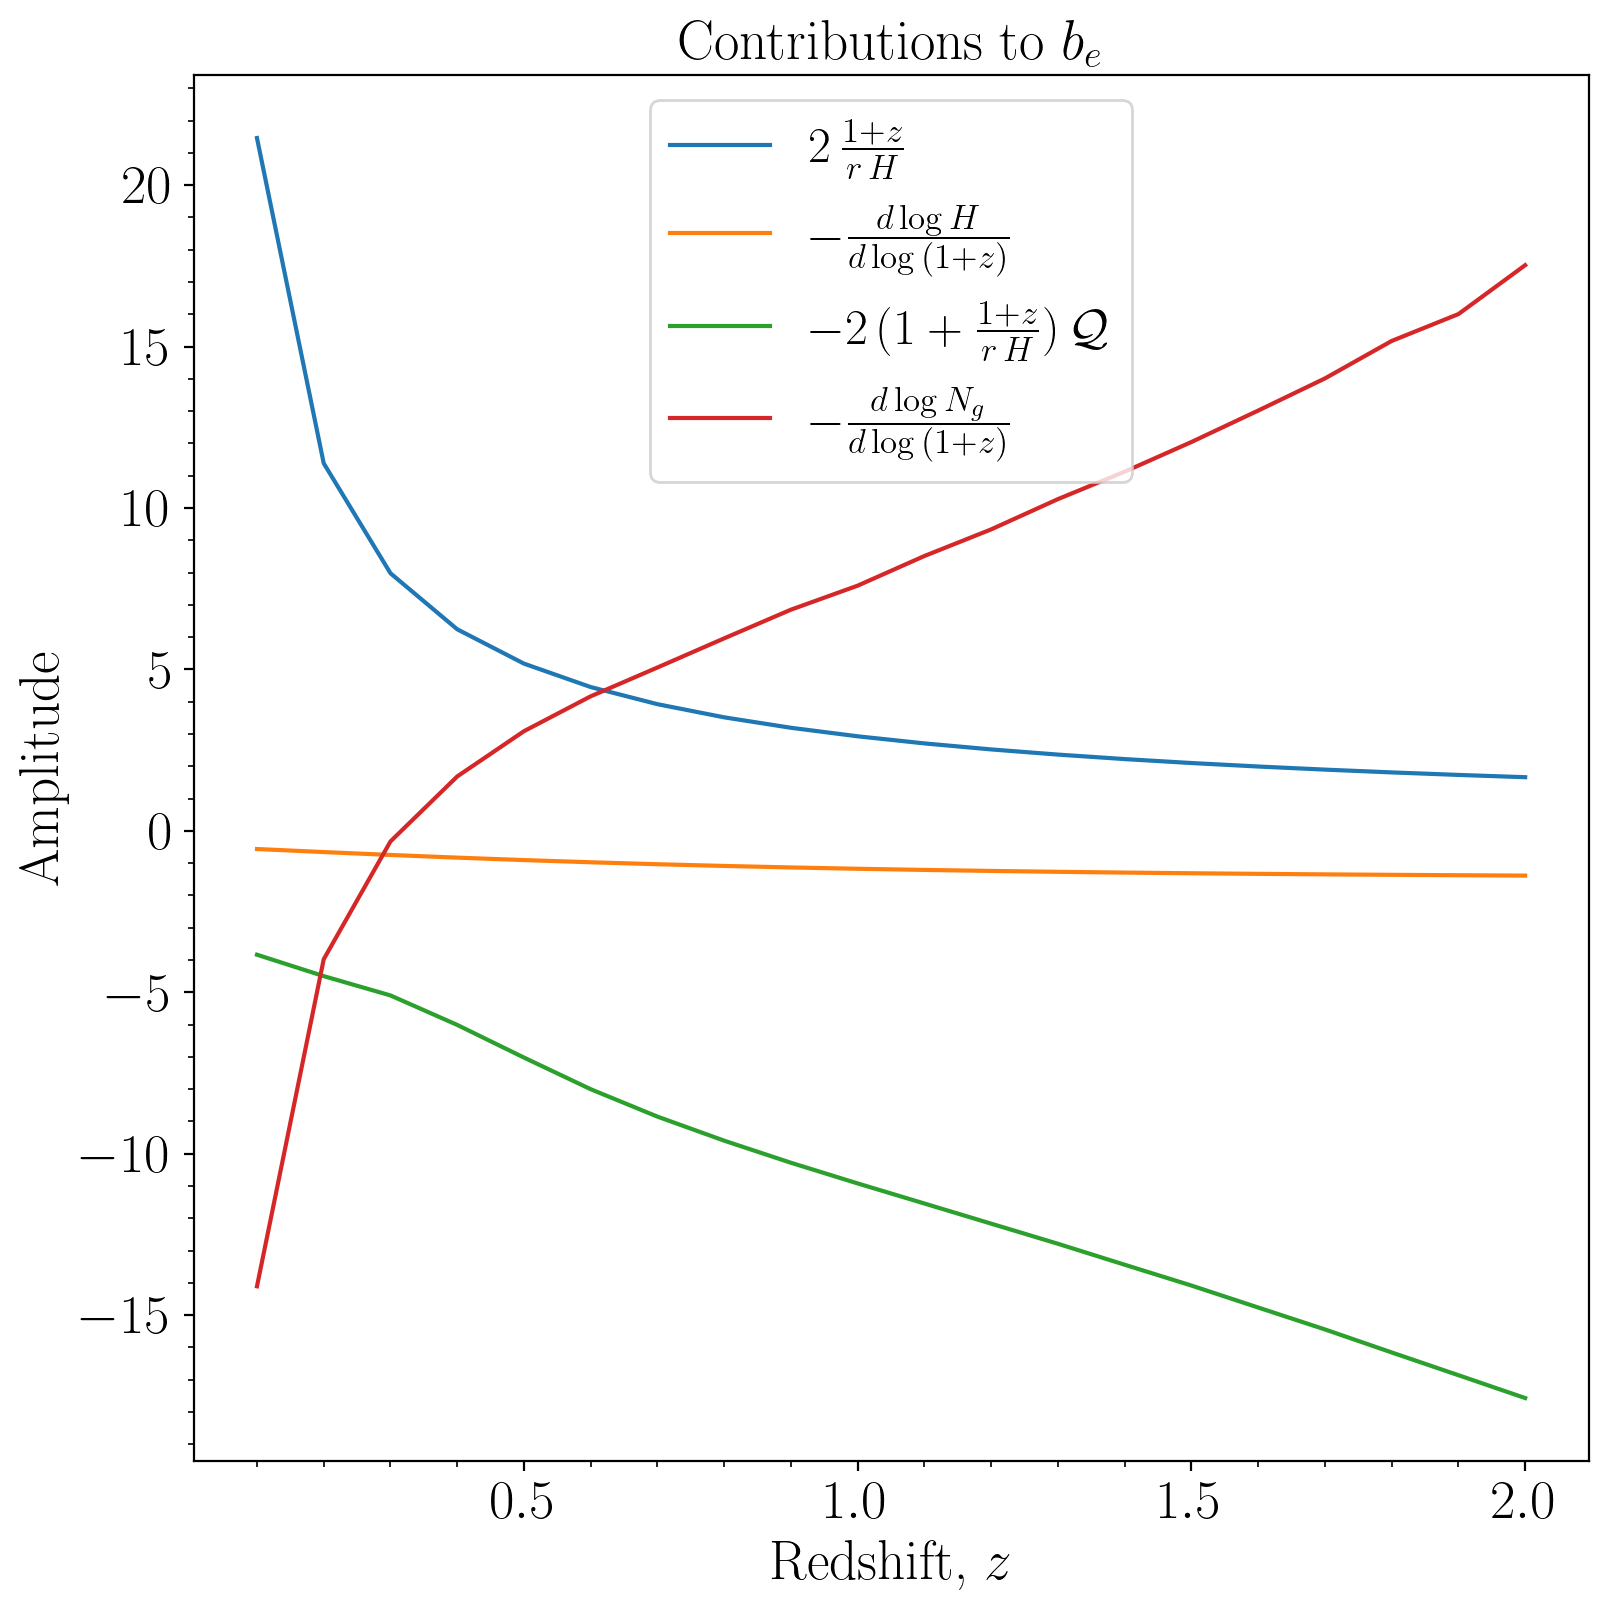

In [69]:
plt.figure(figsize=(9,9))

plt.plot(z_data, 2*rHterm_, label=r'$2\,\frac{1+z}{r\,H}$')
plt.plot(z_data, -dlogH_, label=r'$-\frac{d\log{H}}{d\log{(1+z)}}$')
plt.plot(z_data, -Qterm_, label=r'$-2\,(1+\frac{1+z}{r\,H})\,\mathcal{Q}$')
plt.plot(z_data, -dlogN_dz(z_data, Sc_z(z_data)), label=r'$-\frac{d\log{N_g}}{d\log{(1+z)}}$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Amplitude')
plt.title(r'Contributions to $b_e$')

plt.legend(fontsize=18);

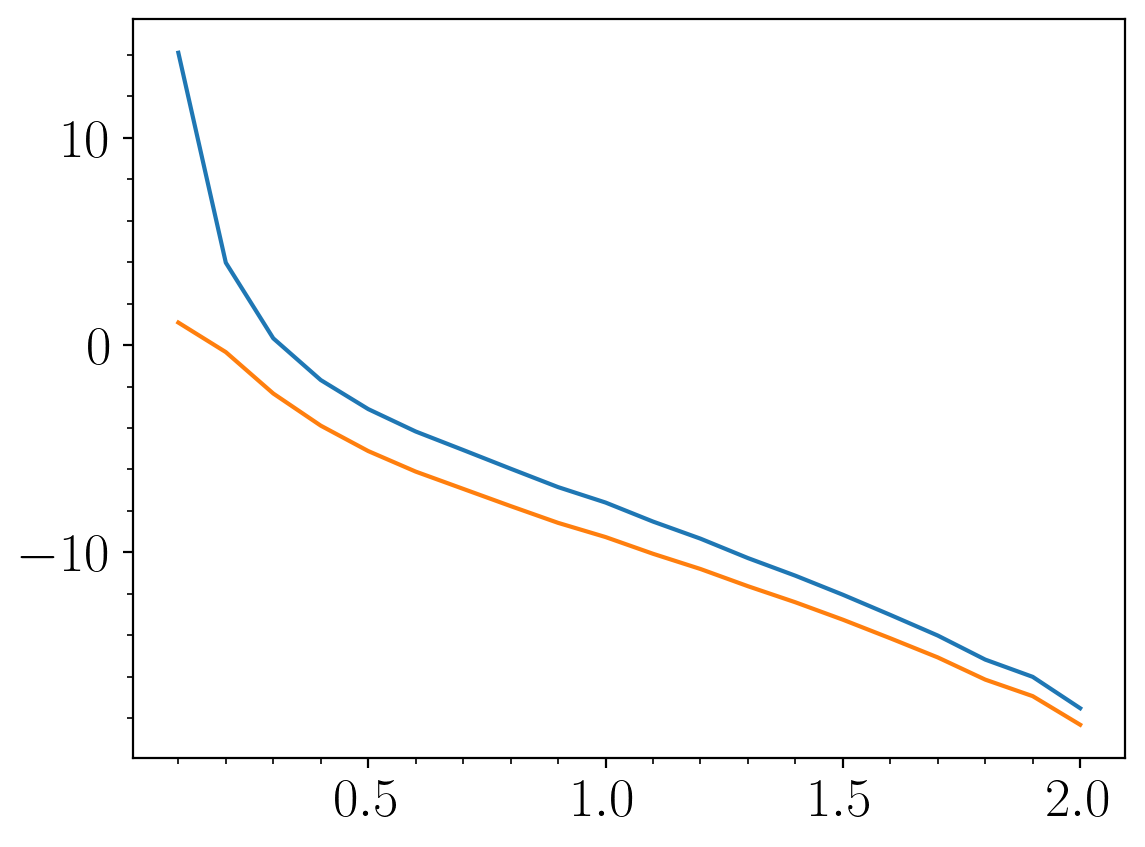

In [70]:
plt.plot(z_data, dlogNF_dz)
plt.plot(z_data, dlogNB_dz)

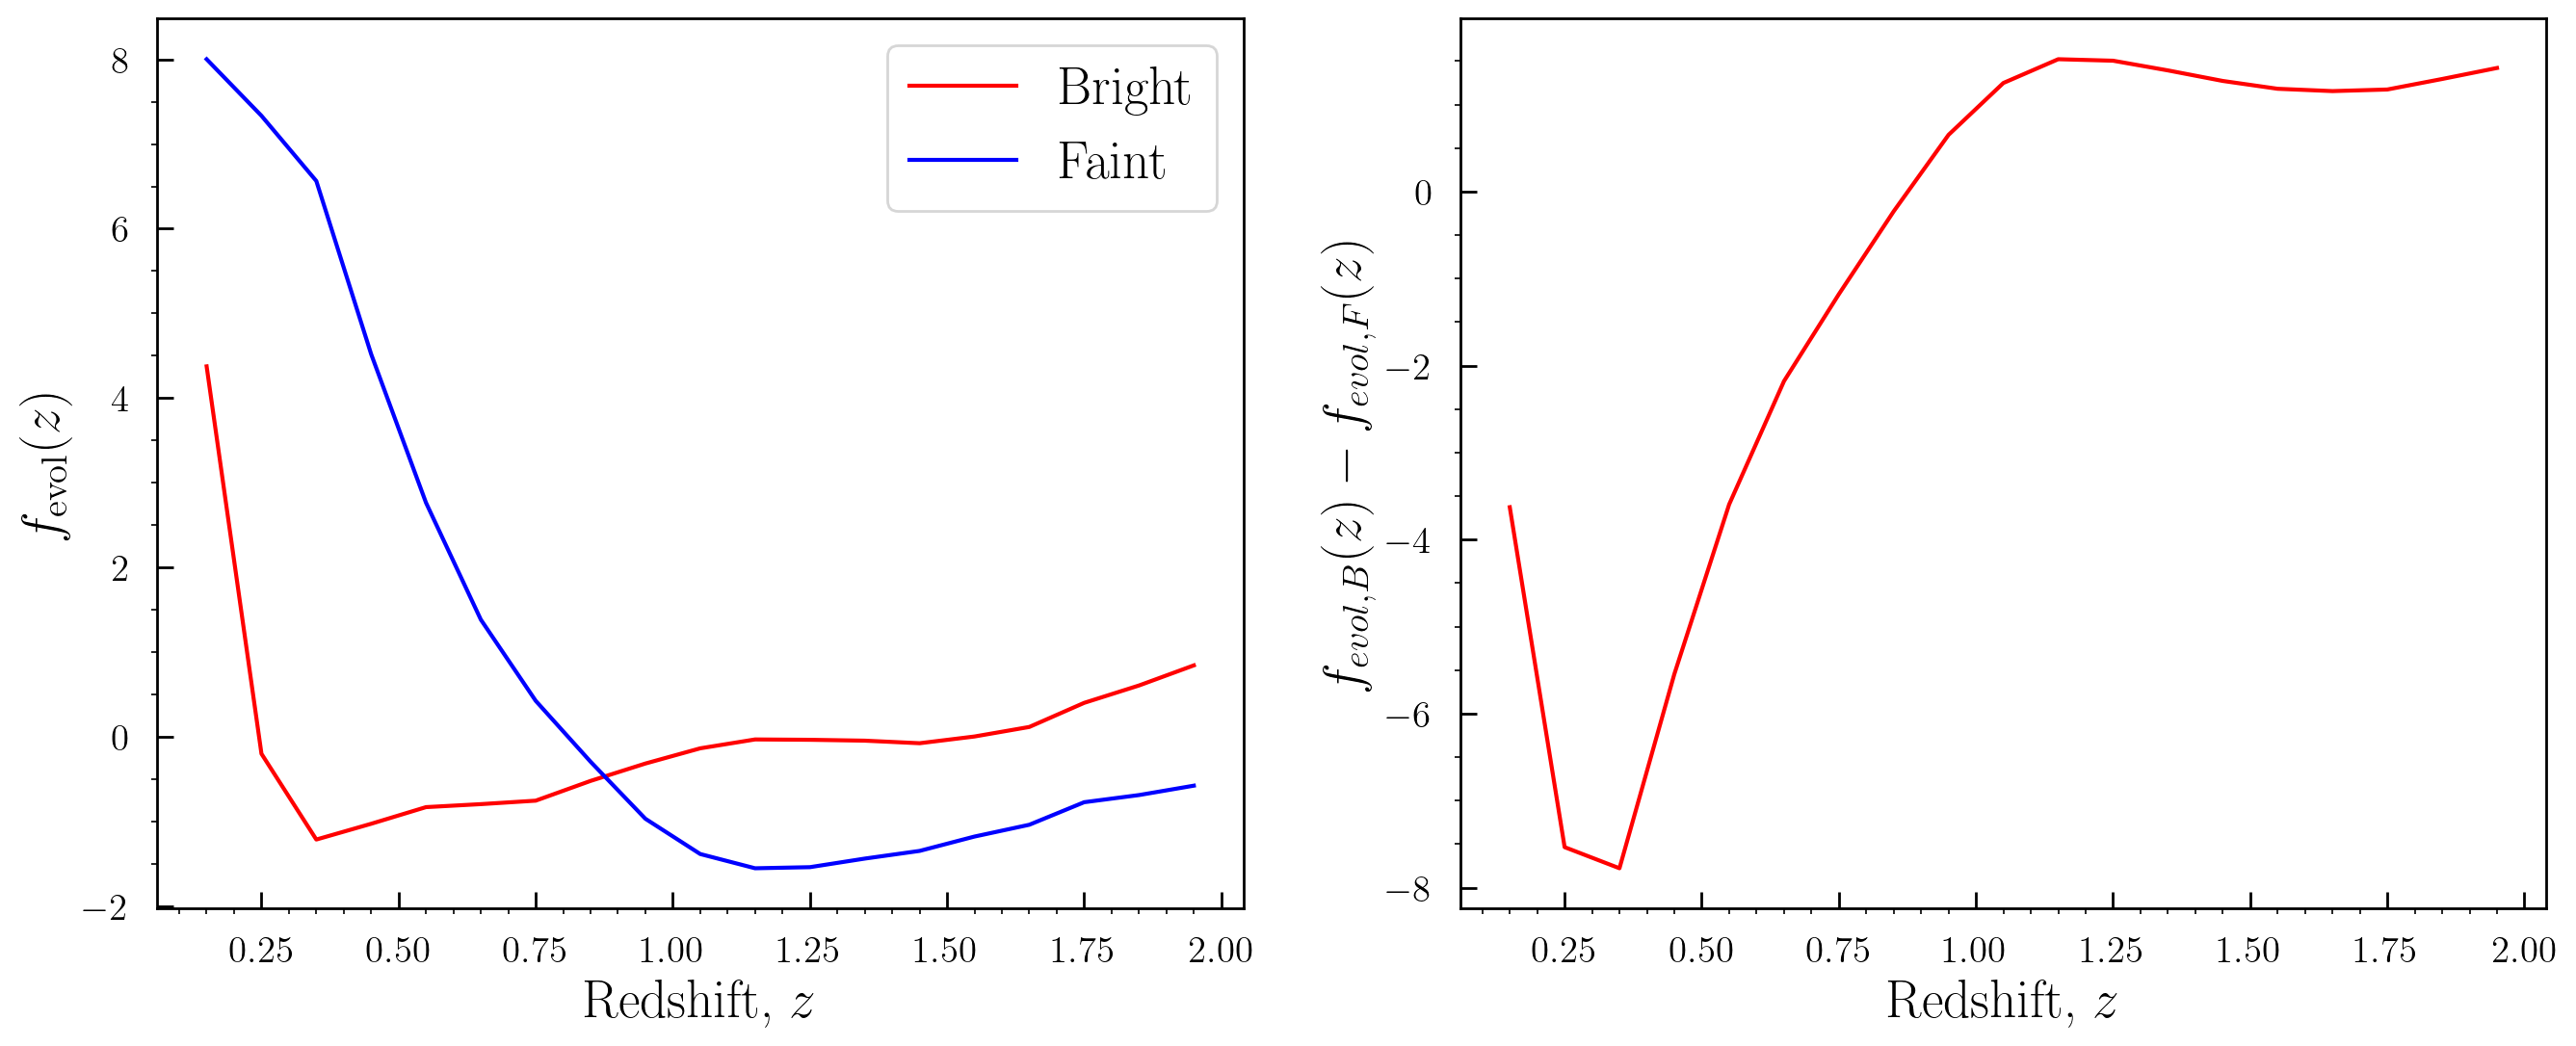

In [71]:
z_analysis = np.linspace(0.15, 1.95, 19)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(z_analysis, fBright_(z_analysis), color = 'r', label = 'Bright')
ax[0].plot(z_analysis, fFaint_(z_analysis), color = 'b', label = 'Faint')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{\mathrm{evol}}(z)$');
ax[0].legend();

ax[1].plot(z_analysis, fBright_(z_analysis) - fFaint_(z_analysis), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

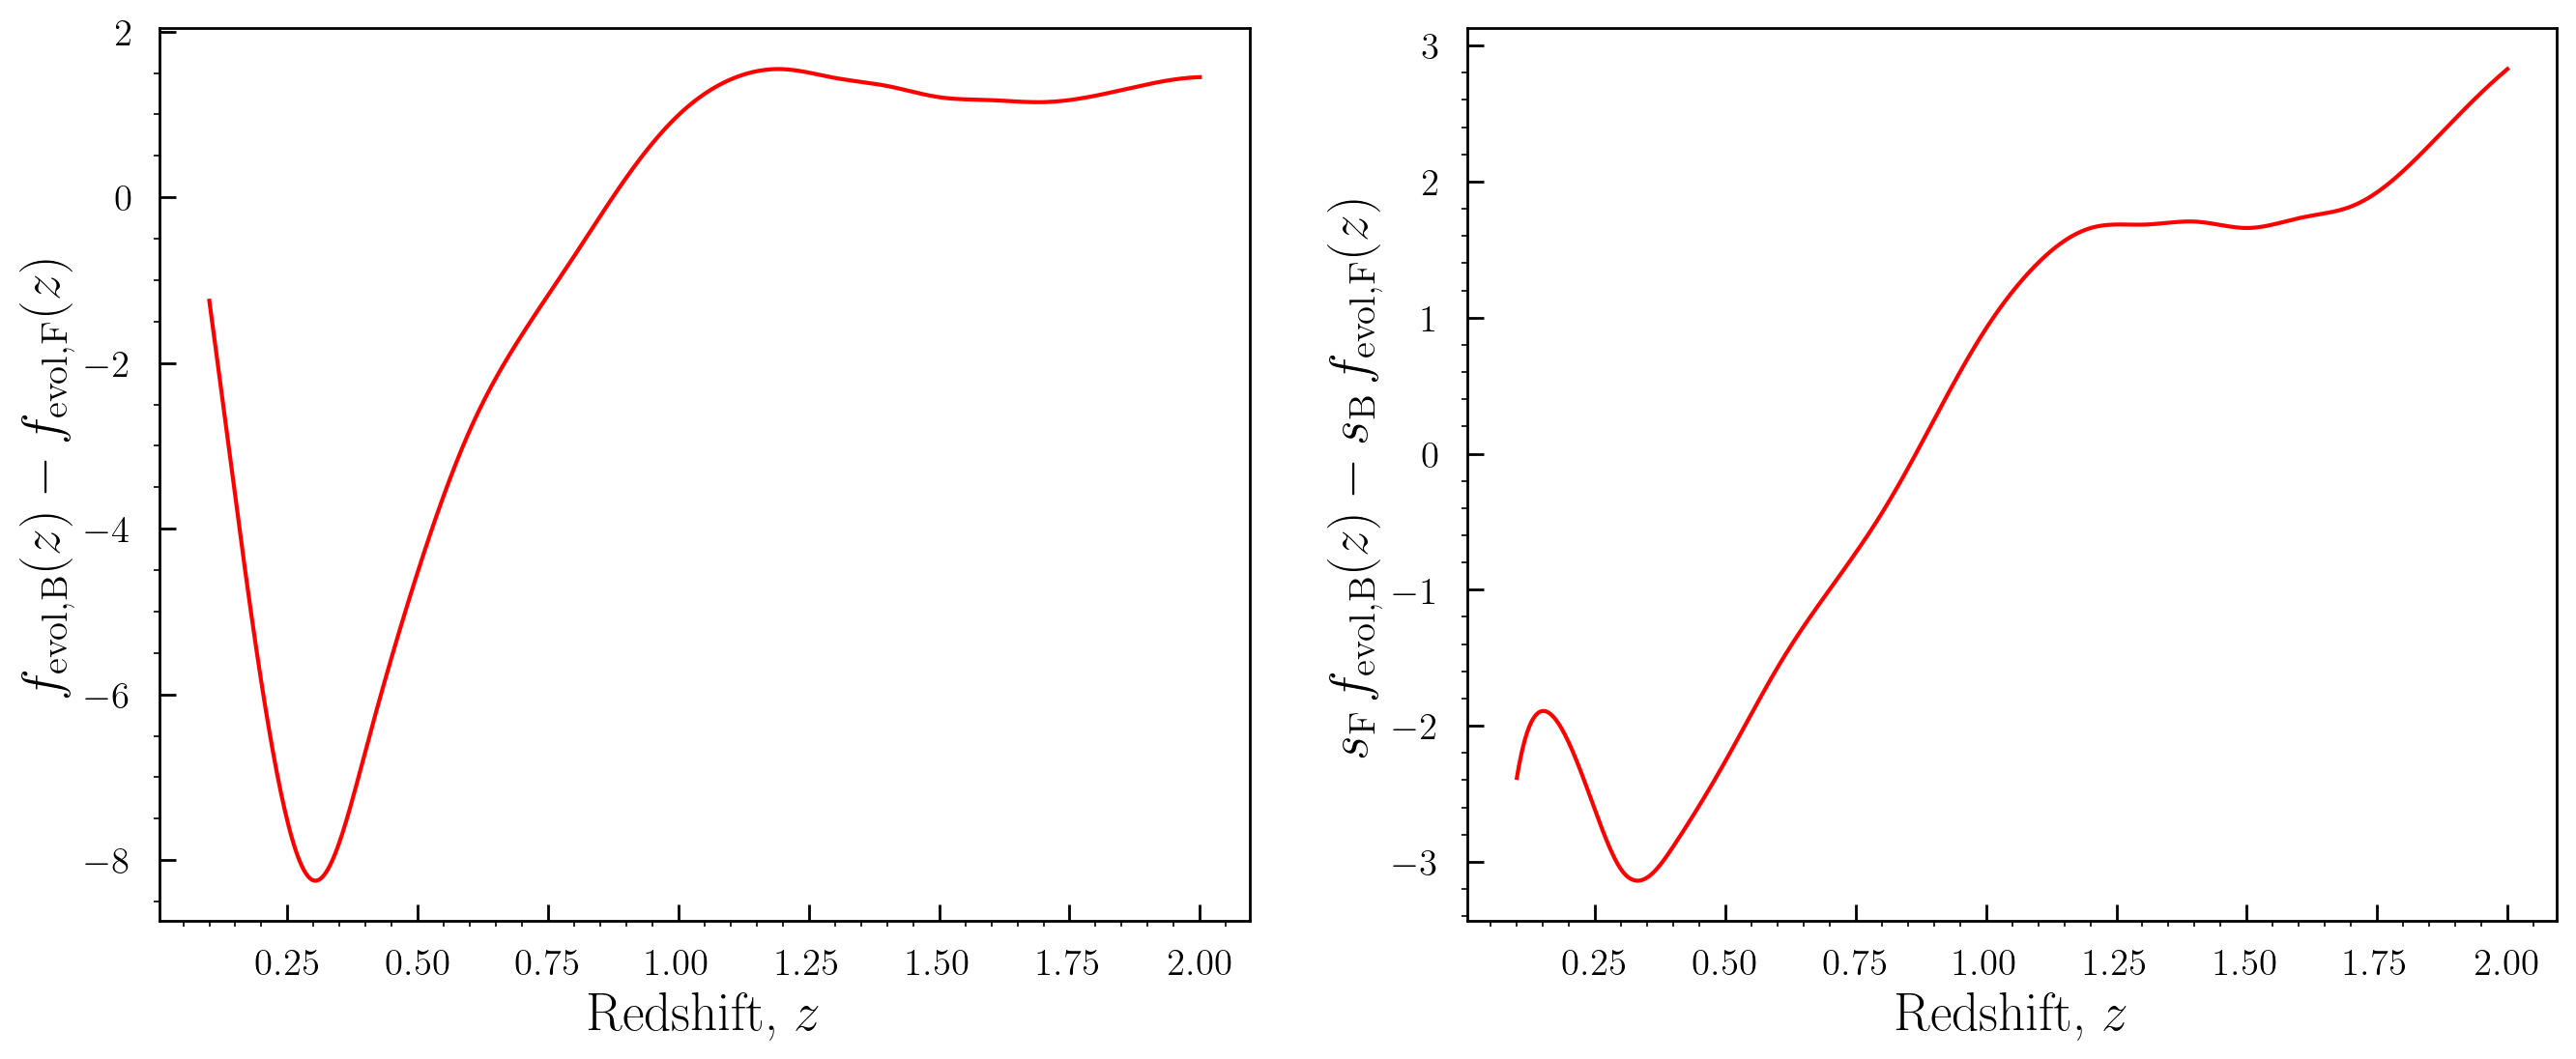

In [72]:
# Plot the different contributions to the dipole

zSKA = np.linspace(0.1, 2.0, 500)

sBright = smodelB(zSKA)
sFaint = n_split * smodelF(zSKA) - smodelB(zSKA)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fBright_(zSKA) - fFaint_(zSKA), color = 'r')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_\mathrm{evol, B}(z)-f_\mathrm{evol, F}(z)$');

ax[1].plot(zSKA, sFaint*fBright_(zSKA) - sBright*fFaint_(zSKA), color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{\mathrm{F}}\,f_\mathrm{evol, B}(z)-s_{\mathrm{B}}\,f_\mathrm{evol, F}(z)$');
ax[1].set_ylim();